# CMPE-259 Transformer Homework

## Professor Jorjeta Jetcheva, T.A. Hardy Leung

### Copyright 2023. All Right Reserved

Welcome to the transformer assignment! This assignment is made of four parts. Part I, II, III are tutorials on tensors, PyTorch, and transformer. Part IV is the actual coding. You only need to write code for Part IV.

The purpose of this assignment is to allow you to get as proficient with the transformer architecture as possible, starting only with decent Python coding skills and a basic understanding of deep learning at a higher level. You probably have _used_ or _adapted_ Keras or PyTorch codes in previous class projects starting with sample code, but it is not a requirement that you have _written_ your own PyTorch code.

You will implement the transformer model on PyTorch almost from scratch, with a minimum amount of external dependencies other than the PyTorch framework and some pre-built modules. Since we are learning about natural language processing, you would have some more idea about embedding and the concept of auto-regressive next-token prediction. You need have a high-level understanding of how transformer works. If not, it is worth your time reading the seminal paper on transformer, "*Attention is All You Need*" by Vaswani et al. https://arxiv.org/pdf/1706.03762.pdf

Hopefully, by the end of this transformer assignment, you will have developed quite a bit of confidence and ability as a professional deep learning practioner or researcher, instead of getting stuck at copying or adapting others' code.

It is strongly advised that you work on this assignment instead of looking up existing transformer implementation -- yes there are existing code out there, though some are very complicated. In fact, if you are not careful, you may end up spending even more time looking at existing code, and at the same time you rob yourself of a great learning opportunity.

Part I and II will get you familiar with the basics of tensors and PyTorch. Don't skip it even if you think you know the materials. Some of them are quite advanced and necessary for transformer implementation.

Part III talks about the mechanics of the transformer, mostly from an implementation perspective.

You don't need to submit anything for Parts I, II, and III.

Part IV is where the actual coding is. Search for the word `FIXME`, and make the appropriate changes. Part IV is further divided into many parts, as we will work on the building blocks towards the end-game of writing a fully functional transformer module. You'll be given instructions along the way. Verification functions are provided so that you know you have implemented each part correctly.

Let's go!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from tqdm import tqdm

In [2]:
torch.manual_seed(42)  # this is to ensure deterministic behavior

---

# [Exercise] Part 4 -- Transformer Implementation

Now we have all the tools to implement transformer, as shown in the following diagram (from the paper "Attention is All You Need" https://arxiv.org/pdf/1706.03762.pdf

---

## 4.1 -- Positional Encoding

Let's start with the positional encoding as a warm-up. You don't need to do anything here, but pay attention to how the information flows, as well as the shapes of the tensors along the way.

This module takes the input which has been embedded in D-dimension per token, and there are `L` tokens (up to `maxL`). The shape of the tensor for a single input sequence therefore is therefore `[L, D]`, and according to the Transformer paper, there should be a matching positional encoding, also of shape `[L, D]`, whose elements should be defined as follows (paper section 3.5):

![Screenshot%202023-10-03%20at%205.06.34%20PM.png](attachment:Screenshot%202023-10-03%20at%205.06.34%20PM.png)

For your convenience, the following Python function can build such positional encoding for you, using matrix manipulation:

```
def positional_encoding_function(maxL, D):
        pe = torch.zeros(maxL, D)
            # pe measures (maxL, D)
        position = torch.arange(0, maxL).unsqueeze(1)
            # (maxL) --> (maxL, 1) via unsqueeze(1)
        coeff = torch.exp(torch.arange(0, D, 2).float() * -(math.log(10000.0) / D))
        
        pe[:, 0::2] = torch.sin(position * coeff)  # fill in even positions
        pe[:, 1::2] = torch.cos(position * coeff)  # fill in odd positions
        return pe
 ```

Now, your job is to implement the module `PositionalEmbedding`, which simply take the input, and _add_ the output of the positional embedding to it, and return. Note that the input would be a tensor of shape `[B, L, D]`, where `B` is the batch size, `L` is the length of the each input token sequence. Note that all of the input token sequences must have the same length, with padding if necessary, and `L` must be less than or equal to `maxL` which is set when we construct the `PositionalEmbedding` object.

To make this assignment as easy as possible, we provide a function called `verify_positional_encoding()` just so you would know if you get it right or not. Pay attention to the fact that the input length may be
smaller than `maxL`. You may need to use the Python subrange functionalities.

In [3]:
def positional_encoding_function(maxL, D):
        pe = torch.zeros(maxL, D)
            # pe measures (maxL, D)
        position = torch.arange(0, maxL).unsqueeze(1)
            # (maxL) --> (maxL, 1) via unsqueeze(1)
        coeff = torch.exp(torch.arange(0, D, 2).float() * -(math.log(10000.0) / D))

        pe[:, 0::2] = torch.sin(position * coeff)  # fill in even positions
        pe[:, 1::2] = torch.cos(position * coeff)  # fill in odd positions
        return pe

In [4]:
positional_encoding_function(10, 4)

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996],
        [-0.7568, -0.6536,  0.0400,  0.9992],
        [-0.9589,  0.2837,  0.0500,  0.9988],
        [-0.2794,  0.9602,  0.0600,  0.9982],
        [ 0.6570,  0.7539,  0.0699,  0.9976],
        [ 0.9894, -0.1455,  0.0799,  0.9968],
        [ 0.4121, -0.9111,  0.0899,  0.9960]])

In [5]:
# FIXME: please implement this custom PyTorch model. To support batching,
#        the shape of self.pe must be [1, maxL, D]

class PositionalEncoding(nn.Module):
    def __init__(self, D, maxL):
        super(PositionalEncoding, self).__init__()
        self.pe = positional_encoding_function(maxL, D).unsqueeze(0)  # FIXME
    def forward(self, x):
        x = x + self.pe[:,:x.size(1),:] #Taking subrange to match the input token length L
        return x # FIXME

In [6]:
def verify_positional_encoding():
    d = 4
    L = 10
    positional_encoding = PositionalEncoding(d, L)

    if positional_encoding.pe.shape != torch.Size([1, L, d]):
        print("** failed (unexpected self.pe shape) **")
        return

    input = torch.tensor([[[0.2431, 0.4980, 0.7206, 0.3775],
         [0.4099, 0.6627, 0.4661, 0.6243],
         [0.0589, 0.3667, 0.1145, 0.1267],
         [0.1336, 0.8447, 0.0353, 0.6310],
         [0.4305, 0.3908, 0.7980, 0.1252]],

        [[0.7211, 0.7129, 0.1923, 0.6771],
         [0.4786, 0.1531, 0.0267, 0.5136],
         [0.1609, 0.2147, 0.3886, 0.6307],
         [0.0440, 0.2393, 0.9905, 0.3157],
         [0.3681, 0.7550, 0.4471, 0.2478]],

        [[0.2217, 0.3223, 0.1107, 0.5803],
         [0.0943, 0.3119, 0.4668, 0.4528],
         [0.9580, 0.6907, 0.6251, 0.5495],
         [0.3926, 0.9498, 0.2189, 0.0112],
         [0.5274, 0.9410, 0.9193, 0.1334]]])
    expected_output = torch.tensor([[[ 0.2431,  1.4980,  0.7206,  1.3775],
         [ 1.2514,  1.2030,  0.4761,  1.6242],
         [ 0.9682, -0.0494,  0.1345,  1.1265],
         [ 0.2747, -0.1453,  0.0653,  1.6306],
         [-0.3263, -0.2628,  0.8380,  1.1244]],

        [[ 0.7211,  1.7129,  0.1923,  1.6771],
         [ 1.3201,  0.6934,  0.0367,  1.5136],
         [ 1.0702, -0.2014,  0.4086,  1.6305],
         [ 0.1851, -0.7507,  1.0205,  1.3153],
         [-0.3887,  0.1014,  0.4871,  1.2470]],

        [[ 0.2217,  1.3223,  0.1107,  1.5803],
         [ 0.9358,  0.8522,  0.4768,  1.4527],
         [ 1.8673,  0.2746,  0.6451,  1.5493],
         [ 0.5337, -0.0402,  0.2489,  1.0108],
         [-0.2294,  0.2874,  0.9593,  1.1326]]])

    print(f'input = {input}')
    print(f'input.shape = {input.shape}')
    print('----------------------------------------------------------------')
    output = positional_encoding(input)
    print(f'output = {output}')
    print(f'output.shape = {output.shape}')
    print('----------------------------------------------------------------')
    print(f'expected_output = {expected_output}')
    print(f'expected_output.shape = {expected_output.shape}')
    print('----------------------------------------------------------------')
    if output.shape != expected_output.shape or \
            torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_positional_encoding() **")

verify_positional_encoding()

input = tensor([[[0.2431, 0.4980, 0.7206, 0.3775],
         [0.4099, 0.6627, 0.4661, 0.6243],
         [0.0589, 0.3667, 0.1145, 0.1267],
         [0.1336, 0.8447, 0.0353, 0.6310],
         [0.4305, 0.3908, 0.7980, 0.1252]],

        [[0.7211, 0.7129, 0.1923, 0.6771],
         [0.4786, 0.1531, 0.0267, 0.5136],
         [0.1609, 0.2147, 0.3886, 0.6307],
         [0.0440, 0.2393, 0.9905, 0.3157],
         [0.3681, 0.7550, 0.4471, 0.2478]],

        [[0.2217, 0.3223, 0.1107, 0.5803],
         [0.0943, 0.3119, 0.4668, 0.4528],
         [0.9580, 0.6907, 0.6251, 0.5495],
         [0.3926, 0.9498, 0.2189, 0.0112],
         [0.5274, 0.9410, 0.9193, 0.1334]]])
input.shape = torch.Size([3, 5, 4])
----------------------------------------------------------------
output = tensor([[[ 0.2431,  1.4980,  0.7206,  1.3775],
         [ 1.2514,  1.2030,  0.4761,  1.6242],
         [ 0.9682, -0.0494,  0.1345,  1.1265],
         [ 0.2747, -0.1453,  0.0653,  1.6306],
         [-0.3263, -0.2628,  0.8380,  1.124

---

## [Exercise] 4.2 -- Feed-Forward

Another module that is described in the Attention paper is a feed-forward module (section 3.3) -- it is made of "two linear transformations with a ReLU activation inbetween".

It would be good if you can translate this directly into code. If not, here is the flow:

```
input --> linear(D, D_ff) --> ReLU   --> linear(D_ff, D) --> output
          (fc1)               (relu)     (fc2)
```

Also make sure you can handle batches, i.e. you would expect the input to have a shape that is `[B, L, D]`. Note that `D` and `D_ff` will be provided as input during the construction of the feed-forward object.

In [7]:
# FIXME: please implement this custom PyTorch model. The constructor takes D
#        and D_ff, which are the size of the shape

class FeedForward(nn.Module):
    def __init__(self, D, D_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(D, D_ff) # FIXME
        self.fc2 = nn.Linear(D_ff, D) # FIXME
        self.relu = nn.ReLU() # FIXME

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x # FIXME

In [8]:
def verify_feed_forward():
    D = 4
    D_ff = 20
    L = 10
    feed_forward = FeedForward(D, D_ff)

    input = torch.tensor([[[0.2431, 0.4980, 0.7206, 0.3775],
         [0.4099, 0.6627, 0.4661, 0.6243],
         [0.0589, 0.3667, 0.1145, 0.1267],
         [0.1336, 0.8447, 0.0353, 0.6310],
         [0.4305, 0.3908, 0.7980, 0.1252]],

        [[0.7211, 0.7129, 0.1923, 0.6771],
         [0.4786, 0.1531, 0.0267, 0.5136],
         [0.1609, 0.2147, 0.3886, 0.6307],
         [0.0440, 0.2393, 0.9905, 0.3157],
         [0.3681, 0.7550, 0.4471, 0.2478]],

        [[0.2217, 0.3223, 0.1107, 0.5803],
         [0.0943, 0.3119, 0.4668, 0.4528],
         [0.9580, 0.6907, 0.6251, 0.5495],
         [0.3926, 0.9498, 0.2189, 0.0112],
         [0.5274, 0.9410, 0.9193, 0.1334]]])
    expected_output = torch.tensor([[[-0.0597,  0.0945,  0.0395, -0.2518],
         [-0.1087,  0.1272,  0.0404, -0.1591],
         [-0.0683,  0.0398, -0.0016, -0.1937],
         [-0.1594,  0.1681, -0.0724, -0.1056],
         [-0.0407,  0.0176,  0.0667, -0.2978]],

        [[-0.1535,  0.1135,  0.0863, -0.0775],
         [ 0.0179,  0.0418,  0.1095, -0.0774],
         [ 0.0021,  0.1400,  0.0694, -0.1814],
         [-0.0618,  0.0594,  0.1050, -0.2809],
         [-0.1225,  0.0564, -0.0130, -0.2060]],

        [[-0.0257,  0.1084,  0.0363, -0.1250],
         [-0.0230,  0.1223,  0.0449, -0.2151],
         [-0.1516,  0.0530,  0.1148, -0.1779],
         [-0.1689,  0.0216, -0.0733, -0.1875],
         [-0.1763,  0.0052, -0.0145, -0.3051]]])

    print(f'input = {input}')
    print(f'input.shape = {input.shape}')
    print('----------------------------------------------------------------')
    output = feed_forward(input)
    print(f'output = {output}')
    print(f'output.shape = {output.shape}')
    print('----------------------------------------------------------------')
    print(f'expected_output = {expected_output}')
    print(f'expected_output.shape = {expected_output.shape}')
    print('----------------------------------------------------------------')
    if output.shape != expected_output.shape or \
            torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_feed_forward() **")

verify_feed_forward()

input = tensor([[[0.2431, 0.4980, 0.7206, 0.3775],
         [0.4099, 0.6627, 0.4661, 0.6243],
         [0.0589, 0.3667, 0.1145, 0.1267],
         [0.1336, 0.8447, 0.0353, 0.6310],
         [0.4305, 0.3908, 0.7980, 0.1252]],

        [[0.7211, 0.7129, 0.1923, 0.6771],
         [0.4786, 0.1531, 0.0267, 0.5136],
         [0.1609, 0.2147, 0.3886, 0.6307],
         [0.0440, 0.2393, 0.9905, 0.3157],
         [0.3681, 0.7550, 0.4471, 0.2478]],

        [[0.2217, 0.3223, 0.1107, 0.5803],
         [0.0943, 0.3119, 0.4668, 0.4528],
         [0.9580, 0.6907, 0.6251, 0.5495],
         [0.3926, 0.9498, 0.2189, 0.0112],
         [0.5274, 0.9410, 0.9193, 0.1334]]])
input.shape = torch.Size([3, 5, 4])
----------------------------------------------------------------
output = tensor([[[-0.0597,  0.0945,  0.0395, -0.2518],
         [-0.1087,  0.1272,  0.0404, -0.1591],
         [-0.0683,  0.0398, -0.0016, -0.1937],
         [-0.1594,  0.1681, -0.0724, -0.1056],
         [-0.0407,  0.0176,  0.0667, -0.297

---

## [Exercise] 4.3 -- Multi-Head Splitting and Combining

You heard about the term "multi-head" attention but do you know how it works? Conceptually, let's say we have a tensor that represents a token sequence of length `L` and dimension `D`. For example (for illustration only),
the following tensor represents a sequence of 12 tokens, with 6 dimensions each. The shape of the tensor is `[12, 6]`:

```
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35],
        [36, 37, 38, 39, 40, 41],
        [42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53],
        [54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65],
        [66, 67, 68, 69, 70, 71]])
```

Many people misunderstood multi-head attention as merely installing multiple copies of the attention mechanism at the expense of higher memory and runtime requirement. That is not correct. Instead, the actual implementation of multi-head attention is to chop the tensor along the dimensions into multiple heads. For example, we can chop the above sequence into 3 heads. So instead of a tensor of shape `[12, 6]`, we have three tensors of shape `[12, 2]`. Moreover, you can look at the three tensors of shape `[12, 2]` as one tensor of shape `[3, 12, 2]`:

```
tensor([[[ 0,  1],
         [ 6,  7],
         [12, 13],
         [18, 19],
         [24, 25],
         [30, 31],
         [36, 37],
         [42, 43],
         [48, 49],
         [54, 55],
         [60, 61],
         [66, 67]],

        [[ 2,  3],
         [ 8,  9],
         [14, 15],
         [20, 21],
         [26, 27],
         [32, 33],
         [38, 39],
         [44, 45],
         [50, 51],
         [56, 57],
         [62, 63],
         [68, 69]],

        [[ 4,  5],
         [10, 11],
         [16, 17],
         [22, 23],
         [28, 29],
         [34, 35],
         [40, 41],
         [46, 47],
         [52, 53],
         [58, 59],
         [64, 65],
         [70, 71]]])
```

Does it make sense? Each of the three "heads" is a sequence of length `L`, each with one third of the original dimensions (which is required to be evenly divisible by the number of heads).

How do you do this? Note that this can be accomplished with some PyTorch tensor manipulation as shown before, but it is not as easy as calling `reshape()`, because the ordering of elements would be wrong.

In the following, you need to implement two functions, `split_heads()` and `combine_heads()` to prepare the data for the multi-head attention mechanism. Both functions need to support batching, namely the input is not just a tensor, but a batch of tensors. More specifically,

`split_heads()` -- this functions takes in a tensor of shape `[B, L, D]`, and a parameter called `H`, where `B` is the batch size, `L` is the length of the token sequence, `D` is the dimension of each token, and return a tensor of shape `[B, H, L, Dh]`, where `Dh` is `D` divided by `h` (integer division). For example, you could start with a batch of 16 sequences, each of which is 1024 tokens long, and each token has an embedding dimension of 256. You call `split_heads()` to split the tensor into 8 heads. The result is a batch of 16 8-header tensors, each of which is 1024 tokens long, and each token has an embedding dimension of 32:

```
[16, 1024, 256] --> [16, 8, 1024, 32]
```

`combine_heads()` -- this function reverses the process of `split_heads()`.

In [9]:
# FIXME: please implement split_heads() and combine_heads()

def split_heads(input, H):  # tensor shape is [B, L, D]
    #Extract the shape of the input sequence
    B, L, D = input.shape
    Dh = D // H; #Do integer division, the dimensions cannot be floats
    #Split Dimension with length D to two dimensions with length H and Dh
    output = input.reshape(B, L, H, Dh)
    #Swap Dimension 1 and 2
    output = output.transpose(1, 2)
    return output # FIXME

def combine_heads(input):  # tensor shape is [B, H, L, D]
    #Extract the shape of the multi-head tensor
    B, H, L, Dh = input.shape
    #Swap the dimensions back
    output = input.transpose(1, 2)
    output = output.reshape(B, L, H * Dh)
    return output # FIXME

In [10]:
def verify_split_combine_heads():
    A = torch.tensor([[[ 0,  1,  2,  3,  4,  5],
         [ 6,  7,  8,  9, 10, 11],
         [12, 13, 14, 15, 16, 17],
         [18, 19, 20, 21, 22, 23]],

        [[24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35],
         [36, 37, 38, 39, 40, 41],
         [42, 43, 44, 45, 46, 47]],

        [[48, 49, 50, 51, 52, 53],
         [54, 55, 56, 57, 58, 59],
         [60, 61, 62, 63, 64, 65],
         [66, 67, 68, 69, 70, 71]]])

    B = torch.tensor([[[[ 0,  1],
          [ 6,  7],
          [12, 13],
          [18, 19]],

         [[ 2,  3],
          [ 8,  9],
          [14, 15],
          [20, 21]],

         [[ 4,  5],
          [10, 11],
          [16, 17],
          [22, 23]]],


        [[[24, 25],
          [30, 31],
          [36, 37],
          [42, 43]],

         [[26, 27],
          [32, 33],
          [38, 39],
          [44, 45]],

         [[28, 29],
          [34, 35],
          [40, 41],
          [46, 47]]],


        [[[48, 49],
          [54, 55],
          [60, 61],
          [66, 67]],

         [[50, 51],
          [56, 57],
          [62, 63],
          [68, 69]],

         [[52, 53],
          [58, 59],
          [64, 65],
          [70, 71]]]])

    print("calling split_heads(input, 3), where input.shape = [3, 4, 6] ...")
    BB = split_heads(A, 3)

    print("calling combine_heads(input), where input.shape = [3, 3, 4, 2] ...")
    AA = combine_heads(B)

    if not torch.equal(B, BB):
        print("** failed split_heads() **")
        return
    if not torch.equal(A, AA):
        print("** failed combine_heads() **")
        return

    print('----------------------------------------------------------------')
    print("** passed verify_split_combine_heads() **")

verify_split_combine_heads()

calling split_heads(input, 3), where input.shape = [3, 4, 6] ...
calling combine_heads(input), where input.shape = [3, 3, 4, 2] ...
----------------------------------------------------------------
** passed verify_split_combine_heads() **


---

## [Exercise] 4.4 -- Masking

The word `mask` appeared only twice in the "Attention is All You Need" paper, but is a significant concept in the transformer implementation, true to the saying that the devil is in the details. We decided to simply give you the full explanation, and provide the functions to generate the masks, so you don't need to do any work (yay!). For completeness, it is good to understand how masking works.

Let's start with the key equation that describes the inner working of transformer:

![Screenshot%202023-10-07%20at%209.04.21%20PM.png](attachment:Screenshot%202023-10-07%20at%209.04.21%20PM.png)

We had explained this concept before. You have a query tensor `Q`, a key tensor `K`, and a value tensor `V`.
The shapes of the tensors are `[B, L_q, D]`, `[B, L_kv, D]`, and `[B, L_kv, D]` respectively, for some
`L_q` and `L_kv` in the second dimension, and `D` in the third dimension. `B` is the size of the
batch, which for the purpose of this discussion, can be treated as a constant. Note that the query and the key tensors can have different shapes -- going back to Part III for more details.

The first attention module in the decoder requires special attention in order to ensure we don't peek into the unknown future. Think about how, during inference, the target tensor is incrementally constructed. Therefore, we need a mask to mask out all query-key pairs that are illegal (by setting the score to negative infinity). More
formally, we want a mask of shape `[L_q, L_k]` such that `mask[q, k] = 1` if this query-key pair is legal, and `mask[q, k] = 0` otherwise.


Let's take a look at all three attentions:

(1) encoder self-attention -- since we know the entire sequence of input already, there is no need to mask out anything. In transformer-speak, a token can attend to another token in the future, since we are talking about the source sequence.

(2) decoder self-attention -- note that the query and the key are from the same tensor, i.e. of shape `[L_q, L_q]`. The mask should be set such that `mask[q, k] = 1` if `q >= k`, and `mask[q, k] = 0` otherwise. Here, `1` is legal, and `0` is illegal. This can be achieved by:

```
def generate_causality_mask(target, debug=False):
    L = target.size(1)
    causality_mask = torch.tril(torch.ones(1, L, L), diagonal=0).int()
    return causality_mask
```

(3) decoder cross-attention -- there is no need for masking because the source tensor is known.

Later on, you can then use the function to mask out entries deemed illegal by replacing the illegal
entries with negative infinity (in practice, we use `-1e9`) using the torch function `masked_fill()`
(see an example below).

Note that, for tensor shape compatibility reason, the function that generate the causality mask
returns a tensor with a shape `[1, L, L]` instead of `[L, L]`.

Triangular mask with ones below the diagonal and zeros above the diagonal.
But Lkv and Lq are of different lengths, right. Then how is the tensor L*L ?

Ah. No. But it is not the decoder cross-attention. It is the decoder self-attention that requires masking. Here only the target tensors are involved. Hence Lq * Lq is the dimension

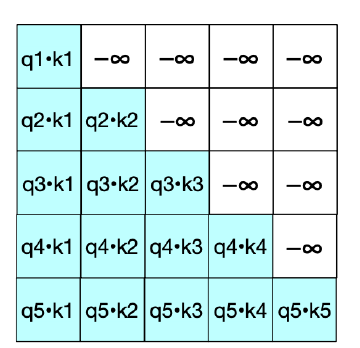

In [11]:
def generate_causality_mask(target):
    L = target.size(1)
    return torch.tril(torch.ones(1, L, L), diagonal=0).int()

In [12]:
t = torch.tensor([[1.5, 0.2, 4.5, -1.2, 2.0]])

causality_mask = generate_causality_mask(t)
print(f'causality_mask = {causality_mask}')
print()
print(f'causality_mask.shape = {causality_mask.shape}')
print('----------------------------------------------------------------')

another_t = torch.arange(0, 25).reshape([1, 5, 5])
print(f'another_t = {another_t}')
print()
print(f'another_t.shape = {another_t.shape}')
print('----------------------------------------------------------------')
another_t_with_masking = another_t.masked_fill(causality_mask == 0, -1e9)
print(f'another_t_with_masking = {another_t_with_masking}')
print()
print(f'another_t_with_masking.shape = {another_t_with_masking.shape}')

causality_mask = tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.int32)

causality_mask.shape = torch.Size([1, 5, 5])
----------------------------------------------------------------
another_t = tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24]]])

another_t.shape = torch.Size([1, 5, 5])
----------------------------------------------------------------
another_t_with_masking = tensor([[[          0, -1000000000, -1000000000, -1000000000, -1000000000],
         [          5,           6, -1000000000, -1000000000, -1000000000],
         [         10,          11,          12, -1000000000, -1000000000],
         [         15,          16,          17,          18, -1000000000],
         [         20,          21,          22,          23,          24]]])

another_t_with_masking.shape = torch.S

In [13]:
def verify_generate_causality_mask():
    t = torch.tensor([[1.4, 1.3, 2.5, 0.1, -1.3, 0.0]])
    causality_mask = generate_causality_mask(t)
    expected_causality_mask = torch.tensor([[[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]]], dtype=torch.int32)
    if not torch.equal(causality_mask, expected_causality_mask):
        print("** failed generate_causality_mask() **")
        return

    print('----------------------------------------------------------------')
    print("** passed verify_generate_causality_mask() **")

verify_generate_causality_mask()

----------------------------------------------------------------
** passed verify_generate_causality_mask() **


![Screenshot%202023-10-04%20at%203.33.32%20PM.png](attachment:Screenshot%202023-10-04%20at%203.33.32%20PM.png)

---


## [Exercise] 4.5 -- Scaled Dot-Product Attention

![Screenshot%202023-10-07%20at%209.04.21%20PM.png](attachment:Screenshot%202023-10-07%20at%209.04.21%20PM.png)


You shall now write an important function (not a module yet) called `scaled_dot_product_attention()`,
which takes in three tensors `Q`, `K`, `V`, an optional parameter called `mask`, and a dimension
`d_k`. This function should return a tensor that computes the equation set forth in section 3.2.1:

Conceptually, each of the tensors `Q`, `K`, `V` is a 2D matrix (of shapes `[L_q, D]`, `[L_k, D]`, and
`[L_v, D]` respectively).
However, in order to support batching and multi-heads, each of them is shaped as a 4-dimensional tensor with shape `[B, H, L_*, D]`, where `B` is the batch size, `H` is the number of heads, and `L_*` is the length of the input sequence.

This function should be completed in 4 steps:

(1) compute the matrix product of `Q` and transposed `K`, divided by the square root of `d_k`. We shall call the result `attn_scores`.

(2) if `mask` is defined (i.e. not `None`), `attn_scores` needs to be masked filled with negative infinity
if the mask entry is zero.

(3) compute `attn_probabilities` which is the softmax of `attn_scores` in the last dimension.

(4) compute `output` which is the matrix product of `attn_probabilities` and the tensor `V`.

In [14]:
# FIXME -- implement scaled_dot_product_attention.

def scaled_dot_product_attention(Q, K, V, d_k, mask=None, negative_infinity=-1e9):
    #Transpose the last two dimensions of the Key tensor to multiply it with the Query tensor
    attn_scores = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(d_k) # FIXME (step 1)
    #If mask is defined, apply that
    if mask is not None:
      attn_scores = attn_scores.masked_fill(mask == 0, negative_infinity) # FIXME (step 2)
    #Softmax on the last dimension
    attn_probabilities = torch.nn.functional.softmax(attn_scores, dim=-1) # FIXME (step 3)
    #Multiply with the Value tensor
    output = torch.matmul(attn_probabilities, V) # FIXME (step 4)
    return output

In [15]:
def verify_scaled_dot_product_attention():
    Q = torch.arange(0, 36, dtype=torch.float).reshape([1, 6, 6])
    K = Q
    V = Q
    d_k = 4
    mask = torch.tensor([[[1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1]]], dtype=torch.int32)
    output1 = scaled_dot_product_attention(Q, K, V, d_k, mask)
    expected_output1 = torch.tensor([[[24., 25., 26., 27., 28., 29.],
         [30., 31., 32., 33., 34., 35.],
         [24., 25., 26., 27., 28., 29.],
         [30., 31., 32., 33., 34., 35.],
         [24., 25., 26., 27., 28., 29.],
         [30., 31., 32., 33., 34., 35.]]])
    if not torch.equal(output1, expected_output1):
        print(f'  output tensor: {output1}')
        print(f'expected tensor: {expected_output1}')
        print("** failed (test 1, with mask) **")
        return

    output2 = scaled_dot_product_attention(Q, K, V, d_k, None)
    expected_output2 = torch.tensor([[[30., 31., 32., 33., 34., 35.],
         [30., 31., 32., 33., 34., 35.],
         [30., 31., 32., 33., 34., 35.],
         [30., 31., 32., 33., 34., 35.],
         [30., 31., 32., 33., 34., 35.],
         [30., 31., 32., 33., 34., 35.]]])
    if not torch.equal(output2, expected_output2):
        print(f'  output tensor: {output2}')
        print(f'expected tensor: {expected_output2}')
        print("** failed (test 2, without mask) **")
        return

    print('----------------------------------------------------------------')
    print("** passed verify_scaled_dot_product_attention() **")

verify_scaled_dot_product_attention()

----------------------------------------------------------------
** passed verify_scaled_dot_product_attention() **


---

## [Exercise] 4.6 -- Multi-Head Attention

We now have all the ingredients to implement multi-head attention. This custom PyTorch should be initialized with only two parameters -- `D` and `H`, which describes the dimension of the input embeddings, and the number of heads in the multi-head attention. See the above schematic diagram for reference, and we'll implement it as is.

There are a total of 4 linear transformations -- 3 in front of `Q`, `K`, and `V`, respectively, and one after the concatenation. They are named `W_q`, `W_k`, `W_v`, and `W_o`, respectively.

The `forward()` function, which takes 4 parameters, `Q`, `K`, `V`, and an optional mask,
should be completed in the following steps:

(1) We'll first take each of the three inputs (`Q`, `K`, and `V`), and perform a linear transform followed immediately by a split (using `split_heads()`).

(2) Perform `scaled_dot_product_attention()` on the split versions of `Q`, `K`, and `V`.

(3) combine (or concatenate) the heads using `combine_heads()`

(4) linear-transform the result using `W_o`, and return the result.

In [16]:
# FIXME

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        assert D % H == 0, "D must be divisible by H"
        self.D = D  # Dimension of input embeddings
        self.H = H  # Number of attention heads

        self.W_q = nn.Linear(D, D)  # FIXME
        self.W_k = nn.Linear(D, D)  # FIXME
        self.W_v = nn.Linear(D, D)  # FIXME
        self.W_o = nn.Linear(D, D) # FIXME
    def forward(self, Q, K, V, mask=None):
        #Linear transformations
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
        #Split
        Q = split_heads(Q, self.H)
        K = split_heads(K, self.H)
        V = split_heads(V, self.H)
        #Perform scaled_dot_product_attention() on the split versions of Q, K, and V.
        heads = []
        for i in range(self.H):
            d_k = self.D // self.H
            head = scaled_dot_product_attention(Q[:, i], K[:, i], V[:, i], d_k, mask)
            heads.append(head)
        #Combine the heads, stack the heads so that the input is in the format for the combine_heads function
        stacked_heads = torch.stack(heads, dim=1)
        #print(stacked_heads.shape)
        final_head = combine_heads(stacked_heads)
        output = self.W_o(final_head)

        return output # FIXME

In [17]:
def verify_multi_head_attention():

    torch.manual_seed(42)
    multi_head_attention = MultiHeadAttention(8, 4)
    T = torch.arange(0, 64, dtype=torch.float).reshape([1, 8, 8])
    output = multi_head_attention(T, T, T, None)
    expected_output = torch.tensor([[[  7.0772,   0.6164,   2.5145,   4.4008,   6.9207,  -0.1517,   0.6336,
           11.7029],
         [  4.9335, -20.1206,   7.0176,  -8.1752,  17.9971,  15.3381,  21.3452,
           33.2856],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555],
         [  4.9166, -20.2839,   7.0531,  -8.2742,  18.0843,  15.4600,  21.5083,
           33.4555]]])
    if output.shape != expected_output.shape or \
            torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_multi_head_attention() **")

verify_multi_head_attention()

** passed verify_multi_head_attention() **


![Screenshot%202023-10-04%20at%203.59.01%20PM.png](attachment:Screenshot%202023-10-04%20at%203.59.01%20PM.png)

---

## [Exercise] 4.7 -- Encoder

The encoder is the gray box to the left. Now we shall implement one copy of the encoder as shown in the diagram. What is slightly inaccurate is that the "Add & Norm" module contains an additional dropout, so it should really have been named "Dropout & Add & Norm". The flow is as follows:

(1) The input is a `[B, L, D]` tensor that has been embedded and modified with positional encoding.

(2) The same input is used as `Q`, `K`, and `V`, and fed into the multi-headed attention, without any masking. Note that the multi-headed magic happends here, and the output of the multi-headed attention has already been stitched back together. At this point, the output tensor's shape remains as `[B, L, D]`.

(3) The output from the previous step goes through a dropout module, then added to the original input (see the bypass arrow), and finally layer-normalized (use `nn.LayerNorm`).

(4) The output from the previous step is sent to the previously-implemented `FeedForward` module.

(5) The output from the previous step goes through a dropout module, then added to the output of step (3) (see the bypass arrow), and finally layer-normalized (use `nn.LayerNorm`).

Beware that we have two `nn.LayerNorm` modules but one `nn.Dropout` module. Why? Because the latter have
no trainable parameters and hence can be shared, whereas `LayerNorms` have weights and thus must be
treated as distinct modules.

** Note: the verify_encoder() function currently only verify the shape but not the content :(

In [18]:
# FIXME

class EncoderLayer(nn.Module):
    def __init__(self, D, H, D_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(D, H) # FIXME
        self.feed_forward = nn.Sequential(
            nn.Linear(D, D_ff),
            nn.ReLU(),
            nn.Linear(D_ff, D)
        ) # FIXME
        self.norm1 = nn.LayerNorm(D) # FIXME
        self.norm2 = nn.LayerNorm(D) # FIXME
        self.dropout = nn.Dropout(dropout) # FIXME

    def forward(self, x, mask=None):
        print(x.shape)
        #Use the input as the Q, K and V tensors in the multi head attention
        multihead_attention_output = self.self_attention(x, x, x, mask)
        print(multihead_attention_output.shape)
        #Dropout output added to the input and normalized
        y = x + self.dropout(multihead_attention_output)
        y = self.norm1(y)
        #Passed through FFN
        ffn_output = self.feed_forward(y)
        y = y + self.dropout(ffn_output)
        y = self.norm2(x)
        return y # FIXME

In [19]:
def verify_encoder():

    torch.manual_seed(42)
    encoder = EncoderLayer(8, 4, 512, 0.1)
    source = torch.arange(0, 96, dtype=torch.float).reshape([1, 12, 8])
    output = encoder(source)
    expected_output = torch.tensor([[[ 0.5762, -0.6034, -1.0468,  0.4817,  0.4329, -0.9277, -0.9290,
           2.0162],
         [ 0.0854, -2.1007, -0.9340,  0.0277,  0.5643,  0.3290,  0.6805,
           1.3478],
         [ 0.3421, -1.7681, -0.8525, -0.2696,  0.6046, -0.4651,  0.7175,
           1.6913],
         [-0.2673, -1.2814, -1.4382, -0.3111,  0.5940,  0.2133,  0.6879,
           1.8027],
         [ 0.2549, -1.8962, -1.2035, -0.2756,  0.6822,  0.4724,  0.6716,
           1.2943],
         [ 0.2053, -1.8633, -0.5447, -0.5181,  1.1194,  0.8945,  1.2529,
          -0.5459],
         [-0.4650, -1.7856, -0.2822, -0.0855, -0.6335,  0.6044,  0.9789,
           1.6684],
         [ 0.1929, -2.1276, -0.7803, -0.3192,  0.5894,  0.4519,  0.6900,
           1.3029],
         [ 0.1802, -2.1396, -0.5653, -0.3975,  0.2714,  0.4724,  0.7409,
           1.4375],
         [ 0.2608, -1.8195, -0.5088, -0.4074,  0.7563,  0.6471, -0.6113,
           1.6829],
         [-0.0986, -2.1989, -0.4897, -0.2996,  0.6097,  0.4313,  0.7269,
           1.3189],
         [ 0.2976, -1.7122, -0.6534, -1.2018,  0.6852,  0.5508,  0.6512,
           1.3825]]])
    if output.shape != expected_output.shape or \
            False: # FIXME torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_encoder() **")

verify_encoder()

torch.Size([1, 12, 8])
torch.Size([1, 12, 8])
** passed verify_encoder() **


---

## [Exercise] 4.8 -- Decoder

This is almost identical to the encoder, but slightly more complicated.

(1) The input is a `[B, L, D]` tensor that has been embedded and modified with positional encoding.

(2) The same input is used as `Q`, `K`, and `V`, and fed into the multi-headed attention. This time, you
need to use a causality-mask.

(3) The output from the previous step goes through a dropout module, then added to the original input (see the bypass arrow), and finally layer-normalized (use `nn.LayerNorm`).

(4) The output from the previous step got fed into the cross attention as the query `Q`, whereas
`encoder_output` (which was passed in) is used as both `K` and `V` (see the diagram). Cross attention
does not need any masking.

(5) Another round of dropout, addition, and layer normalization.

(6) The output from the previous step is sent to the previously-implemented FeedForward module.

(7) Another round of dropout, addition, and layer normalization.

Hopefully you are getting the gist of this process?

** Note: the verify_decoder() function currently only verify the shape but not the content :(

In [20]:
# FIXME

class DecoderLayer(nn.Module):
    def __init__(self, D, H, D_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(D, H) # FIXME
        self.cross_attention = MultiHeadAttention(D, H) # FIXME
        self.feed_forward = nn.Sequential(
            nn.Linear(D, D_ff),
            nn.ReLU(),
            nn.Linear(D_ff, D)
        ) # FIXME
        self.norm1 = nn.LayerNorm(D) # FIXME
        self.norm2 = nn.LayerNorm(D) # FIXME
        self.norm3 = nn.LayerNorm(D) # FIXME
        self.dropout = nn.Dropout(dropout) # FIXME

    def forward(self, x, encoder_output, self_mask, cross_mask=None):
        masked_multihead_attention_output = self.self_attention(x, x, x, self_mask)
        y = x + self.dropout(masked_multihead_attention_output)
        y = self.norm1(y)
        cross_attention_output = self.cross_attention(x, encoder_output, encoder_output, cross_mask)
        y = y + self.dropout(cross_attention_output)
        y = self.norm2(y)
        ffn_output = self.feed_forward(y)
        y = y + self.dropout(ffn_output)
        y = self.norm3(y)
        return y# FIXME

In [21]:
def verify_decoder():

    torch.manual_seed(42)
    encoder = EncoderLayer(8, 4, 512, 0.1)
    decoder = DecoderLayer(8, 4, 512, 0.1)

    source = torch.arange(100, 196, dtype=torch.float).reshape([1, 12, 8])
    target = torch.arange(0, 96, dtype=torch.float).reshape([1, 12, 8])

    encoder_output = encoder(source)
    causality_mask = generate_causality_mask(target)
    output = decoder(target, encoder_output, causality_mask)
    expected_output = torch.tensor([[[-1.2194, -0.8877, -0.8026,  0.6160, -0.9453,  0.7488,  1.5156,
           0.9746],
         [-0.1498, -1.0341, -1.4889,  0.0059, -0.7573,  1.3584,  0.7692,
           1.2964],
         [-1.5095, -0.4470, -1.2332,  0.2313, -0.1101,  1.7068,  0.4629,
           0.8987],
         [ 0.9942, -0.6095, -1.8409, -0.3147,  0.4359,  1.4783, -0.6907,
           0.5473],
         [ 0.9621, -0.3903, -1.8374, -0.5268,  0.5258,  1.1402, -0.8544,
           0.9808],
         [ 1.1269, -0.5522, -1.7475, -0.4149,  0.9871,  1.1282, -0.9014,
           0.3738],
         [ 1.3428, -0.0837, -1.8869, -0.3617,  0.7708,  1.1620, -0.7054,
          -0.2379],
         [ 1.7143,  0.1166, -1.6716, -0.0446, -0.5684,  1.2267, -0.6361,
          -0.1368],
         [ 1.5492, -0.7092, -0.9928, -0.4902,  1.0260,  1.2030, -1.0311,
          -0.5548],
         [ 1.4449,  0.1218, -1.6833, -0.5653,  0.9548,  0.9817, -0.8295,
          -0.4251],
         [ 1.0121, -0.7248, -2.0945, -0.5780,  0.9053,  0.7150,  0.6125,
           0.1523],
         [ 1.4806,  0.1730, -1.6805, -0.6377,  1.0146,  0.8628, -0.7439,
          -0.4688]]])
    if output.shape != expected_output.shape or \
            False: # FIXME torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_decoder() **")

verify_decoder()

torch.Size([1, 12, 8])
torch.Size([1, 12, 8])
** passed verify_decoder() **


![Screenshot%202023-10-04%20at%203.59.01%20PM.png](attachment:Screenshot%202023-10-04%20at%203.59.01%20PM.png)

---

## [Exercise] 4.9 -- Transformer

We are finally ready to put everything together, using the modules we have implement earlier. By now,
hopefully, it would not be difficult to do it.

---

The following are instructions for the constructor:

(1) First, the transformer need to be initialized with the following parameters:

```
    source_vocab_size
    target_vocab_size
    D -- dimension of the embedding
    H -- number of heads
    Nx -- number of stacked encoders and decoders (see diagram)
    D_ff -- output dimension of the feed-forward
    maxL -- maximum sequence length
    dropout -- dropout factor
```   

  You also need to instantiate the modules used accordingly. For your convenience, I have listed them
  in the `__init__()` function, but you do need to properly initialize them.
  
  
(2) `encoder_embedding` should be initialized with `source_vocab_size` as the first parameter, and`decoder_embedding` should be initialized with `target_vocab_size` as the first parameter.

(3) Note that the number of `encoder_layers` and `decoder_layers` are determined by the `Nx`
parameter. As such, we cannot hard-code the layers but instead must use lists. However,
as mentioned in the tutorial, you need to use `nn.ModuleList` instead of just Python list so that
PyTorch can see them as optimizable. To be clear, you will make `Nx` copies of the encoder and
`Nx` copies of the decoder -- i.e. you cannot share the module, as the weights of each encoder
(and decoder) are uniquely and separately optimized.

(4) The input to the transformer `forward()` function is simply `source` and `target`. You
should know by now that both are tensors of shape `[B, L]`, where `L <= maxL`. Note that
the parameter `maxL` is used in the constructor of the positional encoder, but you're allowed
to pass in tensors with the length dimension smaller than `maxL`.

(5) Now look at the diagram carefully. Make sure you initialize each of the module properly
with the right arguments. Note that the parameters `H` (number of heads) and `D_ff` (output
dimension of the feedforward) are needed by both the encoder layers and the decoder layers.

(6) The role of the `fc` module, which is a fully-connected `nn.Linear` module
after the encoder stack, is to project the embeddings (of dimension `D`)
to the target vocabulary (of dimension `target_vocab_size`). In short, for each target token,
we convert the target embedding of the corresponding token
to some kind of unweighted scores.

---

The following are instructions for the `forward()` function.

(7) `nn.Dropout` is a module that is used at two places (see below). However, since it is parameter-less,
you can use it at multiple places without any repercussion. Furthermore,
`positional_encoding` is also parameter-less and therefore can be shared.

(7) On the encoder side, you need to take the source tensor, apply the source embedding,
    apply the positional encoding, and apply dropout (this is needed and described in the paper
    but not explicitly shown in the diagram). Let the output be called `encoder_output`.
    
(8) On the decoder side, you need to take the target tensor, apply the target embedding,
    apply the positional encoding, and apply dropout (this is needed and described in the paper
    but not explicitly shown in the diagram). Let the output be called `decoder_output`.
    
(9) Call `generate_causality_mask(target)` to generate the causality mask.

(10) Take `encoder_output` and feed it through the stack of `Nx` encoders, each call of
which not only take the previous `encoder_output`. Let
the final encode output be called `C` (the source context, see Part III).

(11) Take `decoder_output` and feed it through the stack of `Nx` decoders, each call of
which not only take the previous `decoder_output`, but also the causality maak,
as well as `C`, which is the very last encoder output.

(12) Take `decoder_output` and apply `fc` to get the unweighted likelihood measurement.

(13) That's it! There is no need for the `softmax` here (we'll explain why later).

---

At first glance, this may look overwhelming, but we have just describe how to translate the diagram
to actual PyTorch code. The diagram actually did a very good job conveying all the details
necessarily to implement the transformer module, with only two minor details:

(a) The use of `nn.Dropout` after positional encoding and before encoding or decoding.

(b) The omission of the `softmax` module, which is actually not a bug but a feature --
the `softmax` is calculated as part of the loss function `CrossEntropyLoss()`.

** Note: the verify_transformer() function currently only verify the shape but not the content :(

In [22]:
# FIXME

class Transformer(nn.Module):
    def __init__(self, source_vocab_size, target_vocab_size, D,
                H, Nx, D_ff, maxL, dropout):
        super(Transformer, self).__init__()
        #Source Vocabulary Embedding
        self.encoder_embedding = nn.Embedding(source_vocab_size, D) # FIXME
        #Target Vocabulary Embedding
        self.decoder_embedding = nn.Embedding(target_vocab_size, D) # FIXME
        self.positional_encoding = PositionalEncoding(D, maxL) # FIXME
        #Nx copies of the encoder and Nx copies of the decoder using ModuleList
        self.encoder_layers = nn.ModuleList([EncoderLayer(D, H, D_ff, dropout) for _ in range(Nx)]) # FIXME
        self.decoder_layers = nn.ModuleList([DecoderLayer(D, H, D_ff, dropout) for _ in range(Nx)]) # FIXME
        #Project the embeddings to the target vocabulary
        self.fc = nn.Linear(D, target_vocab_size) # FIXME
        self.dropout = nn.Dropout(dropout)  # FIXME

    def forward(self, source, target):
        # On the encoder side, you need to take the source tensor, apply the source embedding, apply the positional encoding, and apply dropout
        encoder_output = self.dropout(self.positional_encoding(self.encoder_embedding(source)))
        # On the decoder side, you need to take the target tensor, apply the target embedding, apply the positional encoding, and apply dropout
        decoder_output = self.dropout(self.positional_encoding(self.decoder_embedding(target)))
        # Call generate_causality_mask(target) to generate the causality mask.
        causality_mask = generate_causality_mask(target)
        # Take encoder_output and feed it through the stack of Nx encoders, each call of which not only take the previous encoder_output.
        for encoder_layer in self.encoder_layers:
            encoder_output = encoder_layer(encoder_output)
        # Take decoder_output and feed it through the stack of Nx decoders, each call of which not only take the previous decoder_output,
        # but also the causality maak, as well as the last encoder output
        for decoder_layer in self.decoder_layers:
            decoder_output = decoder_layer(decoder_output, encoder_output, causality_mask, None)
        # Take decoder_output and apply fc to get the unweighted likelihood measurement.
        output_scores = self.fc(decoder_output)
        return output_scores # FIXME

In [23]:
def verify_transformer():

    torch.manual_seed(42)
    source_vocab_size = 10
    target_vocab_size = 10
    D = 8
    H = 2
    Nx = 6
    D_ff = 20
    maxL = 100
    dropout = 0.1
    transformer = Transformer(source_vocab_size, target_vocab_size,
                              D, H, Nx, D_ff, maxL, dropout)
    B = 2
    Ls = 5
    Lt = 5
    source = torch.randint(1, source_vocab_size, (B, Ls))
    target = torch.randint(1, source_vocab_size, (B, Lt))
    output = transformer(source, target)
    expected_output = torch.tensor([[[ 1.2637, -1.2294,  0.2417,  0.1209, -0.3542,  0.4997, -0.8134,
           0.0673, -0.0027,  0.0205],
         [ 0.7656, -0.0395, -0.3658, -0.2799, -1.2464,  0.4382, -0.3345,
          -0.7046,  0.2030,  0.2935],
         [ 0.9448, -1.0114,  0.5522, -0.4954, -0.7464,  0.1261, -0.4729,
          -0.0512,  0.2308, -0.3556],
         [ 1.3371, -0.7485, -0.0671, -0.0582, -1.0672,  0.6028, -0.7285,
          -0.4926,  0.0692,  0.1587],
         [ 1.1082, -0.3944, -0.6571,  0.3137, -0.8469,  0.9551, -0.8199,
          -0.2551,  0.1223,  0.7416]],

        [[ 0.6412,  0.5002, -0.2971, -0.4550, -1.1884,  0.7841, -0.5566,
          -0.6515,  0.1819,  0.2816],
         [ 1.0129, -0.9239,  0.3055, -0.2479, -0.8097,  0.3372, -1.0252,
          -0.4146,  0.0477, -0.0251],
         [ 1.2067, -0.5949, -0.4990,  0.2367, -0.9443,  0.8509, -1.0912,
          -0.4610,  0.0049,  0.6044],
         [ 0.9175, -0.6736, -0.5932,  0.2163, -0.8875,  0.6833, -1.1990,
          -0.3715,  0.0667,  0.7133],
         [ 1.4838, -0.4566, -0.4166,  0.3582, -0.7404,  1.0352, -0.9805,
          -0.5391, -0.2400,  0.4358]]])
    if output.shape != expected_output.shape or \
            False: # FIXME torch.max(torch.abs(output - expected_output)) > 1e-04:
        print(f'         output.shape = {output.shape}')
        print(f'               output = {output}')
        print(f'expected_output.shape = {expected_output.shape}')
        print(f'      expected_output = {expected_output}')
        print("** failed (mismatched output) **")
        return

    print("** passed verify_transformer() **")

verify_transformer()

torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
torch.Size([2, 5, 8])
** passed verify_transformer() **


---

## [Exercise] 4.10 -- Training

Congratulations! We have completed the implementation of transformer. That's all the code you need to write. The following is some training code to test the transformer. No need to code anything below.

In [24]:
source_vocab_size = 5000
target_vocab_size = 5000
D = 48
H = 3
Nx = 3
D_ff = 128
maxL = 20
dropout = 0.1

transformer = Transformer(source_vocab_size, target_vocab_size,
                         D, H, Nx, D_ff, maxL, dropout)

In [25]:
B = 64
Ls = maxL  # arbitrary, but must be > 0 and <= maxL
Lt = maxL  # arbitrary, but must be > 0 and <= maxL
source_data = torch.randint(1, source_vocab_size, (B, Ls))
target_data = torch.randint(1, target_vocab_size, (B, Lt))

# generate a [B, L] tensor whose values are [1, source_vocab_size)
# generate a [B, L] tensor whose values are [1, target_vocab_size)

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
    # Hardy: basically, CrossEntropyLoss() compares the output tensor to
    # the target. Conceptually, say we are to compare a K-dimensional
    # vector to an index, where K corresponds to the size of the vocab,
    # which we'll do a softmax. Then, we'll simply take the value of the
    # softmax at the given index, and take a negative log. We do that to
    # all outputs, and take the average. That's the cross entropy loss.
    #
    # For example, let's say K = 4, and the tensor is
    # tensor([0.5, 0.6, 0.7, 0.8]). Note that they don't need to sum to
    # one. Then softmax gives tensor([0.2138, 0.2363, 0.2612, 0.2887]),
    # which sum to one. Let the target index be 2, so the cross entropy
    # is -np.log(0.2612) = 1.342468881579861. The higher the confidence,
    # the lower the cross entropy. These are some reference numbers:
    #    -np.log(0.1) = 2.30
    #    -np.log(0.5) = 0.69
    #    -np.log(0.8) = 0.22
    #    -np.log(0.9) = 0.11
    #    -np.log(0.95) = 0.05
    #    -np.log(0.99) = 0.01

optimizer = optim.Adam(transformer.parameters(),
                      lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
    # Hardy: these are hyperparameters used in the Attention paper

transformer.train()
for epoch in tqdm(range(5001)):
    optimizer.zero_grad()
    output = transformer(source_data, target_data[:, :-1])
    loss = criterion(output.reshape(
        -1, target_vocab_size), target_data[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        tqdm.write(f'Epoch: {epoch+1}, Loss: {loss.item()})')

  0%|          | 0/5001 [00:00<?, ?it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 1/5001 [00:00<38:21,  2.17it/s]

Epoch: 1, Loss: 8.701057434082031)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 2/5001 [00:00<34:10,  2.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 3/5001 [00:01<32:19,  2.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 4/5001 [00:01<34:12,  2.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 5/5001 [00:02<33:40,  2.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 6/5001 [00:02<31:50,  2.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 8/5001 [00:02<27:12,  3.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 10/5001 [00:03<20:17,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 12/5001 [00:03<16:49,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 14/5001 [00:03<15:28,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 16/5001 [00:04<14:49,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 18/5001 [00:04<14:34,  5.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 20/5001 [00:05<14:09,  5.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 22/5001 [00:05<13:53,  5.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  0%|          | 24/5001 [00:05<13:44,  6.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 26/5001 [00:06<13:51,  5.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 28/5001 [00:06<13:57,  5.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 30/5001 [00:06<14:13,  5.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 32/5001 [00:07<13:36,  6.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 34/5001 [00:07<13:21,  6.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 36/5001 [00:07<13:37,  6.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 38/5001 [00:07<13:28,  6.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 40/5001 [00:08<13:11,  6.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 42/5001 [00:08<13:42,  6.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 44/5001 [00:08<13:41,  6.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 46/5001 [00:09<14:11,  5.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 48/5001 [00:09<13:58,  5.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 50/5001 [00:10<14:16,  5.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 52/5001 [00:10<13:55,  5.93it/s]

Epoch: 51, Loss: 8.318833351135254)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 54/5001 [00:10<13:56,  5.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 56/5001 [00:11<13:32,  6.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 58/5001 [00:11<13:17,  6.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 59/5001 [00:11<13:34,  6.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 60/5001 [00:11<15:24,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 61/5001 [00:11<16:31,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|          | 62/5001 [00:12<17:37,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 63/5001 [00:12<18:06,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 64/5001 [00:12<18:35,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 65/5001 [00:12<19:14,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 66/5001 [00:13<19:59,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 67/5001 [00:13<20:12,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 68/5001 [00:13<21:17,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 69/5001 [00:14<21:24,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 71/5001 [00:14<20:13,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 72/5001 [00:14<19:04,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 73/5001 [00:14<18:19,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  1%|▏         | 74/5001 [00:15<16:52,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 76/5001 [00:15<15:35,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 78/5001 [00:15<15:02,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 80/5001 [00:16<14:50,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 82/5001 [00:16<14:40,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 84/5001 [00:16<15:24,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 85/5001 [00:17<15:34,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 86/5001 [00:17<14:54,  5.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 88/5001 [00:17<14:42,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 90/5001 [00:17<14:25,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 92/5001 [00:18<14:00,  5.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 94/5001 [00:18<14:50,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 95/5001 [00:18<14:45,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 97/5001 [00:19<14:09,  5.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 99/5001 [00:19<14:13,  5.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 101/5001 [00:19<14:38,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 101, Loss: 7.960906982421875)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 102/5001 [00:20<14:48,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 104/5001 [00:20<15:04,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 105/5001 [00:20<14:53,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 106/5001 [00:20<17:08,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 107/5001 [00:21<18:12,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 109/5001 [00:21<17:47,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 110/5001 [00:21<16:43,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 112/5001 [00:22<15:52,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 113/5001 [00:22<15:47,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 115/5001 [00:22<15:12,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 116/5001 [00:22<15:13,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 118/5001 [00:23<15:27,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 120/5001 [00:23<14:27,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 122/5001 [00:23<13:41,  5.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 124/5001 [00:24<14:25,  5.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  2%|▏         | 125/5001 [00:24<14:28,  5.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 126/5001 [00:24<16:29,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 127/5001 [00:24<17:14,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 128/5001 [00:25<18:08,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 129/5001 [00:25<18:28,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 130/5001 [00:25<18:53,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 131/5001 [00:25<18:52,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 132/5001 [00:26<18:50,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 133/5001 [00:26<19:47,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 134/5001 [00:26<20:09,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 135/5001 [00:26<20:54,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 137/5001 [00:27<19:53,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 138/5001 [00:27<18:18,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 140/5001 [00:27<16:42,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 141/5001 [00:28<16:03,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 143/5001 [00:28<15:16,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 145/5001 [00:28<15:05,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 146/5001 [00:29<14:55,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 148/5001 [00:29<14:30,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 150/5001 [00:29<13:38,  5.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 152/5001 [00:30<14:19,  5.64it/s]

Epoch: 151, Loss: 7.639278888702393)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 154/5001 [00:30<14:30,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 156/5001 [00:30<14:39,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 158/5001 [00:31<14:36,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 160/5001 [00:31<14:54,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 162/5001 [00:31<14:54,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 163/5001 [00:32<14:52,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 165/5001 [00:32<14:29,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 167/5001 [00:32<13:54,  5.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 169/5001 [00:33<13:37,  5.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 171/5001 [00:33<13:37,  5.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 173/5001 [00:33<13:17,  6.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  3%|▎         | 175/5001 [00:34<13:43,  5.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 177/5001 [00:34<14:46,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 178/5001 [00:34<14:29,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 180/5001 [00:35<13:39,  5.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 182/5001 [00:35<13:45,  5.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 184/5001 [00:35<13:55,  5.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▎         | 186/5001 [00:36<14:07,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 188/5001 [00:36<13:49,  5.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 190/5001 [00:36<14:08,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 192/5001 [00:37<13:54,  5.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 193/5001 [00:37<14:17,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 194/5001 [00:37<16:20,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 195/5001 [00:37<17:50,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 196/5001 [00:38<18:44,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 197/5001 [00:38<18:58,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 198/5001 [00:38<19:01,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 199/5001 [00:38<19:34,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 200/5001 [00:39<20:18,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 201/5001 [00:39<20:19,  3.94it/s]

Epoch: 201, Loss: 7.321418285369873)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 202/5001 [00:39<20:37,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 203/5001 [00:39<20:48,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 205/5001 [00:40<19:25,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 206/5001 [00:40<17:38,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 208/5001 [00:40<15:37,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 210/5001 [00:41<13:54,  5.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 212/5001 [00:41<13:33,  5.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 214/5001 [00:41<13:20,  5.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 216/5001 [00:42<13:23,  5.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 218/5001 [00:42<13:40,  5.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 220/5001 [00:42<13:35,  5.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 222/5001 [00:43<13:09,  6.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  4%|▍         | 224/5001 [00:43<13:14,  6.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 226/5001 [00:43<13:59,  5.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 227/5001 [00:44<14:04,  5.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 229/5001 [00:44<14:44,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 230/5001 [00:44<14:35,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 232/5001 [00:45<14:35,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 234/5001 [00:45<13:33,  5.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 236/5001 [00:45<14:16,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 237/5001 [00:45<14:26,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 239/5001 [00:46<14:15,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 241/5001 [00:46<14:19,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 243/5001 [00:47<14:35,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 245/5001 [00:47<14:41,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 247/5001 [00:47<14:09,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 249/5001 [00:48<14:40,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▍         | 250/5001 [00:48<14:38,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 252/5001 [00:48<14:48,  5.34it/s]

Epoch: 251, Loss: 7.032153606414795)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 253/5001 [00:48<14:24,  5.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 255/5001 [00:49<14:11,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 257/5001 [00:49<14:34,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 258/5001 [00:49<14:34,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 260/5001 [00:50<13:47,  5.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 261/5001 [00:50<14:40,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 262/5001 [00:50<16:19,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 263/5001 [00:50<17:15,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 264/5001 [00:51<18:22,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 265/5001 [00:51<19:39,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 266/5001 [00:51<19:48,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 267/5001 [00:51<20:08,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 268/5001 [00:52<20:22,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 269/5001 [00:52<20:54,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 270/5001 [00:52<21:01,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 271/5001 [00:52<20:34,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 273/5001 [00:53<18:39,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  5%|▌         | 274/5001 [00:53<17:41,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 276/5001 [00:53<16:18,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 277/5001 [00:54<15:57,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 279/5001 [00:54<15:28,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 281/5001 [00:54<15:06,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 283/5001 [00:55<14:55,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 285/5001 [00:55<14:28,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 287/5001 [00:56<14:42,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 289/5001 [00:56<14:02,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 291/5001 [00:56<13:30,  5.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 293/5001 [00:57<14:20,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 294/5001 [00:57<14:02,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 296/5001 [00:57<13:55,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 298/5001 [00:57<13:26,  5.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 300/5001 [00:58<13:49,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 301/5001 [00:58<14:10,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 301, Loss: 6.731592178344727)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 303/5001 [00:58<14:22,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 305/5001 [00:59<13:36,  5.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 307/5001 [00:59<14:29,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 308/5001 [00:59<14:04,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 310/5001 [01:00<13:38,  5.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▌         | 312/5001 [01:00<13:27,  5.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 314/5001 [01:00<13:24,  5.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 316/5001 [01:01<13:04,  5.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 318/5001 [01:01<13:18,  5.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 320/5001 [01:01<13:58,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 321/5001 [01:02<13:57,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 323/5001 [01:02<14:26,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  6%|▋         | 324/5001 [01:02<13:52,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 326/5001 [01:02<14:09,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 327/5001 [01:03<14:27,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 328/5001 [01:03<16:01,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 329/5001 [01:03<17:01,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 330/5001 [01:03<17:24,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 331/5001 [01:04<17:50,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 332/5001 [01:04<18:23,  4.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 333/5001 [01:04<19:18,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 334/5001 [01:04<19:40,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 335/5001 [01:05<19:30,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 336/5001 [01:05<19:27,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 337/5001 [01:05<20:02,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 338/5001 [01:05<20:18,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 340/5001 [01:06<18:31,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 341/5001 [01:06<17:30,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 343/5001 [01:06<15:51,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 344/5001 [01:07<15:22,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 346/5001 [01:07<14:08,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 348/5001 [01:08<16:43,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

  7%|▋         | 349/5001 [01:08<16:16,  4.76it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 350/5001 [01:08<15:34,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 352/5001 [01:08<17:15,  4.49it/s]

Epoch: 351, Loss: 6.467816352844238)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 353/5001 [01:09<16:12,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 354/5001 [01:09<16:12,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 356/5001 [01:09<17:03,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 358/5001 [01:10<14:59,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 360/5001 [01:10<14:07,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 362/5001 [01:10<14:35,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 363/5001 [01:11<14:31,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 365/5001 [01:11<14:12,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 367/5001 [01:11<14:11,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 368/5001 [01:11<14:06,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 370/5001 [01:12<14:25,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 371/5001 [01:12<13:56,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 373/5001 [01:12<14:04,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  7%|▋         | 374/5001 [01:13<14:14,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 376/5001 [01:13<13:48,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 378/5001 [01:13<13:53,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 379/5001 [01:13<14:22,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 380/5001 [01:14<13:57,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 382/5001 [01:14<13:53,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 384/5001 [01:14<13:35,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 386/5001 [01:15<13:18,  5.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 388/5001 [01:15<13:27,  5.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 390/5001 [01:15<13:44,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 391/5001 [01:16<13:57,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 392/5001 [01:16<14:15,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 393/5001 [01:16<16:05,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 394/5001 [01:16<17:22,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 395/5001 [01:17<18:37,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 396/5001 [01:17<18:51,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 397/5001 [01:17<19:21,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 398/5001 [01:17<19:48,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 399/5001 [01:18<19:54,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 400/5001 [01:18<20:37,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 401/5001 [01:18<20:32,  3.73it/s]

Epoch: 401, Loss: 6.212646007537842)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 402/5001 [01:18<20:51,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 404/5001 [01:19<18:29,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 406/5001 [01:19<15:31,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 408/5001 [01:20<14:08,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 410/5001 [01:20<13:22,  5.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 412/5001 [01:20<13:26,  5.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 413/5001 [01:20<13:47,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 415/5001 [01:21<14:22,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 416/5001 [01:21<14:20,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 418/5001 [01:21<14:19,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 420/5001 [01:22<14:03,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 422/5001 [01:22<13:23,  5.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  8%|▊         | 424/5001 [01:22<12:47,  5.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 426/5001 [01:23<12:54,  5.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 428/5001 [01:23<12:48,  5.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 430/5001 [01:23<13:08,  5.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 431/5001 [01:24<13:50,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 433/5001 [01:24<14:15,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 434/5001 [01:24<14:01,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▊         | 436/5001 [01:25<13:23,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 438/5001 [01:25<13:12,  5.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 440/5001 [01:25<12:49,  5.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 442/5001 [01:26<13:03,  5.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 444/5001 [01:26<13:08,  5.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 446/5001 [01:26<12:47,  5.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 448/5001 [01:27<12:47,  5.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 450/5001 [01:27<13:27,  5.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 452/5001 [01:27<13:44,  5.52it/s]

Epoch: 451, Loss: 5.9522857666015625)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 453/5001 [01:28<13:53,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 455/5001 [01:28<14:12,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 456/5001 [01:28<14:17,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 458/5001 [01:28<14:12,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 459/5001 [01:29<14:15,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 460/5001 [01:29<16:24,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 461/5001 [01:29<17:35,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 462/5001 [01:29<17:53,  4.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 463/5001 [01:30<18:12,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 464/5001 [01:30<18:53,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 465/5001 [01:30<19:25,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 466/5001 [01:31<19:17,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 467/5001 [01:31<19:20,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 468/5001 [01:31<19:29,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 469/5001 [01:31<20:02,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 470/5001 [01:32<20:08,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 472/5001 [01:32<17:53,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 473/5001 [01:32<17:14,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


  9%|▉         | 474/5001 [01:32<16:18,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 476/5001 [01:33<14:59,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 477/5001 [01:33<14:56,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 479/5001 [01:33<14:44,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 480/5001 [01:34<14:40,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 482/5001 [01:34<14:36,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 483/5001 [01:34<14:05,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 485/5001 [01:34<13:44,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 10%|▉         | 486/5001 [01:35<13:29,  5.58it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 488/5001 [01:35<13:11,  5.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 490/5001 [01:35<13:38,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 491/5001 [01:36<13:37,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 493/5001 [01:36<14:19,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 494/5001 [01:36<14:10,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 496/5001 [01:36<13:28,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 498/5001 [01:37<13:26,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|▉         | 499/5001 [01:37<13:25,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 501/5001 [01:37<13:19,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 501, Loss: 5.719641208648682)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 503/5001 [01:38<13:02,  5.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 505/5001 [01:38<12:49,  5.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 507/5001 [01:38<13:14,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 509/5001 [01:39<13:43,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 510/5001 [01:39<13:40,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 512/5001 [01:39<14:16,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 513/5001 [01:40<13:56,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 515/5001 [01:40<13:44,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 10%|█         | 516/5001 [01:40<13:44,  5.44it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 518/5001 [01:40<13:58,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 519/5001 [01:41<13:56,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 521/5001 [01:41<13:45,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 523/5001 [01:41<13:45,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 524/5001 [01:42<13:39,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 10%|█         | 525/5001 [01:42<14:18,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 526/5001 [01:42<15:45,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 527/5001 [01:42<16:51,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 528/5001 [01:43<17:19,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 529/5001 [01:43<17:40,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 530/5001 [01:43<17:54,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 531/5001 [01:43<18:52,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 532/5001 [01:44<18:48,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 533/5001 [01:44<18:56,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 534/5001 [01:44<18:57,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 535/5001 [01:44<19:29,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 537/5001 [01:45<18:22,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 538/5001 [01:45<17:24,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 11%|█         | 539/5001 [01:45<16:42,  4.45it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 540/5001 [01:45<15:29,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 542/5001 [01:46<14:41,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 544/5001 [01:46<13:26,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 546/5001 [01:46<13:17,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 548/5001 [01:47<13:11,  5.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 550/5001 [01:47<12:59,  5.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 552/5001 [01:48<13:39,  5.43it/s]

Epoch: 551, Loss: 5.484955787658691)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 553/5001 [01:48<13:19,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 555/5001 [01:48<12:48,  5.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 557/5001 [01:48<12:23,  5.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 559/5001 [01:49<12:57,  5.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█         | 561/5001 [01:49<12:49,  5.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 563/5001 [01:49<12:27,  5.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 565/5001 [01:50<12:26,  5.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 567/5001 [01:50<12:38,  5.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 569/5001 [01:51<13:36,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 570/5001 [01:51<13:56,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 571/5001 [01:51<13:28,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 573/5001 [01:51<13:04,  5.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 11%|█▏        | 575/5001 [01:52<13:18,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 577/5001 [01:52<13:19,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 578/5001 [01:52<13:49,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 579/5001 [01:52<13:56,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 581/5001 [01:53<14:19,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 582/5001 [01:53<14:01,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 584/5001 [01:53<13:59,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 585/5001 [01:54<14:05,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 586/5001 [01:54<13:51,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 588/5001 [01:54<13:57,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 589/5001 [01:54<13:32,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 591/5001 [01:55<13:04,  5.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 592/5001 [01:55<14:18,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 593/5001 [01:55<15:19,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 594/5001 [01:55<15:55,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 595/5001 [01:56<16:10,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 596/5001 [01:56<16:33,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 597/5001 [01:56<17:08,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 598/5001 [01:56<17:53,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 599/5001 [01:57<18:44,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 600/5001 [01:57<19:05,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 601/5001 [01:57<20:00,  3.67it/s]

Epoch: 601, Loss: 5.25081729888916)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 602/5001 [01:57<20:18,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 603/5001 [01:58<20:13,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 605/5001 [01:58<17:06,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 607/5001 [01:58<15:24,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 12%|█▏        | 608/5001 [01:59<14:23,  5.09it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 610/5001 [01:59<13:30,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 612/5001 [01:59<13:32,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 613/5001 [02:00<13:49,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 615/5001 [02:00<13:48,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 616/5001 [02:00<14:16,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 617/5001 [02:00<13:41,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 619/5001 [02:01<13:28,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 621/5001 [02:01<13:02,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 623/5001 [02:01<13:05,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 12%|█▏        | 625/5001 [02:02<13:10,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 627/5001 [02:02<13:41,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 628/5001 [02:02<13:20,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 630/5001 [02:03<12:59,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 632/5001 [02:03<13:21,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 633/5001 [02:03<13:55,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 634/5001 [02:03<13:45,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 636/5001 [02:04<13:22,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 638/5001 [02:04<13:25,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 639/5001 [02:04<13:45,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 641/5001 [02:05<13:29,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 643/5001 [02:05<13:00,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 645/5001 [02:05<12:47,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 647/5001 [02:06<12:48,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 649/5001 [02:06<13:18,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 650/5001 [02:06<13:06,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 651/5001 [02:07<13:29,  5.37it/s]

Epoch: 651, Loss: 5.031243801116943)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 653/5001 [02:07<13:51,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 13%|█▎        | 654/5001 [02:07<13:30,  5.36it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 656/5001 [02:07<13:10,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 657/5001 [02:08<13:20,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 658/5001 [02:08<13:03,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 659/5001 [02:08<14:42,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 660/5001 [02:08<16:18,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 661/5001 [02:09<16:58,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 662/5001 [02:09<17:11,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 663/5001 [02:09<18:13,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 664/5001 [02:09<18:47,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 665/5001 [02:10<18:30,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 666/5001 [02:10<18:40,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 667/5001 [02:10<18:27,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 668/5001 [02:10<18:50,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 669/5001 [02:11<19:26,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 671/5001 [02:11<16:54,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 672/5001 [02:11<15:55,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 674/5001 [02:12<14:56,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 13%|█▎        | 675/5001 [02:12<14:33,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 677/5001 [02:12<14:16,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 678/5001 [02:12<14:14,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 679/5001 [02:13<14:08,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 681/5001 [02:13<14:03,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 682/5001 [02:13<13:40,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 684/5001 [02:14<14:02,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 685/5001 [02:14<14:07,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 686/5001 [02:14<14:19,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▎        | 687/5001 [02:14<14:12,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 689/5001 [02:15<13:58,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 690/5001 [02:15<13:50,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 692/5001 [02:15<13:49,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 693/5001 [02:15<13:49,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 695/5001 [02:16<13:02,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 697/5001 [02:16<12:56,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 699/5001 [02:16<12:54,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 700/5001 [02:17<13:18,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 702/5001 [02:17<13:21,  5.36it/s]

Epoch: 701, Loss: 4.791083812713623)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 703/5001 [02:17<13:40,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 704/5001 [02:17<13:48,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 14%|█▍        | 705/5001 [02:18<14:00,  5.11it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 706/5001 [02:18<13:43,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 708/5001 [02:18<13:46,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 709/5001 [02:18<13:20,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 711/5001 [02:19<13:01,  5.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 713/5001 [02:19<12:45,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 715/5001 [02:19<13:17,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 716/5001 [02:20<12:58,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 718/5001 [02:20<13:03,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 720/5001 [02:20<12:35,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 722/5001 [02:21<12:12,  5.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 723/5001 [02:21<13:04,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 724/5001 [02:21<15:01,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 14%|█▍        | 725/5001 [02:21<16:23,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 726/5001 [02:22<17:27,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 727/5001 [02:22<17:19,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 728/5001 [02:22<17:51,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 729/5001 [02:22<17:53,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 730/5001 [02:23<18:23,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 731/5001 [02:23<17:54,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 732/5001 [02:23<17:42,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 733/5001 [02:24<18:25,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 734/5001 [02:24<18:52,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 736/5001 [02:24<16:26,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 738/5001 [02:25<14:38,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 739/5001 [02:25<14:30,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 741/5001 [02:25<13:51,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 743/5001 [02:26<13:34,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 744/5001 [02:26<13:44,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 746/5001 [02:26<13:36,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 748/5001 [02:27<13:38,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 749/5001 [02:27<13:45,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▍        | 750/5001 [02:27<13:48,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 752/5001 [02:27<13:25,  5.27it/s]

Epoch: 751, Loss: 4.571442604064941)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 753/5001 [02:27<12:58,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 755/5001 [02:28<12:50,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 757/5001 [02:28<12:46,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 758/5001 [02:28<12:51,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 760/5001 [02:29<12:35,  5.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 762/5001 [02:29<12:25,  5.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 764/5001 [02:29<12:12,  5.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 766/5001 [02:30<12:41,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 767/5001 [02:30<12:27,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 769/5001 [02:30<12:57,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 770/5001 [02:30<12:42,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 772/5001 [02:31<12:24,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 773/5001 [02:31<12:34,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 15%|█▌        | 775/5001 [02:31<13:01,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 777/5001 [02:32<12:30,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 779/5001 [02:32<12:33,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 781/5001 [02:32<12:08,  5.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 783/5001 [02:33<12:31,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 784/5001 [02:33<12:46,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 786/5001 [02:33<13:21,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 787/5001 [02:34<12:59,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 789/5001 [02:34<12:40,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 790/5001 [02:34<14:01,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 791/5001 [02:34<14:54,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 792/5001 [02:35<15:38,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 793/5001 [02:35<16:25,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 794/5001 [02:35<16:32,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 795/5001 [02:35<16:53,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 796/5001 [02:36<16:59,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 797/5001 [02:36<17:10,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 798/5001 [02:36<17:38,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 799/5001 [02:36<18:29,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 800/5001 [02:37<18:25,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 801/5001 [02:37<19:13,  3.64it/s]

Epoch: 801, Loss: 4.361584663391113)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 803/5001 [02:37<16:30,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 804/5001 [02:38<15:06,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 806/5001 [02:38<14:35,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 807/5001 [02:38<13:44,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 809/5001 [02:39<13:08,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 811/5001 [02:39<13:23,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▌        | 812/5001 [02:39<13:23,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 813/5001 [02:39<13:29,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 814/5001 [02:40<13:47,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 815/5001 [02:40<13:46,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 817/5001 [02:40<13:20,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 819/5001 [02:40<13:30,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 820/5001 [02:41<13:09,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 822/5001 [02:41<12:35,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 16%|█▋        | 824/5001 [02:41<12:02,  5.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 826/5001 [02:42<11:53,  5.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 828/5001 [02:42<12:29,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 829/5001 [02:42<12:28,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 831/5001 [02:43<12:53,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 832/5001 [02:43<13:04,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 834/5001 [02:43<13:03,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 836/5001 [02:44<12:56,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 837/5001 [02:44<12:35,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 839/5001 [02:44<12:41,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 840/5001 [02:44<12:58,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 842/5001 [02:45<13:06,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 843/5001 [02:45<13:18,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 844/5001 [02:45<13:24,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 846/5001 [02:45<13:01,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 847/5001 [02:46<13:01,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 849/5001 [02:46<12:45,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 851/5001 [02:46<12:13,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 851, Loss: 4.135786533355713)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 853/5001 [02:47<12:38,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 854/5001 [02:47<13:02,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 855/5001 [02:47<12:53,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 856/5001 [02:47<15:06,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 857/5001 [02:48<16:28,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 858/5001 [02:48<17:48,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 859/5001 [02:48<18:00,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 860/5001 [02:48<17:41,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 861/5001 [02:49<17:58,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 862/5001 [02:49<18:06,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 863/5001 [02:49<18:05,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 864/5001 [02:50<18:02,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 865/5001 [02:50<18:08,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 867/5001 [02:50<17:02,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 868/5001 [02:50<15:33,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 870/5001 [02:51<13:56,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 17%|█▋        | 871/5001 [02:51<13:23,  5.14it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 873/5001 [02:51<13:14,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 874/5001 [02:52<13:23,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 17%|█▋        | 875/5001 [02:52<13:22,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 876/5001 [02:52<13:26,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 878/5001 [02:52<12:54,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 880/5001 [02:53<12:59,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 881/5001 [02:53<13:17,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 18%|█▊        | 882/5001 [02:53<12:50,  5.35it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 884/5001 [02:53<12:44,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 886/5001 [02:54<11:59,  5.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 888/5001 [02:54<12:23,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 890/5001 [02:55<11:49,  5.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 892/5001 [02:55<12:17,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 18%|█▊        | 893/5001 [02:55<12:22,  5.53it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 895/5001 [02:55<12:26,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 897/5001 [02:56<12:28,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 898/5001 [02:56<13:08,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 899/5001 [02:56<13:33,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 900/5001 [02:56<13:01,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 902/5001 [02:57<12:55,  5.29it/s]

Epoch: 901, Loss: 3.9370005130767822)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 903/5001 [02:57<12:55,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 905/5001 [02:57<12:18,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 907/5001 [02:58<12:00,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 909/5001 [02:58<11:54,  5.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 911/5001 [02:58<12:21,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 912/5001 [02:59<12:12,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 914/5001 [02:59<12:19,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 916/5001 [02:59<12:05,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 918/5001 [03:00<12:01,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 919/5001 [03:00<12:14,  5.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 921/5001 [03:00<12:39,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 922/5001 [03:00<14:46,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 923/5001 [03:01<16:08,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 924/5001 [03:01<16:55,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 18%|█▊        | 925/5001 [03:01<16:59,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 926/5001 [03:02<16:32,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 927/5001 [03:02<16:37,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 928/5001 [03:02<16:47,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 929/5001 [03:02<17:42,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 930/5001 [03:03<17:42,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 931/5001 [03:03<17:50,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 932/5001 [03:03<18:06,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 934/5001 [03:04<16:09,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 936/5001 [03:04<14:25,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▊        | 937/5001 [03:04<14:03,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 939/5001 [03:05<13:32,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 940/5001 [03:05<13:10,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 942/5001 [03:05<12:22,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 944/5001 [03:05<12:32,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 945/5001 [03:06<12:28,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 947/5001 [03:06<12:34,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 948/5001 [03:06<12:29,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 950/5001 [03:07<12:30,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 951/5001 [03:07<12:51,  5.25it/s]

Epoch: 951, Loss: 3.722076416015625)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 953/5001 [03:07<13:14,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 954/5001 [03:07<13:11,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 955/5001 [03:08<13:16,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 19%|█▉        | 956/5001 [03:08<12:56,  5.21it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 958/5001 [03:08<12:58,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 19%|█▉        | 959/5001 [03:08<12:54,  5.22it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 960/5001 [03:08<12:53,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 962/5001 [03:09<12:40,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 964/5001 [03:09<12:55,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 965/5001 [03:09<13:17,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 19%|█▉        | 966/5001 [03:10<13:05,  5.14it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 967/5001 [03:10<12:46,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 969/5001 [03:10<12:30,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 971/5001 [03:11<12:43,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 972/5001 [03:11<12:48,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 973/5001 [03:11<12:59,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 974/5001 [03:11<13:02,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 19%|█▉        | 975/5001 [03:11<13:15,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 977/5001 [03:12<12:49,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 979/5001 [03:12<12:27,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 981/5001 [03:12<11:55,  5.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 983/5001 [03:13<12:17,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 984/5001 [03:13<12:40,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 985/5001 [03:13<12:52,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 986/5001 [03:13<12:42,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 987/5001 [03:14<13:48,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 988/5001 [03:14<15:06,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 989/5001 [03:14<16:25,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 990/5001 [03:14<16:21,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 991/5001 [03:15<16:54,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 992/5001 [03:15<17:54,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 993/5001 [03:15<17:28,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 994/5001 [03:16<17:51,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 995/5001 [03:16<18:22,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 996/5001 [03:16<18:12,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 998/5001 [03:17<16:32,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|█▉        | 999/5001 [03:17<15:59,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 20%|█▉        | 1000/5001 [03:17<14:40,  4.54it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1002/5001 [03:17<13:55,  4.79it/s]

Epoch: 1001, Loss: 3.5252034664154053)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1003/5001 [03:18<13:20,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1004/5001 [03:18<13:04,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1006/5001 [03:18<13:06,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1007/5001 [03:18<13:05,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1008/5001 [03:19<13:00,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1010/5001 [03:19<12:58,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1011/5001 [03:19<12:41,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1013/5001 [03:20<12:59,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1014/5001 [03:20<12:35,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1016/5001 [03:20<12:21,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1018/5001 [03:20<11:39,  5.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1020/5001 [03:21<12:01,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 20%|██        | 1022/5001 [03:21<12:12,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 20%|██        | 1023/5001 [03:21<12:38,  5.24it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 20%|██        | 1024/5001 [03:22<12:44,  5.20it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1026/5001 [03:22<12:57,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1027/5001 [03:22<12:47,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1028/5001 [03:22<12:52,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1030/5001 [03:23<11:58,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1032/5001 [03:23<11:34,  5.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1034/5001 [03:23<11:34,  5.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1036/5001 [03:24<11:22,  5.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1038/5001 [03:24<12:03,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1039/5001 [03:24<12:13,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1041/5001 [03:25<12:32,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1042/5001 [03:25<12:44,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1043/5001 [03:25<12:52,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1045/5001 [03:25<12:47,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1046/5001 [03:26<12:57,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1047/5001 [03:26<12:37,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1049/5001 [03:26<13:05,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1050/5001 [03:26<12:45,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1051/5001 [03:27<14:18,  4.60it/s]

Epoch: 1051, Loss: 3.32578444480896)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1052/5001 [03:27<15:54,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1053/5001 [03:27<16:29,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1054/5001 [03:28<16:53,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1055/5001 [03:28<17:13,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1056/5001 [03:28<17:07,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1057/5001 [03:28<16:47,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1058/5001 [03:29<17:07,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1059/5001 [03:29<16:55,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1060/5001 [03:29<17:30,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██        | 1061/5001 [03:29<18:05,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1063/5001 [03:30<15:49,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1064/5001 [03:30<15:06,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1065/5001 [03:30<14:36,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1066/5001 [03:30<14:05,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1067/5001 [03:31<13:37,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1069/5001 [03:31<13:06,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1070/5001 [03:31<13:08,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1072/5001 [03:32<12:37,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 21%|██▏       | 1073/5001 [03:32<12:44,  5.14it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 21%|██▏       | 1074/5001 [03:32<12:36,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1076/5001 [03:32<12:28,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1077/5001 [03:33<12:03,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1079/5001 [03:33<11:44,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1081/5001 [03:33<12:27,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1082/5001 [03:33<12:34,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1083/5001 [03:34<12:27,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1085/5001 [03:34<12:18,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1086/5001 [03:34<12:05,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1088/5001 [03:35<12:13,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1089/5001 [03:35<12:34,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1090/5001 [03:35<12:38,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1092/5001 [03:35<11:51,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1094/5001 [03:36<11:34,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1096/5001 [03:36<11:53,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 22%|██▏       | 1097/5001 [03:36<12:20,  5.27it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1098/5001 [03:36<12:21,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1100/5001 [03:37<12:21,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1101/5001 [03:37<12:52,  5.05it/s]

torch.Size([64, 20, 48])
Epoch: 1101, Loss: 3.1283483505249023)
torch.Size([64, 20, 48])


 22%|██▏       | 1102/5001 [03:37<13:00,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1103/5001 [03:37<13:19,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1104/5001 [03:38<13:08,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1105/5001 [03:38<12:36,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1107/5001 [03:38<12:08,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1109/5001 [03:39<12:12,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1110/5001 [03:39<12:24,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1111/5001 [03:39<12:40,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1112/5001 [03:39<12:14,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1114/5001 [03:40<12:29,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1115/5001 [03:40<13:52,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1116/5001 [03:40<15:42,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1117/5001 [03:40<16:34,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1118/5001 [03:41<17:04,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1119/5001 [03:41<17:27,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1120/5001 [03:41<17:06,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1121/5001 [03:41<16:54,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1122/5001 [03:42<17:22,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1123/5001 [03:42<17:14,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 22%|██▏       | 1124/5001 [03:42<17:21,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1126/5001 [03:43<16:33,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1127/5001 [03:43<15:20,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1128/5001 [03:43<14:31,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 23%|██▎       | 1129/5001 [03:43<14:05,  4.58it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1130/5001 [03:44<13:40,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1132/5001 [03:44<13:04,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1133/5001 [03:44<13:09,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1134/5001 [03:44<12:53,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1135/5001 [03:45<12:44,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1137/5001 [03:45<12:27,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1139/5001 [03:45<11:49,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1141/5001 [03:46<11:27,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1143/5001 [03:46<11:39,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 23%|██▎       | 1144/5001 [03:46<11:57,  5.37it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1145/5001 [03:46<12:10,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1147/5001 [03:47<12:37,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1148/5001 [03:47<12:34,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1149/5001 [03:47<12:44,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1151/5001 [03:48<12:57,  4.95it/s]

Epoch: 1151, Loss: 2.932041645050049)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1153/5001 [03:48<12:53,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1154/5001 [03:48<12:30,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1156/5001 [03:49<12:29,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1157/5001 [03:49<12:46,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1158/5001 [03:49<12:43,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1159/5001 [03:49<12:36,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1160/5001 [03:49<12:36,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1162/5001 [03:50<12:25,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1163/5001 [03:50<13:04,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1164/5001 [03:50<13:02,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1165/5001 [03:50<12:46,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1166/5001 [03:51<12:54,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1167/5001 [03:51<13:05,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1168/5001 [03:51<12:52,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1169/5001 [03:51<12:42,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1171/5001 [03:52<12:26,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1172/5001 [03:52<12:52,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1173/5001 [03:52<13:08,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 23%|██▎       | 1174/5001 [03:52<12:42,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1176/5001 [03:53<12:29,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1177/5001 [03:53<13:03,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1178/5001 [03:53<14:17,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1179/5001 [03:53<14:49,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1180/5001 [03:54<15:44,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1181/5001 [03:54<16:01,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1182/5001 [03:54<16:45,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1183/5001 [03:54<16:58,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1184/5001 [03:55<17:11,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1185/5001 [03:55<17:07,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1186/5001 [03:55<17:24,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▎       | 1187/5001 [03:56<17:36,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1189/5001 [03:56<16:04,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1190/5001 [03:56<15:14,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1191/5001 [03:56<14:23,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1192/5001 [03:57<13:54,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1193/5001 [03:57<13:22,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1195/5001 [03:57<12:46,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1196/5001 [03:57<12:51,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1197/5001 [03:58<12:39,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1199/5001 [03:58<12:21,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1200/5001 [03:58<12:43,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1201/5001 [03:58<12:41,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1201, Loss: 2.7546138763427734)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1202/5001 [03:59<13:06,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1203/5001 [03:59<12:55,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1204/5001 [03:59<12:56,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1205/5001 [03:59<12:57,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1206/5001 [03:59<12:37,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1208/5001 [04:00<12:17,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1209/5001 [04:00<12:12,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1211/5001 [04:00<12:13,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 24%|██▍       | 1212/5001 [04:01<12:25,  5.08it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1213/5001 [04:01<12:19,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1215/5001 [04:01<11:50,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1216/5001 [04:01<12:05,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1217/5001 [04:02<12:06,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1219/5001 [04:02<12:05,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 24%|██▍       | 1220/5001 [04:02<11:48,  5.33it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1222/5001 [04:02<11:32,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1224/5001 [04:03<12:04,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 24%|██▍       | 1225/5001 [04:03<11:44,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1227/5001 [04:03<11:22,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1229/5001 [04:04<11:15,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1231/5001 [04:04<11:29,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1233/5001 [04:05<11:34,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1234/5001 [04:05<11:50,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1235/5001 [04:05<12:02,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1237/5001 [04:05<12:12,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1238/5001 [04:06<12:14,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 25%|██▍       | 1239/5001 [04:06<12:12,  5.14it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1240/5001 [04:06<12:40,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1241/5001 [04:06<14:16,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1242/5001 [04:06<15:12,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1243/5001 [04:07<15:01,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1244/5001 [04:07<15:05,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1245/5001 [04:07<15:50,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1246/5001 [04:08<16:45,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1247/5001 [04:08<17:04,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1248/5001 [04:08<17:08,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1249/5001 [04:08<16:58,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▍       | 1250/5001 [04:09<17:15,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1251/5001 [04:09<17:27,  3.58it/s]

Epoch: 1251, Loss: 2.5621652603149414)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1253/5001 [04:09<15:22,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1254/5001 [04:10<14:34,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1255/5001 [04:10<13:59,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 25%|██▌       | 1256/5001 [04:10<13:18,  4.69it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1258/5001 [04:10<12:51,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1259/5001 [04:11<12:20,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1261/5001 [04:11<11:47,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1263/5001 [04:11<11:01,  5.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1265/5001 [04:12<10:53,  5.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1267/5001 [04:12<10:53,  5.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1269/5001 [04:12<10:57,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1271/5001 [04:13<10:46,  5.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 25%|██▌       | 1273/5001 [04:13<11:35,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 25%|██▌       | 1274/5001 [04:13<11:47,  5.27it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 25%|██▌       | 1275/5001 [04:13<11:39,  5.33it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1277/5001 [04:14<11:25,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1278/5001 [04:14<11:14,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1280/5001 [04:14<11:24,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1282/5001 [04:15<11:24,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1284/5001 [04:15<11:36,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 26%|██▌       | 1285/5001 [04:15<11:42,  5.29it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1287/5001 [04:16<11:31,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1289/5001 [04:16<11:05,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1291/5001 [04:16<11:10,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1292/5001 [04:17<11:28,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1294/5001 [04:17<11:49,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1295/5001 [04:17<11:56,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1296/5001 [04:17<12:07,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1297/5001 [04:18<12:06,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1298/5001 [04:18<12:08,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1300/5001 [04:18<12:13,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1301/5001 [04:18<12:05,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1301, Loss: 2.3694121837615967)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1302/5001 [04:19<12:41,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1303/5001 [04:19<12:25,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1304/5001 [04:19<12:29,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1305/5001 [04:19<13:25,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1306/5001 [04:20<14:36,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1307/5001 [04:20<14:41,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1308/5001 [04:20<14:51,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1309/5001 [04:20<15:07,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1310/5001 [04:21<15:23,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1311/5001 [04:21<15:08,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▌       | 1312/5001 [04:21<16:14,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1313/5001 [04:21<15:46,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1314/5001 [04:22<15:57,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1315/5001 [04:22<16:21,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1316/5001 [04:22<16:25,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1318/5001 [04:23<15:04,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1319/5001 [04:23<14:13,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1320/5001 [04:23<13:27,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1322/5001 [04:23<12:57,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1323/5001 [04:24<12:27,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 26%|██▋       | 1325/5001 [04:24<12:09,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1326/5001 [04:24<11:44,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1328/5001 [04:25<11:34,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1329/5001 [04:25<11:21,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1331/5001 [04:25<11:54,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1332/5001 [04:25<11:41,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1334/5001 [04:26<11:39,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1335/5001 [04:26<11:33,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1337/5001 [04:26<12:03,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1338/5001 [04:26<11:33,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1340/5001 [04:27<11:21,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1342/5001 [04:27<10:49,  5.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1344/5001 [04:27<10:48,  5.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1346/5001 [04:28<10:44,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1347/5001 [04:28<10:46,  5.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1349/5001 [04:28<11:15,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1350/5001 [04:29<11:26,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1352/5001 [04:29<11:59,  5.07it/s]

Epoch: 1351, Loss: 2.217442750930786)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1353/5001 [04:29<12:07,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1354/5001 [04:29<12:12,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1355/5001 [04:30<12:07,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1356/5001 [04:30<11:47,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1358/5001 [04:30<11:50,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1359/5001 [04:30<11:34,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1361/5001 [04:31<11:05,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1363/5001 [04:31<10:36,  5.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1365/5001 [04:31<11:13,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1366/5001 [04:32<11:29,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1367/5001 [04:32<11:26,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1369/5001 [04:32<11:06,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1370/5001 [04:32<11:29,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1371/5001 [04:33<12:52,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1372/5001 [04:33<13:54,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1373/5001 [04:33<14:15,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1374/5001 [04:33<14:28,  4.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 27%|██▋       | 1375/5001 [04:34<14:41,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1376/5001 [04:34<14:29,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1377/5001 [04:34<15:02,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1378/5001 [04:34<14:58,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1379/5001 [04:35<14:57,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1380/5001 [04:35<15:27,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1381/5001 [04:35<15:20,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1382/5001 [04:35<15:14,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1384/5001 [04:36<13:28,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1386/5001 [04:36<11:52,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1388/5001 [04:37<11:36,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 28%|██▊       | 1389/5001 [04:37<11:24,  5.28it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1391/5001 [04:37<11:48,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1392/5001 [04:37<11:27,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1394/5001 [04:38<11:16,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1395/5001 [04:38<11:11,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1397/5001 [04:38<11:23,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1398/5001 [04:38<11:20,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1400/5001 [04:39<11:35,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1401/5001 [04:39<11:52,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1401, Loss: 2.061277389526367)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1403/5001 [04:39<11:37,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1405/5001 [04:40<11:02,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1407/5001 [04:40<10:33,  5.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1409/5001 [04:40<10:18,  5.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1411/5001 [04:41<10:32,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 28%|██▊       | 1412/5001 [04:41<10:40,  5.61it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1414/5001 [04:41<10:52,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1415/5001 [04:42<11:17,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1416/5001 [04:42<11:30,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1418/5001 [04:42<11:44,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1419/5001 [04:42<11:41,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1420/5001 [04:43<11:53,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1421/5001 [04:43<11:51,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1422/5001 [04:43<11:48,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 28%|██▊       | 1423/5001 [04:43<11:45,  5.07it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 28%|██▊       | 1425/5001 [04:44<11:40,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1426/5001 [04:44<11:52,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1427/5001 [04:44<11:53,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1428/5001 [04:44<11:59,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1429/5001 [04:44<11:54,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1430/5001 [04:45<11:47,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1432/5001 [04:45<12:02,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1433/5001 [04:45<11:58,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1434/5001 [04:45<11:54,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1435/5001 [04:46<11:47,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1436/5001 [04:46<13:15,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▊       | 1437/5001 [04:46<14:20,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1438/5001 [04:46<14:34,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1439/5001 [04:47<15:00,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1440/5001 [04:47<15:17,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1441/5001 [04:47<15:12,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1442/5001 [04:47<15:19,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1443/5001 [04:48<14:58,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1444/5001 [04:48<15:16,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1445/5001 [04:48<15:43,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1446/5001 [04:49<15:46,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1447/5001 [04:49<15:43,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1449/5001 [04:49<13:53,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1450/5001 [04:49<13:21,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 29%|██▉       | 1451/5001 [04:50<13:00,  4.55it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1451, Loss: 1.8902267217636108)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1453/5001 [04:50<12:33,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1454/5001 [04:50<12:21,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 29%|██▉       | 1455/5001 [04:50<12:07,  4.88it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1457/5001 [04:51<11:37,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1459/5001 [04:51<11:57,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 29%|██▉       | 1460/5001 [04:51<11:26,  5.16it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1462/5001 [04:52<11:30,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1463/5001 [04:52<11:39,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1464/5001 [04:52<11:51,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1466/5001 [04:53<11:48,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1467/5001 [04:53<11:46,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1468/5001 [04:53<11:52,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1470/5001 [04:53<11:20,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1471/5001 [04:54<11:32,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1473/5001 [04:54<11:24,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 29%|██▉       | 1475/5001 [04:54<11:06,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1476/5001 [04:55<10:47,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1478/5001 [04:55<10:42,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1480/5001 [04:55<10:30,  5.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1482/5001 [04:56<10:44,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1483/5001 [04:56<10:54,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1485/5001 [04:56<10:33,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1487/5001 [04:57<10:55,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1488/5001 [04:57<10:51,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1490/5001 [04:57<11:06,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1491/5001 [04:57<11:27,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1492/5001 [04:58<11:23,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1493/5001 [04:58<11:25,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1495/5001 [04:58<11:10,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1497/5001 [04:59<11:24,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1498/5001 [04:59<11:23,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1499/5001 [04:59<12:09,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|██▉       | 1500/5001 [04:59<13:32,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1501/5001 [05:00<14:34,  4.00it/s]

Epoch: 1501, Loss: 1.735662579536438)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1502/5001 [05:00<14:49,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1503/5001 [05:00<14:45,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1504/5001 [05:00<15:07,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1505/5001 [05:01<15:17,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1506/5001 [05:01<15:09,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1507/5001 [05:01<15:20,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1508/5001 [05:01<15:37,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1509/5001 [05:02<15:27,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1510/5001 [05:02<15:33,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1511/5001 [05:02<15:34,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1513/5001 [05:03<13:49,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1515/5001 [05:03<11:51,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1517/5001 [05:03<11:31,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1518/5001 [05:04<11:53,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1519/5001 [05:04<11:30,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1521/5001 [05:04<10:50,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1523/5001 [05:04<10:38,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 30%|███       | 1525/5001 [05:05<10:19,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1527/5001 [05:05<10:03,  5.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1529/5001 [05:06<10:36,  5.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1530/5001 [05:06<10:42,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1532/5001 [05:06<11:07,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1533/5001 [05:06<10:47,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1535/5001 [05:07<10:36,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1537/5001 [05:07<10:25,  5.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 31%|███       | 1538/5001 [05:07<10:39,  5.42it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1540/5001 [05:08<10:28,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1541/5001 [05:08<10:16,  5.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1543/5001 [05:08<10:00,  5.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1545/5001 [05:08<10:17,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1547/5001 [05:09<10:41,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1548/5001 [05:09<10:55,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 31%|███       | 1549/5001 [05:09<11:09,  5.16it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 31%|███       | 1550/5001 [05:09<11:38,  4.94it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1551/5001 [05:10<11:45,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1551, Loss: 1.5728710889816284)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1552/5001 [05:10<12:00,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1553/5001 [05:10<11:58,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1554/5001 [05:10<11:23,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1556/5001 [05:11<11:18,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1557/5001 [05:11<11:18,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1558/5001 [05:11<11:31,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1559/5001 [05:11<11:24,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 31%|███       | 1560/5001 [05:11<11:30,  4.98it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███       | 1562/5001 [05:12<11:08,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1563/5001 [05:12<11:21,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1564/5001 [05:12<11:24,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1565/5001 [05:13<12:41,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1566/5001 [05:13<13:26,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1567/5001 [05:13<13:56,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1568/5001 [05:13<14:10,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1569/5001 [05:14<14:13,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1570/5001 [05:14<14:30,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1571/5001 [05:14<14:32,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1572/5001 [05:14<14:33,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1573/5001 [05:15<14:51,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1574/5001 [05:15<14:34,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 31%|███▏      | 1575/5001 [05:15<14:26,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1576/5001 [05:15<14:16,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1577/5001 [05:16<14:21,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1579/5001 [05:16<13:01,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1580/5001 [05:16<12:18,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1582/5001 [05:17<11:48,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1583/5001 [05:17<11:21,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1584/5001 [05:17<11:42,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1585/5001 [05:17<11:54,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1586/5001 [05:17<11:24,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1588/5001 [05:18<11:04,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1589/5001 [05:18<11:16,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1590/5001 [05:18<11:14,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1591/5001 [05:18<11:25,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1592/5001 [05:19<11:48,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 32%|███▏      | 1593/5001 [05:19<11:13,  5.06it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1595/5001 [05:19<10:46,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1597/5001 [05:20<10:47,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1598/5001 [05:20<11:01,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1600/5001 [05:20<11:00,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1601/5001 [05:20<11:00,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1601, Loss: 1.4652433395385742)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1603/5001 [05:21<10:45,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1605/5001 [05:21<10:21,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1607/5001 [05:21<09:50,  5.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1609/5001 [05:22<09:37,  5.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1611/5001 [05:22<09:54,  5.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1613/5001 [05:22<09:55,  5.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1615/5001 [05:23<10:07,  5.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1617/5001 [05:23<09:56,  5.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1619/5001 [05:24<10:24,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1620/5001 [05:24<10:32,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 32%|███▏      | 1621/5001 [05:24<10:36,  5.31it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1622/5001 [05:24<10:55,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1624/5001 [05:25<11:04,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 32%|███▏      | 1625/5001 [05:25<11:02,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1627/5001 [05:25<10:59,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1628/5001 [05:25<11:03,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1629/5001 [05:26<11:19,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1630/5001 [05:26<11:02,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1631/5001 [05:26<12:20,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1632/5001 [05:26<13:34,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1633/5001 [05:27<14:09,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1634/5001 [05:27<14:32,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1635/5001 [05:27<14:31,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1636/5001 [05:27<15:22,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1637/5001 [05:28<15:54,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1638/5001 [05:28<14:59,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1639/5001 [05:28<14:50,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1640/5001 [05:29<15:26,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1641/5001 [05:29<15:03,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1642/5001 [05:29<15:10,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1644/5001 [05:29<12:47,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1646/5001 [05:30<11:33,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1648/5001 [05:30<10:56,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 33%|███▎      | 1649/5001 [05:30<11:14,  4.97it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1650/5001 [05:31<11:08,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1651/5001 [05:31<11:24,  4.90it/s]

torch.Size([64, 20, 48])
Epoch: 1651, Loss: 1.328644871711731)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1652/5001 [05:31<11:25,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1653/5001 [05:31<11:08,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1655/5001 [05:32<10:58,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 33%|███▎      | 1656/5001 [05:32<10:55,  5.10it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1657/5001 [05:32<11:01,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1659/5001 [05:32<11:07,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1660/5001 [05:33<11:14,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1661/5001 [05:33<10:59,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1662/5001 [05:33<11:11,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1663/5001 [05:33<11:15,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1664/5001 [05:33<10:59,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1666/5001 [05:34<10:26,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 33%|███▎      | 1667/5001 [05:34<10:30,  5.28it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1669/5001 [05:34<09:54,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1671/5001 [05:35<10:34,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1672/5001 [05:35<10:38,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1673/5001 [05:35<10:46,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 33%|███▎      | 1674/5001 [05:35<10:35,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1676/5001 [05:36<10:40,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1677/5001 [05:36<10:33,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1679/5001 [05:36<10:49,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1680/5001 [05:36<10:57,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1681/5001 [05:37<10:57,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1682/5001 [05:37<11:16,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1683/5001 [05:37<10:53,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1685/5001 [05:37<10:08,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▎      | 1687/5001 [05:38<10:01,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1689/5001 [05:38<09:45,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1691/5001 [05:38<10:12,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1692/5001 [05:39<10:17,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1693/5001 [05:39<10:30,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1694/5001 [05:39<10:12,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1695/5001 [05:39<11:11,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1696/5001 [05:40<12:11,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1697/5001 [05:40<12:44,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1698/5001 [05:40<13:22,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1699/5001 [05:40<13:22,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1700/5001 [05:41<14:10,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1701/5001 [05:41<14:27,  3.81it/s]

Epoch: 1701, Loss: 1.2159711122512817)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1702/5001 [05:41<13:58,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1703/5001 [05:41<13:34,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1704/5001 [05:42<13:49,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1705/5001 [05:42<14:11,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1706/5001 [05:42<14:32,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1707/5001 [05:42<14:55,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1709/5001 [05:43<13:10,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1710/5001 [05:43<12:31,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1711/5001 [05:43<11:39,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1713/5001 [05:44<11:21,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1714/5001 [05:44<11:01,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1716/5001 [05:44<10:40,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1717/5001 [05:44<10:20,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1719/5001 [05:45<10:16,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1720/5001 [05:45<10:14,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1722/5001 [05:45<10:21,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1723/5001 [05:46<10:11,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 34%|███▍      | 1725/5001 [05:46<09:54,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1727/5001 [05:46<10:10,  5.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1729/5001 [05:47<10:17,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1731/5001 [05:47<10:20,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1732/5001 [05:47<10:21,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1734/5001 [05:48<10:26,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1736/5001 [05:48<10:49,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1737/5001 [05:48<10:58,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1738/5001 [05:48<10:45,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1740/5001 [05:49<10:53,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1741/5001 [05:49<10:40,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1743/5001 [05:49<09:53,  5.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1745/5001 [05:50<10:03,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1746/5001 [05:50<10:36,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1747/5001 [05:50<10:43,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1748/5001 [05:50<10:51,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1749/5001 [05:51<10:48,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▍      | 1750/5001 [05:51<10:42,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1751/5001 [05:51<10:49,  5.00it/s]

Epoch: 1751, Loss: 1.0868507623672485)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1753/5001 [05:51<10:49,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1754/5001 [05:52<10:54,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1755/5001 [05:52<10:26,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1757/5001 [05:52<10:45,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1758/5001 [05:52<10:56,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1759/5001 [05:53<10:37,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1760/5001 [05:53<12:03,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1761/5001 [05:53<13:06,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1762/5001 [05:53<13:58,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1763/5001 [05:54<13:57,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1764/5001 [05:54<14:08,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1765/5001 [05:54<14:26,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1766/5001 [05:54<14:35,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1767/5001 [05:55<14:53,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1768/5001 [05:55<14:11,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1769/5001 [05:55<13:53,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1770/5001 [05:56<13:49,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1771/5001 [05:56<13:20,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1772/5001 [05:56<13:40,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1774/5001 [05:56<12:36,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 35%|███▌      | 1775/5001 [05:57<11:55,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 36%|███▌      | 1776/5001 [05:57<11:41,  4.59it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1777/5001 [05:57<11:39,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1778/5001 [05:57<11:09,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1779/5001 [05:57<10:47,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1781/5001 [05:58<10:31,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1783/5001 [05:58<10:20,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1784/5001 [05:58<10:22,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1786/5001 [05:59<10:06,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1787/5001 [05:59<10:25,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1788/5001 [05:59<10:19,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1790/5001 [06:00<10:41,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1791/5001 [06:00<10:18,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1793/5001 [06:00<10:25,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1794/5001 [06:00<10:33,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 36%|███▌      | 1795/5001 [06:01<10:44,  4.98it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1796/5001 [06:01<10:52,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1797/5001 [06:01<10:38,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1799/5001 [06:01<10:47,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1800/5001 [06:02<10:54,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1801/5001 [06:02<11:03,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1801, Loss: 0.9813766479492188)
torch.Size([64, 20, 48])


 36%|███▌      | 1802/5001 [06:02<10:59,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1803/5001 [06:02<10:44,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1804/5001 [06:02<10:59,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1805/5001 [06:03<10:49,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1806/5001 [06:03<10:44,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1807/5001 [06:03<10:47,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1808/5001 [06:03<10:45,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1810/5001 [06:04<09:53,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▌      | 1812/5001 [06:04<09:36,  5.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1814/5001 [06:04<10:02,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1816/5001 [06:05<10:16,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1817/5001 [06:05<10:19,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1819/5001 [06:05<10:21,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1820/5001 [06:05<10:19,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1822/5001 [06:06<10:21,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 36%|███▋      | 1823/5001 [06:06<10:09,  5.21it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1824/5001 [06:06<10:45,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 36%|███▋      | 1825/5001 [06:07<11:24,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1826/5001 [06:07<12:05,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1827/5001 [06:07<12:40,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1828/5001 [06:07<12:32,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1829/5001 [06:08<12:24,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1830/5001 [06:08<12:53,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1831/5001 [06:08<13:20,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1832/5001 [06:08<13:55,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1833/5001 [06:09<13:20,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1834/5001 [06:09<13:32,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1835/5001 [06:09<13:33,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1836/5001 [06:09<14:10,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1838/5001 [06:10<12:51,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1839/5001 [06:10<12:25,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 37%|███▋      | 1840/5001 [06:10<11:46,  4.47it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1841/5001 [06:10<11:31,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 37%|███▋      | 1842/5001 [06:11<11:09,  4.72it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1844/5001 [06:11<10:38,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1845/5001 [06:11<10:41,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1846/5001 [06:11<10:22,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1847/5001 [06:12<10:11,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1849/5001 [06:12<10:17,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1850/5001 [06:12<10:37,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1851/5001 [06:12<10:55,  4.81it/s]

Epoch: 1851, Loss: 0.8912217020988464)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1853/5001 [06:13<10:53,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1854/5001 [06:13<10:35,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1856/5001 [06:13<09:44,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1858/5001 [06:14<09:56,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1859/5001 [06:14<10:15,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1860/5001 [06:14<10:14,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1861/5001 [06:14<10:17,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1862/5001 [06:15<10:13,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1864/5001 [06:15<09:56,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1866/5001 [06:15<09:35,  5.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1868/5001 [06:16<09:29,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 37%|███▋      | 1869/5001 [06:16<09:50,  5.30it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1870/5001 [06:16<09:54,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1872/5001 [06:16<10:08,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1873/5001 [06:17<09:45,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 37%|███▋      | 1875/5001 [06:17<09:58,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1877/5001 [06:17<10:18,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 38%|███▊      | 1878/5001 [06:18<10:17,  5.06it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1880/5001 [06:18<10:23,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1881/5001 [06:18<10:24,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1882/5001 [06:18<10:32,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1883/5001 [06:19<10:32,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1884/5001 [06:19<10:38,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1885/5001 [06:19<10:36,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1886/5001 [06:19<10:30,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1887/5001 [06:19<10:49,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1888/5001 [06:20<11:03,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1889/5001 [06:20<11:56,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1890/5001 [06:20<11:55,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1891/5001 [06:20<12:38,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1892/5001 [06:21<12:27,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1893/5001 [06:21<12:32,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1894/5001 [06:21<12:53,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1895/5001 [06:21<13:07,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1896/5001 [06:22<12:52,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1897/5001 [06:22<13:02,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1898/5001 [06:22<13:23,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1899/5001 [06:23<13:34,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1900/5001 [06:23<13:32,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1901/5001 [06:23<13:37,  3.79it/s]

Epoch: 1901, Loss: 0.7892035245895386)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1903/5001 [06:24<12:25,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1904/5001 [06:24<11:49,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1905/5001 [06:24<11:18,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1906/5001 [06:24<11:01,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1907/5001 [06:24<11:07,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1908/5001 [06:25<11:03,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1909/5001 [06:25<10:41,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1910/5001 [06:25<10:47,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 38%|███▊      | 1911/5001 [06:25<10:41,  4.82it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1912/5001 [06:25<10:25,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1914/5001 [06:26<09:56,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 38%|███▊      | 1915/5001 [06:26<09:39,  5.32it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1917/5001 [06:26<09:44,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1919/5001 [06:27<10:11,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1920/5001 [06:27<10:08,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1921/5001 [06:27<10:10,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1922/5001 [06:27<10:32,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1923/5001 [06:27<10:29,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 38%|███▊      | 1925/5001 [06:28<10:09,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1927/5001 [06:28<09:51,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1928/5001 [06:28<10:11,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1929/5001 [06:29<10:08,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1931/5001 [06:29<10:08,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1932/5001 [06:29<09:46,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1934/5001 [06:30<09:36,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▊      | 1936/5001 [06:30<09:06,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1938/5001 [06:30<09:00,  5.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1940/5001 [06:31<09:44,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1941/5001 [06:31<09:58,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1942/5001 [06:31<09:52,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1943/5001 [06:31<09:59,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1945/5001 [06:32<10:08,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1946/5001 [06:32<10:02,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1947/5001 [06:32<10:07,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1948/5001 [06:32<09:53,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1950/5001 [06:33<09:54,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1951/5001 [06:33<10:18,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 1951, Loss: 0.7012212872505188)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1952/5001 [06:33<11:21,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1953/5001 [06:33<12:23,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1954/5001 [06:34<12:49,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1955/5001 [06:34<13:38,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1956/5001 [06:34<13:42,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1957/5001 [06:35<13:52,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1958/5001 [06:35<13:13,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1959/5001 [06:35<12:57,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1960/5001 [06:35<13:16,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1961/5001 [06:36<13:13,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1962/5001 [06:36<13:16,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1963/5001 [06:36<13:44,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1964/5001 [06:36<13:15,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1966/5001 [06:37<11:57,  4.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1967/5001 [06:37<11:25,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1968/5001 [06:37<11:00,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1969/5001 [06:37<10:34,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1971/5001 [06:38<10:14,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1972/5001 [06:38<10:28,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1973/5001 [06:38<10:16,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 39%|███▉      | 1974/5001 [06:38<10:06,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1976/5001 [06:39<09:56,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1977/5001 [06:39<10:03,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1978/5001 [06:39<09:59,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 40%|███▉      | 1979/5001 [06:39<10:04,  5.00it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1980/5001 [06:40<10:05,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1981/5001 [06:40<10:16,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1982/5001 [06:40<10:07,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1983/5001 [06:40<10:07,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1984/5001 [06:40<10:15,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1985/5001 [06:41<10:16,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1986/5001 [06:41<10:21,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 40%|███▉      | 1987/5001 [06:41<10:08,  4.96it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1989/5001 [06:41<10:01,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1990/5001 [06:42<10:11,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1991/5001 [06:42<10:03,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1992/5001 [06:42<09:47,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1994/5001 [06:42<09:13,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1996/5001 [06:43<09:05,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1997/5001 [06:43<09:46,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1998/5001 [06:43<09:39,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 1999/5001 [06:43<09:54,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|███▉      | 2000/5001 [06:44<10:10,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2001/5001 [06:44<09:58,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2001, Loss: 0.6112794876098633)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2002/5001 [06:44<10:25,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2003/5001 [06:44<10:08,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2004/5001 [06:44<10:21,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2005/5001 [06:45<10:10,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 40%|████      | 2006/5001 [06:45<09:43,  5.14it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2008/5001 [06:45<09:48,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2010/5001 [06:46<09:42,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2011/5001 [06:46<09:25,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2013/5001 [06:46<09:23,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2014/5001 [06:46<09:34,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2015/5001 [06:47<09:59,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2016/5001 [06:47<10:41,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2017/5001 [06:47<12:19,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2018/5001 [06:47<12:38,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2019/5001 [06:48<12:26,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2020/5001 [06:48<12:49,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2021/5001 [06:48<12:48,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2022/5001 [06:48<12:40,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2023/5001 [06:49<13:14,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2024/5001 [06:49<13:25,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 40%|████      | 2025/5001 [06:49<13:41,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2026/5001 [06:50<13:49,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2027/5001 [06:50<13:55,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2028/5001 [06:50<13:11,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2030/5001 [06:51<11:35,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2031/5001 [06:51<11:13,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2032/5001 [06:51<10:43,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2033/5001 [06:51<10:27,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2034/5001 [06:51<10:42,  4.62it/s]

torch.Size([64, 20, 48])


 41%|████      | 2035/5001 [06:52<10:09,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2037/5001 [06:52<09:30,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2039/5001 [06:52<09:19,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 41%|████      | 2040/5001 [06:52<09:09,  5.39it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2042/5001 [06:53<09:26,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2043/5001 [06:53<09:36,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2044/5001 [06:53<09:24,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 41%|████      | 2045/5001 [06:53<09:53,  4.98it/s]


torch.Size([64, 20, 48])


 41%|████      | 2046/5001 [06:54<09:50,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2047/5001 [06:54<09:30,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2049/5001 [06:54<09:43,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2050/5001 [06:54<09:37,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2051/5001 [06:55<09:35,  5.13it/s]

torch.Size([64, 20, 48])
Epoch: 2051, Loss: 0.5506895184516907)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2053/5001 [06:55<10:07,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2054/5001 [06:55<10:01,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2055/5001 [06:55<10:01,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2056/5001 [06:56<09:39,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2058/5001 [06:56<09:25,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2059/5001 [06:56<09:30,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2060/5001 [06:56<09:56,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2061/5001 [06:57<09:53,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████      | 2062/5001 [06:57<10:13,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2063/5001 [06:57<10:06,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2064/5001 [06:57<10:02,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 41%|████▏     | 2065/5001 [06:57<09:53,  4.94it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2066/5001 [06:58<09:53,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2068/5001 [06:58<09:54,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2069/5001 [06:58<09:52,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2070/5001 [06:58<09:57,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2071/5001 [06:59<09:44,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2073/5001 [06:59<09:38,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2074/5001 [06:59<09:40,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 41%|████▏     | 2075/5001 [06:59<09:53,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2076/5001 [07:00<09:49,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2077/5001 [07:00<09:54,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2078/5001 [07:00<10:04,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2079/5001 [07:00<11:16,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2080/5001 [07:01<12:00,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2081/5001 [07:01<12:37,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2082/5001 [07:01<12:51,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2083/5001 [07:02<13:14,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2084/5001 [07:02<13:28,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2085/5001 [07:02<13:42,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2086/5001 [07:02<13:31,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2087/5001 [07:03<13:21,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2088/5001 [07:03<13:16,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2089/5001 [07:03<13:11,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2091/5001 [07:04<12:24,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2092/5001 [07:04<11:49,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2093/5001 [07:04<11:08,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2094/5001 [07:04<10:51,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2095/5001 [07:04<10:30,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2096/5001 [07:05<10:20,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2097/5001 [07:05<09:58,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2099/5001 [07:05<09:51,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 42%|████▏     | 2100/5001 [07:05<09:43,  4.98it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2101/5001 [07:06<10:22,  4.66it/s]

Epoch: 2101, Loss: 0.48274701833724976)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2103/5001 [07:06<09:47,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2105/5001 [07:06<09:05,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2107/5001 [07:07<09:05,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2108/5001 [07:07<09:17,  5.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 42%|████▏     | 2109/5001 [07:07<09:36,  5.01it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2110/5001 [07:07<09:22,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2112/5001 [07:08<09:07,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2113/5001 [07:08<08:54,  5.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2115/5001 [07:08<08:50,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2117/5001 [07:09<08:51,  5.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2119/5001 [07:09<08:45,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2120/5001 [07:09<08:44,  5.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2122/5001 [07:10<09:09,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2123/5001 [07:10<09:34,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2124/5001 [07:10<09:24,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 42%|████▏     | 2125/5001 [07:10<09:33,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2126/5001 [07:10<09:43,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2127/5001 [07:11<09:54,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2128/5001 [07:11<09:52,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2129/5001 [07:11<09:45,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2130/5001 [07:11<09:38,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2132/5001 [07:12<09:26,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2133/5001 [07:12<09:38,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2134/5001 [07:12<09:40,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2135/5001 [07:12<09:34,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2136/5001 [07:13<09:44,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2137/5001 [07:13<09:44,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2138/5001 [07:13<09:52,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2139/5001 [07:13<09:37,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2140/5001 [07:13<09:41,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2141/5001 [07:14<10:01,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2142/5001 [07:14<10:52,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2143/5001 [07:14<11:30,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2144/5001 [07:14<12:02,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2145/5001 [07:15<12:32,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2146/5001 [07:15<13:20,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2147/5001 [07:15<13:11,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2148/5001 [07:16<13:09,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2149/5001 [07:16<12:53,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2150/5001 [07:16<12:55,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2151/5001 [07:16<12:52,  3.69it/s]

Epoch: 2151, Loss: 0.44366735219955444)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2152/5001 [07:17<12:55,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2153/5001 [07:17<12:42,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2155/5001 [07:17<12:02,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2156/5001 [07:18<11:02,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2158/5001 [07:18<09:52,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2159/5001 [07:18<09:51,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2160/5001 [07:18<09:55,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2161/5001 [07:19<09:52,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2162/5001 [07:19<09:47,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2163/5001 [07:19<09:42,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2164/5001 [07:19<09:49,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2165/5001 [07:19<09:29,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2167/5001 [07:20<09:11,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2169/5001 [07:20<09:10,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2171/5001 [07:20<08:44,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2173/5001 [07:21<08:36,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 43%|████▎     | 2175/5001 [07:21<08:54,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2176/5001 [07:21<09:05,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2177/5001 [07:22<09:13,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2178/5001 [07:22<09:08,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2179/5001 [07:22<09:14,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2180/5001 [07:22<09:32,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2182/5001 [07:23<09:29,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2183/5001 [07:23<09:22,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2184/5001 [07:23<09:27,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2185/5001 [07:23<09:42,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2186/5001 [07:23<09:50,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▎     | 2187/5001 [07:24<09:34,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2188/5001 [07:24<09:22,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2190/5001 [07:24<09:05,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2191/5001 [07:24<09:14,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2192/5001 [07:25<09:12,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2194/5001 [07:25<09:15,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2195/5001 [07:25<09:25,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2196/5001 [07:25<09:21,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 44%|████▍     | 2197/5001 [07:26<09:21,  5.00it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2198/5001 [07:26<09:16,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2200/5001 [07:26<09:17,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2201/5001 [07:26<09:40,  4.82it/s]

Epoch: 2201, Loss: 0.38561952114105225)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2203/5001 [07:27<09:24,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2204/5001 [07:27<09:06,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2205/5001 [07:27<09:22,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2206/5001 [07:28<10:25,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2207/5001 [07:28<10:47,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2208/5001 [07:28<11:16,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2209/5001 [07:28<11:32,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2210/5001 [07:29<12:01,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2211/5001 [07:29<12:22,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2212/5001 [07:29<12:35,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2213/5001 [07:29<12:43,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2214/5001 [07:30<12:49,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2215/5001 [07:30<12:52,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2216/5001 [07:30<12:59,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2217/5001 [07:31<12:43,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2219/5001 [07:31<11:21,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2220/5001 [07:31<10:39,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2221/5001 [07:31<10:12,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2223/5001 [07:32<09:44,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2224/5001 [07:32<09:41,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 44%|████▍     | 2225/5001 [07:32<09:41,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2227/5001 [07:33<09:29,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2228/5001 [07:33<09:16,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2230/5001 [07:33<09:03,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 45%|████▍     | 2231/5001 [07:33<09:12,  5.01it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2232/5001 [07:34<09:04,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2234/5001 [07:34<08:55,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2235/5001 [07:34<09:10,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2236/5001 [07:34<09:10,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2237/5001 [07:35<09:15,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2238/5001 [07:35<09:25,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2239/5001 [07:35<09:30,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2240/5001 [07:35<09:27,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2241/5001 [07:35<09:27,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2243/5001 [07:36<09:23,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2244/5001 [07:36<09:23,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2245/5001 [07:36<09:14,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2247/5001 [07:37<09:01,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2248/5001 [07:37<09:18,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2249/5001 [07:37<09:09,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▍     | 2250/5001 [07:37<09:15,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2251/5001 [07:37<09:21,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2251, Loss: 0.3414969742298126)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2252/5001 [07:38<10:00,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2254/5001 [07:38<09:35,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2255/5001 [07:38<09:23,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2257/5001 [07:39<09:06,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2258/5001 [07:39<09:04,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2259/5001 [07:39<09:05,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2261/5001 [07:39<08:54,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2262/5001 [07:40<09:08,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2263/5001 [07:40<09:12,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2264/5001 [07:40<09:14,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2265/5001 [07:40<09:20,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2266/5001 [07:41<09:29,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2267/5001 [07:41<09:59,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2268/5001 [07:41<10:44,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2269/5001 [07:41<11:18,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2270/5001 [07:42<11:30,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2271/5001 [07:42<11:33,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2272/5001 [07:42<12:01,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2273/5001 [07:42<12:00,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2274/5001 [07:43<12:37,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 45%|████▌     | 2275/5001 [07:43<12:26,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2276/5001 [07:43<12:47,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2277/5001 [07:44<13:09,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2278/5001 [07:44<13:29,  3.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2280/5001 [07:44<11:36,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2282/5001 [07:45<10:14,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2283/5001 [07:45<09:57,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2284/5001 [07:45<09:46,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2285/5001 [07:45<09:27,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2286/5001 [07:46<09:22,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2287/5001 [07:46<09:28,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 46%|████▌     | 2288/5001 [07:46<09:18,  4.85it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2289/5001 [07:46<09:13,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2290/5001 [07:46<09:12,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2292/5001 [07:47<09:06,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2293/5001 [07:47<09:08,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2294/5001 [07:47<09:16,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2296/5001 [07:48<09:13,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2297/5001 [07:48<09:09,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2299/5001 [07:48<08:35,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2300/5001 [07:48<08:52,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2301/5001 [07:49<09:02,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2301, Loss: 0.2960430383682251)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 46%|████▌     | 2302/5001 [07:49<09:16,  4.85it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2303/5001 [07:49<09:00,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 46%|████▌     | 2304/5001 [07:49<08:56,  5.02it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2305/5001 [07:49<09:02,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2307/5001 [07:50<08:49,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2308/5001 [07:50<09:03,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2309/5001 [07:50<08:57,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 46%|████▌     | 2310/5001 [07:50<09:15,  4.85it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▌     | 2311/5001 [07:51<09:01,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2313/5001 [07:51<08:46,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2314/5001 [07:51<08:55,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2315/5001 [07:51<09:09,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2316/5001 [07:52<08:54,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2318/5001 [07:52<08:26,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2319/5001 [07:52<08:44,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2320/5001 [07:52<08:50,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2321/5001 [07:53<09:07,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 46%|████▋     | 2322/5001 [07:53<09:02,  4.94it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2323/5001 [07:53<09:04,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2324/5001 [07:53<09:20,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 46%|████▋     | 2325/5001 [07:53<09:17,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2326/5001 [07:54<09:17,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 47%|████▋     | 2327/5001 [07:54<08:57,  4.97it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2328/5001 [07:54<08:51,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2329/5001 [07:54<09:18,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2330/5001 [07:55<10:29,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2331/5001 [07:55<11:17,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2332/5001 [07:55<11:20,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2333/5001 [07:55<11:46,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2334/5001 [07:56<11:49,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2335/5001 [07:56<11:53,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2336/5001 [07:56<12:13,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2337/5001 [07:56<11:59,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2338/5001 [07:57<11:52,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2339/5001 [07:57<12:04,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2340/5001 [07:57<12:19,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2341/5001 [07:58<12:13,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2343/5001 [07:58<10:43,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2344/5001 [07:58<10:14,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2345/5001 [07:58<09:57,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2346/5001 [07:59<09:31,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2347/5001 [07:59<09:34,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 47%|████▋     | 2348/5001 [07:59<09:23,  4.71it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2349/5001 [07:59<09:02,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2351/5001 [08:00<08:58,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2351, Loss: 0.2702065110206604)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2353/5001 [08:00<09:20,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2354/5001 [08:00<08:56,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2356/5001 [08:01<08:50,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2357/5001 [08:01<08:52,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2358/5001 [08:01<08:38,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2360/5001 [08:01<08:32,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2361/5001 [08:02<08:48,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2363/5001 [08:02<08:47,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2365/5001 [08:02<08:47,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2366/5001 [08:03<08:43,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2367/5001 [08:03<08:53,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2368/5001 [08:03<08:56,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2369/5001 [08:03<08:36,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2371/5001 [08:04<08:46,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2372/5001 [08:04<08:42,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2373/5001 [08:04<08:59,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2374/5001 [08:04<09:10,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 47%|████▋     | 2375/5001 [08:04<08:49,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2377/5001 [08:05<08:44,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2378/5001 [08:05<08:51,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2379/5001 [08:05<08:51,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2381/5001 [08:06<08:22,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2383/5001 [08:06<08:35,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2384/5001 [08:06<08:34,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2385/5001 [08:06<08:36,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2386/5001 [08:07<08:42,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2387/5001 [08:07<08:48,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2388/5001 [08:07<08:58,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2389/5001 [08:07<08:53,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 48%|████▊     | 2390/5001 [08:07<08:56,  4.87it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2391/5001 [08:08<08:58,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2392/5001 [08:08<09:38,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2393/5001 [08:08<10:25,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2394/5001 [08:08<10:45,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2395/5001 [08:09<11:06,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2396/5001 [08:09<11:22,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2397/5001 [08:09<11:27,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2398/5001 [08:10<11:19,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2399/5001 [08:10<11:26,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2400/5001 [08:10<11:23,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2401/5001 [08:10<11:44,  3.69it/s]

Epoch: 2401, Loss: 0.23309259116649628)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2402/5001 [08:11<11:14,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2403/5001 [08:11<11:42,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2404/5001 [08:11<11:13,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2406/5001 [08:12<10:44,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2407/5001 [08:12<09:53,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2409/5001 [08:12<08:53,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2411/5001 [08:13<08:21,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2413/5001 [08:13<08:10,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2414/5001 [08:13<08:26,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2415/5001 [08:13<08:20,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2417/5001 [08:14<08:13,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2418/5001 [08:14<08:22,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2419/5001 [08:14<08:30,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2420/5001 [08:14<08:34,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2421/5001 [08:15<08:41,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 48%|████▊     | 2422/5001 [08:15<08:35,  5.00it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2423/5001 [08:15<08:33,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 48%|████▊     | 2425/5001 [08:15<08:27,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2426/5001 [08:15<08:34,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2427/5001 [08:16<08:35,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2428/5001 [08:16<08:41,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2429/5001 [08:16<08:40,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2430/5001 [08:16<08:26,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2431/5001 [08:16<08:36,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2433/5001 [08:17<08:35,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2434/5001 [08:17<08:47,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2435/5001 [08:17<08:36,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2436/5001 [08:18<08:37,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▊     | 2437/5001 [08:18<08:29,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2439/5001 [08:18<08:29,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2440/5001 [08:18<08:31,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2441/5001 [08:19<08:38,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 49%|████▉     | 2442/5001 [08:19<08:25,  5.07it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2444/5001 [08:19<08:19,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 49%|████▉     | 2445/5001 [08:19<08:34,  4.96it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2446/5001 [08:20<08:41,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2447/5001 [08:20<08:41,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2448/5001 [08:20<08:27,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2449/5001 [08:20<08:33,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2450/5001 [08:20<08:36,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2451/5001 [08:21<08:45,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2451, Loss: 0.20492444932460785)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2452/5001 [08:21<09:30,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2454/5001 [08:21<08:49,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2455/5001 [08:21<08:27,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2456/5001 [08:22<08:41,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2457/5001 [08:22<09:34,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2458/5001 [08:22<10:27,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2459/5001 [08:22<10:12,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2460/5001 [08:23<10:14,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2461/5001 [08:23<10:09,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2462/5001 [08:23<10:37,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2463/5001 [08:23<10:36,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2464/5001 [08:24<10:41,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2465/5001 [08:24<11:10,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2466/5001 [08:24<11:22,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2467/5001 [08:25<11:48,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2468/5001 [08:25<11:50,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2470/5001 [08:25<10:56,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2471/5001 [08:26<10:16,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2472/5001 [08:26<09:52,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 49%|████▉     | 2474/5001 [08:26<09:17,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 49%|████▉     | 2475/5001 [08:26<08:56,  4.71it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2476/5001 [08:27<08:46,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 50%|████▉     | 2477/5001 [08:27<08:51,  4.75it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2478/5001 [08:27<08:52,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2479/5001 [08:27<08:54,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2480/5001 [08:27<08:36,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2481/5001 [08:28<08:32,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2482/5001 [08:28<08:26,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2484/5001 [08:28<08:21,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2485/5001 [08:28<08:09,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2487/5001 [08:29<08:14,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2488/5001 [08:29<08:23,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2489/5001 [08:29<08:31,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2490/5001 [08:29<08:32,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2491/5001 [08:30<08:45,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2492/5001 [08:30<08:26,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2494/5001 [08:30<08:07,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2496/5001 [08:31<08:04,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2497/5001 [08:31<08:11,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2498/5001 [08:31<08:12,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 50%|████▉     | 2499/5001 [08:31<08:27,  4.93it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|████▉     | 2500/5001 [08:31<08:36,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2501/5001 [08:32<08:34,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2501, Loss: 0.18080057203769684)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2503/5001 [08:32<08:38,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2504/5001 [08:32<08:41,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2505/5001 [08:32<08:29,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2507/5001 [08:33<07:56,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2509/5001 [08:33<07:51,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2510/5001 [08:33<07:47,  5.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2512/5001 [08:34<07:24,  5.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2514/5001 [08:34<07:30,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2516/5001 [08:34<07:27,  5.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2518/5001 [08:35<07:30,  5.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2519/5001 [08:35<07:44,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2520/5001 [08:35<08:32,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2521/5001 [08:35<09:02,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2522/5001 [08:36<09:14,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2523/5001 [08:36<09:41,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2524/5001 [08:36<10:05,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 50%|█████     | 2525/5001 [08:36<10:02,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2526/5001 [08:37<10:21,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2527/5001 [08:37<10:36,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2528/5001 [08:37<11:05,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2529/5001 [08:38<10:53,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2530/5001 [08:38<10:45,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2531/5001 [08:38<10:36,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2532/5001 [08:38<10:58,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2533/5001 [08:39<11:15,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2535/5001 [08:39<10:13,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2537/5001 [08:39<08:53,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2539/5001 [08:40<08:05,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2541/5001 [08:40<07:47,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 51%|█████     | 2542/5001 [08:40<08:03,  5.08it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2543/5001 [08:41<07:52,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2545/5001 [08:41<07:28,  5.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2547/5001 [08:41<07:35,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2548/5001 [08:42<07:33,  5.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2550/5001 [08:42<07:27,  5.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2551/5001 [08:42<07:35,  5.38it/s]

Epoch: 2551, Loss: 0.16869451105594635)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2553/5001 [08:42<08:01,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2554/5001 [08:43<07:46,  5.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2556/5001 [08:43<07:40,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2557/5001 [08:43<07:57,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 51%|█████     | 2558/5001 [08:43<07:54,  5.15it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2560/5001 [08:44<07:33,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████     | 2562/5001 [08:44<07:17,  5.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2564/5001 [08:45<07:32,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2565/5001 [08:45<07:54,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2566/5001 [08:45<08:02,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2567/5001 [08:45<08:04,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2568/5001 [08:45<08:09,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2569/5001 [08:46<08:21,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2570/5001 [08:46<08:25,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2571/5001 [08:46<08:13,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2573/5001 [08:46<08:04,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 51%|█████▏    | 2574/5001 [08:47<08:09,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2576/5001 [08:47<08:05,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2577/5001 [08:47<08:11,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2578/5001 [08:47<08:12,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2579/5001 [08:48<08:24,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2580/5001 [08:48<08:23,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2581/5001 [08:48<08:22,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2582/5001 [08:48<08:25,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2583/5001 [08:48<08:21,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2584/5001 [08:49<08:30,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2585/5001 [08:49<08:23,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2586/5001 [08:49<08:55,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2587/5001 [08:49<09:12,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2588/5001 [08:50<09:57,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2589/5001 [08:50<10:16,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2590/5001 [08:50<10:09,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2591/5001 [08:50<10:22,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2592/5001 [08:51<10:26,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2593/5001 [08:51<10:40,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2594/5001 [08:51<10:11,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2595/5001 [08:52<10:24,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2596/5001 [08:52<10:45,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2597/5001 [08:52<10:23,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2598/5001 [08:52<10:26,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2599/5001 [08:53<10:47,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2600/5001 [08:53<10:51,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2601, Loss: 0.1439753919839859)


 52%|█████▏    | 2601/5001 [08:53<10:04,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2603/5001 [08:54<09:15,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2605/5001 [08:54<08:28,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2607/5001 [08:54<08:36,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2608/5001 [08:55<08:11,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2610/5001 [08:55<07:38,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2611/5001 [08:55<07:56,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2612/5001 [08:55<08:01,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2613/5001 [08:56<08:03,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2614/5001 [08:56<08:04,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 52%|█████▏    | 2615/5001 [08:56<08:16,  4.81it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2616/5001 [08:56<08:10,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2617/5001 [08:56<08:05,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2619/5001 [08:57<07:54,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2620/5001 [08:57<08:09,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2621/5001 [08:57<08:11,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2622/5001 [08:57<08:13,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 52%|█████▏    | 2624/5001 [08:58<08:06,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 52%|█████▏    | 2625/5001 [08:58<08:06,  4.89it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2626/5001 [08:58<07:58,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 53%|█████▎    | 2627/5001 [08:58<08:04,  4.90it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2628/5001 [08:59<08:05,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2629/5001 [08:59<08:06,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2630/5001 [08:59<08:02,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2631/5001 [08:59<07:54,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2632/5001 [08:59<08:02,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2633/5001 [09:00<07:52,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2635/5001 [09:00<07:44,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2637/5001 [09:00<07:58,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2638/5001 [09:01<08:05,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 53%|█████▎    | 2639/5001 [09:01<08:03,  4.88it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2640/5001 [09:01<08:03,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2641/5001 [09:01<07:51,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2642/5001 [09:01<07:48,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2644/5001 [09:02<07:27,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2645/5001 [09:02<07:42,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2647/5001 [09:02<07:59,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 53%|█████▎    | 2648/5001 [09:03<07:59,  4.91it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2649/5001 [09:03<08:08,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2650/5001 [09:03<08:59,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2651/5001 [09:03<09:59,  3.92it/s]

Epoch: 2651, Loss: 0.13326959311962128)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2652/5001 [09:04<09:49,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2653/5001 [09:04<09:51,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2654/5001 [09:04<10:06,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2655/5001 [09:04<10:17,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2656/5001 [09:05<10:17,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2657/5001 [09:05<10:51,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2658/5001 [09:05<10:39,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2659/5001 [09:06<10:19,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2660/5001 [09:06<10:16,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2661/5001 [09:06<10:15,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2662/5001 [09:06<10:30,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2663/5001 [09:07<10:40,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2664/5001 [09:07<10:39,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2665/5001 [09:07<10:04,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2667/5001 [09:08<08:56,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2668/5001 [09:08<08:30,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2670/5001 [09:08<08:04,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2671/5001 [09:08<08:29,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2673/5001 [09:09<07:56,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 53%|█████▎    | 2675/5001 [09:09<07:32,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2676/5001 [09:09<07:43,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2677/5001 [09:10<07:32,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2678/5001 [09:10<07:40,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2680/5001 [09:10<07:32,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2682/5001 [09:11<07:31,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2683/5001 [09:11<07:36,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2684/5001 [09:11<07:40,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2685/5001 [09:11<07:49,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2686/5001 [09:11<07:47,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▎    | 2687/5001 [09:12<07:56,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2689/5001 [09:12<07:57,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2690/5001 [09:12<08:01,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2691/5001 [09:12<07:56,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2692/5001 [09:13<08:16,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2694/5001 [09:13<07:53,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 54%|█████▍    | 2695/5001 [09:13<07:55,  4.85it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2696/5001 [09:13<07:59,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2697/5001 [09:14<08:02,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2698/5001 [09:14<08:05,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2699/5001 [09:14<08:05,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2701/5001 [09:15<08:10,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2701, Loss: 0.11643805354833603)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2703/5001 [09:15<08:07,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2705/5001 [09:15<07:28,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2707/5001 [09:16<07:21,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2708/5001 [09:16<07:15,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2710/5001 [09:16<07:19,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2711/5001 [09:16<07:31,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2712/5001 [09:17<07:40,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 54%|█████▍    | 2713/5001 [09:17<07:40,  4.96it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2714/5001 [09:17<08:31,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2715/5001 [09:17<09:43,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2716/5001 [09:18<10:09,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2717/5001 [09:18<10:14,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2718/5001 [09:18<10:03,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2719/5001 [09:19<10:13,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2720/5001 [09:19<10:12,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2721/5001 [09:19<10:29,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2722/5001 [09:19<10:36,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2723/5001 [09:20<10:43,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2724/5001 [09:20<10:41,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 54%|█████▍    | 2725/5001 [09:20<10:36,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2727/5001 [09:21<09:24,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 55%|█████▍    | 2728/5001 [09:21<09:00,  4.21it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2729/5001 [09:21<08:30,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2730/5001 [09:21<08:17,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2732/5001 [09:22<07:34,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2733/5001 [09:22<07:54,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2734/5001 [09:22<07:47,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 55%|█████▍    | 2735/5001 [09:22<07:42,  4.90it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2736/5001 [09:23<07:35,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2737/5001 [09:23<07:44,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2738/5001 [09:23<07:51,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2739/5001 [09:23<07:56,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2740/5001 [09:23<07:41,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2742/5001 [09:24<07:14,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2744/5001 [09:24<07:30,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2745/5001 [09:24<07:42,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2746/5001 [09:25<07:35,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2748/5001 [09:25<07:09,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▍    | 2750/5001 [09:25<07:03,  5.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2751/5001 [09:25<07:14,  5.18it/s]

torch.Size([64, 20, 48])
Epoch: 2751, Loss: 0.10432371497154236)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 55%|█████▌    | 2752/5001 [09:26<07:34,  4.95it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2753/5001 [09:26<07:27,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2754/5001 [09:26<07:37,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2756/5001 [09:27<07:45,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2757/5001 [09:27<07:46,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2758/5001 [09:27<07:46,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2760/5001 [09:27<07:46,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2761/5001 [09:28<07:42,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2762/5001 [09:28<07:30,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2764/5001 [09:28<07:08,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2765/5001 [09:28<07:16,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2767/5001 [09:29<07:20,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2768/5001 [09:29<07:29,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2770/5001 [09:29<07:34,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2771/5001 [09:30<07:32,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2773/5001 [09:30<07:23,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 55%|█████▌    | 2775/5001 [09:30<07:34,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2776/5001 [09:31<07:34,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2777/5001 [09:31<08:30,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2778/5001 [09:31<09:18,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2779/5001 [09:31<09:33,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2780/5001 [09:32<09:29,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2781/5001 [09:32<09:34,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2782/5001 [09:32<09:35,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2783/5001 [09:33<09:44,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2784/5001 [09:33<10:02,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2785/5001 [09:33<09:56,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2786/5001 [09:33<10:07,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2787/5001 [09:34<10:23,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2788/5001 [09:34<10:08,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2789/5001 [09:34<10:07,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2791/5001 [09:35<08:47,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 56%|█████▌    | 2792/5001 [09:35<08:21,  4.40it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2794/5001 [09:35<07:32,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2796/5001 [09:36<07:15,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 56%|█████▌    | 2797/5001 [09:36<07:20,  5.00it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2798/5001 [09:36<07:29,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 56%|█████▌    | 2799/5001 [09:36<07:30,  4.89it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2800/5001 [09:36<07:27,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2801/5001 [09:37<07:31,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2801, Loss: 0.09121972322463989)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2803/5001 [09:37<07:45,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2804/5001 [09:37<07:24,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2806/5001 [09:38<07:20,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2807/5001 [09:38<07:08,  5.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2809/5001 [09:38<07:12,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2811/5001 [09:39<07:26,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2812/5001 [09:39<07:25,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▌    | 2813/5001 [09:39<07:26,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2814/5001 [09:39<07:15,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2816/5001 [09:40<07:19,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2817/5001 [09:40<07:12,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2818/5001 [09:40<07:26,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2819/5001 [09:40<07:21,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 56%|█████▋    | 2820/5001 [09:40<07:26,  4.88it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2821/5001 [09:41<07:16,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2822/5001 [09:41<07:02,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 56%|█████▋    | 2824/5001 [09:41<06:51,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2826/5001 [09:42<06:36,  5.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2828/5001 [09:42<06:39,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2830/5001 [09:42<06:46,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2832/5001 [09:43<06:49,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2833/5001 [09:43<06:46,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2835/5001 [09:43<06:32,  5.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2837/5001 [09:44<06:41,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2839/5001 [09:44<06:59,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2840/5001 [09:44<07:05,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2841/5001 [09:44<07:53,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2842/5001 [09:45<08:43,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2843/5001 [09:45<09:25,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2844/5001 [09:45<09:04,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2845/5001 [09:46<08:52,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2846/5001 [09:46<08:55,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2847/5001 [09:46<08:47,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2848/5001 [09:46<09:12,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2849/5001 [09:47<09:30,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2850/5001 [09:47<09:50,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2851/5001 [09:47<09:45,  3.67it/s]

Epoch: 2851, Loss: 0.07945366948843002)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2852/5001 [09:48<10:14,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2853/5001 [09:48<10:12,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2854/5001 [09:48<10:07,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2856/5001 [09:48<08:40,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2858/5001 [09:49<07:47,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2859/5001 [09:49<07:44,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 57%|█████▋    | 2860/5001 [09:49<07:41,  4.64it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2861/5001 [09:50<07:28,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2862/5001 [09:50<07:22,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2863/5001 [09:50<07:23,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2864/5001 [09:50<07:13,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2866/5001 [09:50<06:56,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2868/5001 [09:51<07:04,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2869/5001 [09:51<07:16,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2870/5001 [09:51<07:09,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 57%|█████▋    | 2871/5001 [09:52<07:13,  4.91it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2872/5001 [09:52<07:05,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2873/5001 [09:52<07:04,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 57%|█████▋    | 2875/5001 [09:52<07:01,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2876/5001 [09:53<07:13,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2877/5001 [09:53<07:14,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2878/5001 [09:53<07:15,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2879/5001 [09:53<07:25,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2880/5001 [09:53<07:10,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2881/5001 [09:54<07:09,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 58%|█████▊    | 2882/5001 [09:54<06:56,  5.08it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2884/5001 [09:54<06:34,  5.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2886/5001 [09:54<06:48,  5.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2887/5001 [09:55<06:57,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2889/5001 [09:55<07:11,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2891/5001 [09:56<07:14,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2892/5001 [09:56<07:10,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2893/5001 [09:56<07:10,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2894/5001 [09:56<07:15,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2895/5001 [09:56<07:16,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2896/5001 [09:57<07:05,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2898/5001 [09:57<06:48,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2899/5001 [09:57<06:52,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2900/5001 [09:57<07:02,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2901/5001 [09:58<07:06,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2901, Loss: 0.07147859781980515)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2903/5001 [09:58<07:12,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2904/5001 [09:58<07:09,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2905/5001 [09:58<07:52,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2906/5001 [09:59<08:15,  4.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2907/5001 [09:59<08:22,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2908/5001 [09:59<08:58,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2909/5001 [10:00<09:03,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2910/5001 [10:00<09:04,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2911/5001 [10:00<09:16,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2912/5001 [10:00<09:09,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2913/5001 [10:01<09:30,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2914/5001 [10:01<09:16,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2915/5001 [10:01<09:29,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2916/5001 [10:01<09:17,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2917/5001 [10:02<09:14,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2919/5001 [10:02<08:36,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2921/5001 [10:03<07:43,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2923/5001 [10:03<07:30,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 58%|█████▊    | 2925/5001 [10:03<07:24,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2926/5001 [10:04<07:13,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2928/5001 [10:04<07:10,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2929/5001 [10:04<07:01,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2930/5001 [10:04<06:48,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2932/5001 [10:05<06:32,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2933/5001 [10:05<06:40,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2935/5001 [10:05<06:34,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2936/5001 [10:06<06:32,  5.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▊    | 2938/5001 [10:06<06:33,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2939/5001 [10:06<06:41,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2940/5001 [10:06<06:40,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2942/5001 [10:07<06:18,  5.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2944/5001 [10:07<06:24,  5.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2945/5001 [10:07<06:33,  5.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2947/5001 [10:08<06:21,  5.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2949/5001 [10:08<06:27,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2951/5001 [10:08<06:18,  5.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 2951, Loss: 0.0713442787528038)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2953/5001 [10:09<06:54,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2954/5001 [10:09<06:42,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2956/5001 [10:09<06:41,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2957/5001 [10:10<06:58,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2959/5001 [10:10<07:06,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 59%|█████▉    | 2960/5001 [10:10<07:06,  4.78it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2961/5001 [10:10<07:09,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2962/5001 [10:11<07:04,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2963/5001 [10:11<07:08,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2964/5001 [10:11<06:57,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2965/5001 [10:11<06:59,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2966/5001 [10:11<06:55,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2967/5001 [10:12<06:52,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2968/5001 [10:12<06:56,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2969/5001 [10:12<07:02,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2970/5001 [10:12<07:18,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2971/5001 [10:13<08:34,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2972/5001 [10:13<08:40,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2973/5001 [10:13<08:59,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2974/5001 [10:13<08:46,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 59%|█████▉    | 2975/5001 [10:14<08:39,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2976/5001 [10:14<08:25,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2977/5001 [10:14<08:27,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2978/5001 [10:14<08:25,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2979/5001 [10:15<08:38,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2980/5001 [10:15<09:00,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2981/5001 [10:15<09:18,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2982/5001 [10:16<09:34,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2983/5001 [10:16<09:35,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2985/5001 [10:16<08:25,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2987/5001 [10:17<07:34,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2989/5001 [10:17<06:59,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2990/5001 [10:17<07:07,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2992/5001 [10:18<07:02,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2994/5001 [10:18<07:02,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2995/5001 [10:18<06:59,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2996/5001 [10:19<06:46,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 2998/5001 [10:19<06:24,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|█████▉    | 3000/5001 [10:19<06:18,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3001/5001 [10:20<06:27,  5.16it/s]

Epoch: 3001, Loss: 0.05697677657008171)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3003/5001 [10:20<06:39,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3005/5001 [10:20<06:49,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3006/5001 [10:21<06:39,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3008/5001 [10:21<06:26,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 60%|██████    | 3009/5001 [10:21<06:19,  5.25it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3011/5001 [10:22<06:09,  5.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3013/5001 [10:22<06:13,  5.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 60%|██████    | 3014/5001 [10:22<06:14,  5.30it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3016/5001 [10:22<06:21,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3017/5001 [10:23<06:34,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3019/5001 [10:23<06:50,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3021/5001 [10:24<06:57,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3022/5001 [10:24<07:00,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3023/5001 [10:24<06:54,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 60%|██████    | 3024/5001 [10:24<06:41,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3026/5001 [10:25<06:33,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3027/5001 [10:25<06:40,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3028/5001 [10:25<06:40,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3029/5001 [10:25<06:47,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3030/5001 [10:25<06:46,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3031/5001 [10:26<06:31,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3033/5001 [10:26<06:27,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3034/5001 [10:26<07:11,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3035/5001 [10:27<08:00,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3036/5001 [10:27<08:27,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3037/5001 [10:27<08:24,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3038/5001 [10:27<08:36,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3039/5001 [10:28<08:37,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3040/5001 [10:28<08:26,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3041/5001 [10:28<08:30,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3042/5001 [10:28<08:45,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3043/5001 [10:29<08:44,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3044/5001 [10:29<08:46,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3045/5001 [10:29<08:54,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3046/5001 [10:30<09:22,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3047/5001 [10:30<09:20,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3048/5001 [10:30<08:57,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3050/5001 [10:31<07:42,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3051/5001 [10:31<07:29,  4.34it/s]

Epoch: 3051, Loss: 0.05362717807292938)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3053/5001 [10:31<06:58,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3054/5001 [10:31<06:54,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3055/5001 [10:32<07:03,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3057/5001 [10:32<06:55,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3058/5001 [10:32<06:47,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3059/5001 [10:32<06:52,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3061/5001 [10:33<06:55,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████    | 3062/5001 [10:33<07:06,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3064/5001 [10:33<06:44,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3065/5001 [10:34<06:34,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3067/5001 [10:34<06:38,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3068/5001 [10:34<06:34,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3069/5001 [10:35<06:43,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3071/5001 [10:35<06:54,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3072/5001 [10:35<06:51,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3073/5001 [10:35<06:45,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3074/5001 [10:36<06:45,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 61%|██████▏   | 3075/5001 [10:36<06:51,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3076/5001 [10:36<06:58,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3078/5001 [10:36<06:51,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 62%|██████▏   | 3079/5001 [10:37<06:37,  4.84it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3080/5001 [10:37<06:39,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3081/5001 [10:37<06:38,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3083/5001 [10:37<06:40,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3084/5001 [10:38<06:32,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3085/5001 [10:38<06:27,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3087/5001 [10:38<06:33,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3088/5001 [10:38<06:26,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3090/5001 [10:39<06:15,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3091/5001 [10:39<06:15,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 62%|██████▏   | 3092/5001 [10:39<06:18,  5.04it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3093/5001 [10:39<06:14,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3095/5001 [10:40<06:00,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3096/5001 [10:40<06:29,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3097/5001 [10:40<07:36,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3098/5001 [10:41<07:54,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3099/5001 [10:41<08:02,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3100/5001 [10:41<08:16,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3101/5001 [10:41<08:13,  3.85it/s]

Epoch: 3101, Loss: 0.044465016573667526)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3102/5001 [10:42<08:19,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3103/5001 [10:42<08:21,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3104/5001 [10:42<08:47,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3105/5001 [10:43<08:29,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3106/5001 [10:43<08:23,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3107/5001 [10:43<08:52,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3108/5001 [10:43<09:05,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3109/5001 [10:44<09:16,  3.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3110/5001 [10:44<08:45,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3111/5001 [10:44<08:47,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3113/5001 [10:45<07:24,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3115/5001 [10:45<06:30,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3117/5001 [10:45<06:10,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3118/5001 [10:46<06:20,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3119/5001 [10:46<06:25,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3120/5001 [10:46<06:26,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3121/5001 [10:46<06:31,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3122/5001 [10:46<06:44,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3124/5001 [10:47<06:36,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 62%|██████▏   | 3125/5001 [10:47<06:29,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 63%|██████▎   | 3126/5001 [10:47<06:30,  4.80it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3127/5001 [10:48<06:42,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3129/5001 [10:48<06:31,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 63%|██████▎   | 3130/5001 [10:48<06:30,  4.79it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3131/5001 [10:48<06:34,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3133/5001 [10:49<06:36,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3134/5001 [10:49<06:37,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3135/5001 [10:49<06:39,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3137/5001 [10:50<06:28,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3138/5001 [10:50<06:32,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 63%|██████▎   | 3139/5001 [10:50<06:20,  4.89it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3140/5001 [10:50<06:17,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3141/5001 [10:50<06:10,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 63%|██████▎   | 3142/5001 [10:51<06:10,  5.02it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3144/5001 [10:51<06:23,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3146/5001 [10:51<06:27,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3147/5001 [10:52<06:39,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3149/5001 [10:52<06:28,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3151/5001 [10:53<06:34,  4.69it/s]

Epoch: 3151, Loss: 0.0388980507850647)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3153/5001 [10:53<06:50,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3154/5001 [10:53<06:28,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3155/5001 [10:53<06:33,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3156/5001 [10:54<06:42,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3158/5001 [10:54<06:33,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3159/5001 [10:54<06:36,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3160/5001 [10:55<07:17,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3161/5001 [10:55<07:48,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3162/5001 [10:55<08:14,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3163/5001 [10:55<08:16,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3164/5001 [10:56<08:23,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3165/5001 [10:56<08:36,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3166/5001 [10:56<08:36,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3167/5001 [10:57<08:31,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3168/5001 [10:57<08:38,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3169/5001 [10:57<08:05,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3170/5001 [10:57<08:13,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3171/5001 [10:58<08:04,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3172/5001 [10:58<08:39,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3173/5001 [10:58<08:25,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 63%|██████▎   | 3175/5001 [10:59<07:33,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3176/5001 [10:59<07:12,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3177/5001 [10:59<07:04,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3179/5001 [11:00<06:52,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3180/5001 [11:00<06:37,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3181/5001 [11:00<06:34,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3182/5001 [11:00<06:33,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3184/5001 [11:01<06:30,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3185/5001 [11:01<06:31,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3187/5001 [11:01<06:20,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▎   | 3188/5001 [11:01<06:07,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3190/5001 [11:02<06:09,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3191/5001 [11:02<06:06,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3192/5001 [11:02<05:57,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3193/5001 [11:02<06:03,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 64%|██████▍   | 3194/5001 [11:03<06:05,  4.95it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3195/5001 [11:03<06:07,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3196/5001 [11:03<06:17,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3197/5001 [11:03<06:12,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3198/5001 [11:03<06:01,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3200/5001 [11:04<05:59,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3201/5001 [11:04<06:15,  4.80it/s]

Epoch: 3201, Loss: 0.03970301151275635)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3203/5001 [11:05<06:04,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 64%|██████▍   | 3204/5001 [11:05<06:05,  4.92it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3205/5001 [11:05<05:57,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3207/5001 [11:05<05:59,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3208/5001 [11:06<05:57,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3210/5001 [11:06<05:39,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3212/5001 [11:06<05:38,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3213/5001 [11:06<05:37,  5.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3215/5001 [11:07<05:43,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3216/5001 [11:07<05:52,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3217/5001 [11:07<05:53,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3218/5001 [11:07<06:06,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3220/5001 [11:08<06:03,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3221/5001 [11:08<06:02,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3222/5001 [11:08<06:14,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3223/5001 [11:09<06:26,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3224/5001 [11:09<07:14,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 64%|██████▍   | 3225/5001 [11:09<07:28,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3226/5001 [11:09<08:06,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3227/5001 [11:10<07:44,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3228/5001 [11:10<07:51,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3229/5001 [11:10<07:58,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3230/5001 [11:11<08:17,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3231/5001 [11:11<08:09,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3232/5001 [11:11<07:54,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3233/5001 [11:11<07:44,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3234/5001 [11:12<07:39,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3235/5001 [11:12<07:49,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3236/5001 [11:12<08:00,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3238/5001 [11:13<07:32,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3239/5001 [11:13<07:10,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3240/5001 [11:13<06:58,  4.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3241/5001 [11:13<06:48,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3243/5001 [11:14<06:30,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3244/5001 [11:14<06:29,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3245/5001 [11:14<06:16,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3246/5001 [11:14<06:09,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3247/5001 [11:15<06:01,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3248/5001 [11:15<06:09,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▍   | 3250/5001 [11:15<06:10,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3251/5001 [11:15<06:00,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 3251, Loss: 0.03298693150281906)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3253/5001 [11:16<06:12,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3255/5001 [11:16<05:51,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3256/5001 [11:16<05:57,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3257/5001 [11:17<06:14,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3258/5001 [11:17<06:12,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3259/5001 [11:17<06:17,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3261/5001 [11:18<06:17,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3263/5001 [11:18<06:12,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3264/5001 [11:18<06:02,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 65%|██████▌   | 3265/5001 [11:18<06:00,  4.82it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3266/5001 [11:19<05:55,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3267/5001 [11:19<05:54,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3268/5001 [11:19<05:59,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3270/5001 [11:19<05:57,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 65%|██████▌   | 3271/5001 [11:20<05:51,  4.93it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3272/5001 [11:20<05:54,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3273/5001 [11:20<05:49,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 65%|██████▌   | 3274/5001 [11:20<05:48,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3276/5001 [11:21<05:40,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3277/5001 [11:21<05:40,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3278/5001 [11:21<05:42,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3280/5001 [11:21<05:35,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3281/5001 [11:22<05:44,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3282/5001 [11:22<05:54,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3283/5001 [11:22<05:51,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3284/5001 [11:22<05:51,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3285/5001 [11:22<05:46,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3286/5001 [11:23<06:21,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3287/5001 [11:23<06:55,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3288/5001 [11:23<07:13,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3289/5001 [11:24<07:37,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3290/5001 [11:24<07:43,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3291/5001 [11:24<08:08,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3292/5001 [11:24<07:49,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3293/5001 [11:25<07:53,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3294/5001 [11:25<07:38,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3295/5001 [11:25<07:52,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3296/5001 [11:26<08:07,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3297/5001 [11:26<07:58,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3298/5001 [11:26<08:02,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3299/5001 [11:26<08:04,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3301/5001 [11:27<07:20,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 3301, Loss: 0.02895934320986271)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3302/5001 [11:27<07:32,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3304/5001 [11:28<06:32,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3305/5001 [11:28<06:08,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3306/5001 [11:28<06:05,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3308/5001 [11:28<05:58,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3309/5001 [11:29<06:10,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3311/5001 [11:29<05:52,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▌   | 3312/5001 [11:29<05:51,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3314/5001 [11:30<05:53,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3315/5001 [11:30<05:51,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3316/5001 [11:30<05:55,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3318/5001 [11:30<05:56,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3319/5001 [11:31<05:57,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3320/5001 [11:31<05:46,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3321/5001 [11:31<05:38,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3322/5001 [11:31<05:41,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 66%|██████▋   | 3324/5001 [11:32<05:39,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 66%|██████▋   | 3325/5001 [11:32<05:37,  4.97it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3327/5001 [11:32<05:25,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3328/5001 [11:32<05:24,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3330/5001 [11:33<05:18,  5.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3332/5001 [11:33<05:22,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3333/5001 [11:33<05:36,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3334/5001 [11:34<05:39,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3335/5001 [11:34<05:41,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3336/5001 [11:34<05:37,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 67%|██████▋   | 3337/5001 [11:34<05:36,  4.95it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3338/5001 [11:34<05:41,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 67%|██████▋   | 3339/5001 [11:35<05:40,  4.87it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3340/5001 [11:35<05:32,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 67%|██████▋   | 3341/5001 [11:35<05:26,  5.08it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3342/5001 [11:35<05:36,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3344/5001 [11:36<05:43,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3345/5001 [11:36<05:37,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3346/5001 [11:36<05:35,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3347/5001 [11:36<05:34,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3348/5001 [11:37<05:38,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3349/5001 [11:37<05:50,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3350/5001 [11:37<06:27,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3351/5001 [11:37<06:53,  3.99it/s]

Epoch: 3351, Loss: 0.02716050297021866)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3352/5001 [11:38<07:16,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3353/5001 [11:38<07:05,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3354/5001 [11:38<07:07,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3355/5001 [11:38<07:10,  3.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3356/5001 [11:39<07:19,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3357/5001 [11:39<07:32,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3358/5001 [11:39<07:46,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3359/5001 [11:40<07:41,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3360/5001 [11:40<07:52,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3361/5001 [11:40<07:48,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3362/5001 [11:40<07:39,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3363/5001 [11:41<07:44,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3364/5001 [11:41<07:50,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3365/5001 [11:41<07:18,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3367/5001 [11:42<06:21,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3368/5001 [11:42<06:12,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3370/5001 [11:42<05:55,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3371/5001 [11:42<05:45,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3372/5001 [11:43<05:46,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3374/5001 [11:43<05:50,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 67%|██████▋   | 3375/5001 [11:43<05:55,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3376/5001 [11:44<05:51,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3378/5001 [11:44<05:39,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3379/5001 [11:44<05:42,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3381/5001 [11:45<05:45,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 68%|██████▊   | 3382/5001 [11:45<05:40,  4.75it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3383/5001 [11:45<05:37,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3384/5001 [11:45<05:31,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3386/5001 [11:46<05:29,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3387/5001 [11:46<05:29,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3389/5001 [11:46<05:35,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3390/5001 [11:46<05:35,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3391/5001 [11:47<05:32,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3393/5001 [11:47<05:41,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3394/5001 [11:47<05:38,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3395/5001 [11:48<05:33,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3396/5001 [11:48<05:26,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3398/5001 [11:48<05:22,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3399/5001 [11:48<05:23,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3400/5001 [11:49<05:27,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3401/5001 [11:49<05:48,  4.59it/s]

Epoch: 3401, Loss: 0.023586658760905266)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3402/5001 [11:49<05:55,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3404/5001 [11:49<05:48,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3405/5001 [11:50<05:44,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3406/5001 [11:50<05:40,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 68%|██████▊   | 3407/5001 [11:50<05:29,  4.83it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3408/5001 [11:50<05:27,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3409/5001 [11:50<05:33,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3410/5001 [11:51<05:33,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3411/5001 [11:51<05:22,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3412/5001 [11:51<05:32,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3413/5001 [11:51<06:02,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3414/5001 [11:52<06:28,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3415/5001 [11:52<06:27,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3416/5001 [11:52<06:31,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3417/5001 [11:52<06:30,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3418/5001 [11:53<06:22,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3419/5001 [11:53<06:27,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3420/5001 [11:53<06:27,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3421/5001 [11:53<06:47,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3422/5001 [11:54<06:42,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3423/5001 [11:54<06:35,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3424/5001 [11:54<06:36,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 68%|██████▊   | 3425/5001 [11:54<06:50,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3426/5001 [11:55<06:55,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3427/5001 [11:55<07:13,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3428/5001 [11:55<07:13,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3430/5001 [11:56<06:51,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3431/5001 [11:56<06:18,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3432/5001 [11:56<06:00,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3433/5001 [11:56<05:54,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3434/5001 [11:57<05:47,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3435/5001 [11:57<05:50,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▊   | 3437/5001 [11:57<05:36,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 69%|██████▊   | 3438/5001 [11:57<05:27,  4.77it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3440/5001 [11:58<05:34,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3441/5001 [11:58<05:30,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3442/5001 [11:58<05:25,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3443/5001 [11:59<05:30,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3444/5001 [11:59<05:24,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3445/5001 [11:59<05:17,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3446/5001 [11:59<05:11,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3448/5001 [12:00<05:07,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3449/5001 [12:00<05:20,  4.84it/s]

torch.Size([64, 20, 48])


 69%|██████▉   | 3450/5001 [12:00<05:15,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3451/5001 [12:00<05:17,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 3451, Loss: 0.022807415574789047)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3452/5001 [12:00<05:43,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3454/5001 [12:01<05:29,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3455/5001 [12:01<05:18,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3456/5001 [12:01<05:10,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3458/5001 [12:02<05:00,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3459/5001 [12:02<05:08,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3460/5001 [12:02<05:13,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3461/5001 [12:02<05:28,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3462/5001 [12:02<05:26,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3463/5001 [12:03<05:25,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3465/5001 [12:03<05:28,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3467/5001 [12:04<05:29,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3468/5001 [12:04<05:30,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3470/5001 [12:04<05:22,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3471/5001 [12:04<05:17,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3472/5001 [12:05<05:20,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3473/5001 [12:05<05:21,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 69%|██████▉   | 3475/5001 [12:05<05:14,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 70%|██████▉   | 3476/5001 [12:05<05:05,  4.98it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3477/5001 [12:06<05:24,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3478/5001 [12:06<05:52,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3479/5001 [12:06<06:14,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3480/5001 [12:06<06:20,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3481/5001 [12:07<06:27,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3482/5001 [12:07<06:43,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3483/5001 [12:07<06:46,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3484/5001 [12:08<06:52,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3485/5001 [12:08<07:06,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3486/5001 [12:08<06:48,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3487/5001 [12:08<06:38,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3488/5001 [12:09<06:36,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3489/5001 [12:09<06:41,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3490/5001 [12:09<06:44,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3491/5001 [12:09<06:51,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3492/5001 [12:10<06:57,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3494/5001 [12:10<06:15,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3495/5001 [12:10<05:52,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3496/5001 [12:11<05:35,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 70%|██████▉   | 3497/5001 [12:11<05:27,  4.60it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3498/5001 [12:11<05:20,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 70%|██████▉   | 3499/5001 [12:11<05:20,  4.69it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|██████▉   | 3500/5001 [12:11<05:12,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3501/5001 [12:12<05:10,  4.84it/s]

Epoch: 3501, Loss: 0.01968497224152088)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3503/5001 [12:12<05:14,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3504/5001 [12:12<05:12,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3505/5001 [12:12<05:03,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3507/5001 [12:13<04:58,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3508/5001 [12:13<05:01,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3510/5001 [12:13<04:59,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3511/5001 [12:14<04:56,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3513/5001 [12:14<04:54,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3514/5001 [12:14<04:49,  5.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3515/5001 [12:14<04:51,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3517/5001 [12:15<04:55,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3518/5001 [12:15<04:49,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3520/5001 [12:15<04:44,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3521/5001 [12:16<04:47,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3523/5001 [12:16<04:49,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 70%|███████   | 3525/5001 [12:16<04:45,  5.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3526/5001 [12:17<04:42,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3528/5001 [12:17<04:35,  5.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3529/5001 [12:17<04:43,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3530/5001 [12:17<04:54,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3531/5001 [12:18<04:57,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3532/5001 [12:18<05:05,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3534/5001 [12:18<05:06,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3535/5001 [12:18<05:06,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3536/5001 [12:19<04:59,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3537/5001 [12:19<04:57,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3539/5001 [12:19<04:56,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3540/5001 [12:19<05:03,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3541/5001 [12:20<05:06,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3542/5001 [12:20<05:13,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3543/5001 [12:20<05:37,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3544/5001 [12:20<06:08,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3545/5001 [12:21<06:25,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3546/5001 [12:21<06:14,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3547/5001 [12:21<06:02,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3548/5001 [12:21<06:04,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3549/5001 [12:22<06:06,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3550/5001 [12:22<06:07,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3551/5001 [12:22<06:27,  3.75it/s]

Epoch: 3551, Loss: 0.016625219956040382)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3552/5001 [12:23<06:24,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3553/5001 [12:23<06:15,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3554/5001 [12:23<06:32,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3555/5001 [12:23<06:25,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3556/5001 [12:24<06:43,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3557/5001 [12:24<06:47,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3558/5001 [12:24<06:49,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3560/5001 [12:25<06:25,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3561/5001 [12:25<05:56,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████   | 3562/5001 [12:25<05:55,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3564/5001 [12:26<05:26,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3566/5001 [12:26<05:22,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3568/5001 [12:27<05:16,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3569/5001 [12:27<05:15,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3571/5001 [12:27<05:08,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 71%|███████▏  | 3572/5001 [12:27<05:00,  4.75it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3573/5001 [12:28<05:01,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 71%|███████▏  | 3575/5001 [12:28<04:55,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3576/5001 [12:28<04:50,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3578/5001 [12:29<04:35,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3580/5001 [12:29<04:36,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3581/5001 [12:29<04:37,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3582/5001 [12:29<04:37,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3584/5001 [12:30<04:38,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3585/5001 [12:30<04:56,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3587/5001 [12:30<04:53,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3588/5001 [12:31<04:47,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3590/5001 [12:31<04:47,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3592/5001 [12:31<04:50,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3593/5001 [12:32<04:45,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3594/5001 [12:32<04:38,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3596/5001 [12:32<04:26,  5.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3597/5001 [12:32<04:35,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3598/5001 [12:33<04:36,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3600/5001 [12:33<04:35,  5.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3601/5001 [12:33<04:54,  4.75it/s]

Epoch: 3601, Loss: 0.016206776723265648)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3602/5001 [12:33<05:01,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3603/5001 [12:34<05:02,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3605/5001 [12:34<04:52,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3606/5001 [12:34<04:43,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3607/5001 [12:34<04:52,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3608/5001 [12:35<05:17,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3609/5001 [12:35<05:38,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3610/5001 [12:35<06:01,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3611/5001 [12:36<05:50,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3612/5001 [12:36<05:44,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3613/5001 [12:36<05:46,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3614/5001 [12:36<05:56,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3615/5001 [12:37<06:01,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3616/5001 [12:37<05:57,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3617/5001 [12:37<06:04,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3618/5001 [12:37<06:25,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3619/5001 [12:38<06:21,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3620/5001 [12:38<06:30,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3621/5001 [12:38<06:34,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3622/5001 [12:39<06:22,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3623/5001 [12:39<06:11,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 72%|███████▏  | 3625/5001 [12:39<05:34,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3626/5001 [12:39<05:17,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3627/5001 [12:40<05:02,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3628/5001 [12:40<04:54,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3629/5001 [12:40<04:47,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3631/5001 [12:40<04:43,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3632/5001 [12:41<04:35,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3633/5001 [12:41<04:38,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3635/5001 [12:41<04:33,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3636/5001 [12:41<04:34,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3637/5001 [12:42<04:33,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3639/5001 [12:42<04:21,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3640/5001 [12:42<04:31,  5.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3641/5001 [12:42<04:35,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3642/5001 [12:43<04:36,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3643/5001 [12:43<04:35,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3644/5001 [12:43<04:39,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3645/5001 [12:43<04:41,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3646/5001 [12:43<04:42,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3647/5001 [12:44<04:46,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3649/5001 [12:44<04:44,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3650/5001 [12:44<04:51,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3651/5001 [12:45<04:58,  4.52it/s]

Epoch: 3651, Loss: 0.014609330333769321)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3652/5001 [12:45<05:13,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3654/5001 [12:45<04:53,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3655/5001 [12:45<04:43,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3657/5001 [12:46<04:35,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 73%|███████▎  | 3658/5001 [12:46<04:29,  4.98it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3660/5001 [12:46<04:24,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3661/5001 [12:47<04:25,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3662/5001 [12:47<04:23,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3663/5001 [12:47<04:31,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3664/5001 [12:47<04:40,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3666/5001 [12:48<04:38,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3667/5001 [12:48<04:31,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3669/5001 [12:48<04:22,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3670/5001 [12:48<04:20,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3672/5001 [12:49<04:25,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3673/5001 [12:49<04:48,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3674/5001 [12:49<05:19,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 73%|███████▎  | 3675/5001 [12:50<05:31,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3676/5001 [12:50<05:27,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3677/5001 [12:50<05:33,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3678/5001 [12:50<05:39,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3679/5001 [12:51<06:04,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3680/5001 [12:51<06:08,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3681/5001 [12:51<06:19,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3682/5001 [12:52<06:20,  3.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3683/5001 [12:52<06:17,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3684/5001 [12:52<06:03,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3685/5001 [12:53<06:19,  3.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3686/5001 [12:53<06:23,  3.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3687/5001 [12:53<06:28,  3.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▎  | 3688/5001 [12:53<05:57,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3689/5001 [12:54<05:37,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3690/5001 [12:54<05:19,  4.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3692/5001 [12:54<05:02,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3693/5001 [12:54<04:59,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3694/5001 [12:55<04:56,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3695/5001 [12:55<04:53,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3697/5001 [12:55<04:38,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3698/5001 [12:56<04:44,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3700/5001 [12:56<04:33,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3701/5001 [12:56<04:38,  4.66it/s]

Epoch: 3701, Loss: 0.013527280651032925)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3702/5001 [12:56<04:55,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3704/5001 [12:57<04:47,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3705/5001 [12:57<04:55,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3707/5001 [12:58<04:39,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3708/5001 [12:58<04:29,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3710/5001 [12:58<04:23,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3711/5001 [12:58<04:29,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3712/5001 [12:59<04:35,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3714/5001 [12:59<04:30,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3715/5001 [12:59<04:30,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3717/5001 [13:00<04:25,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3718/5001 [13:00<04:20,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3720/5001 [13:00<04:20,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3721/5001 [13:00<04:20,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3722/5001 [13:01<04:17,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3723/5001 [13:01<04:12,  5.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 74%|███████▍  | 3724/5001 [13:01<04:20,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3726/5001 [13:01<04:26,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3727/5001 [13:02<04:26,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3728/5001 [13:02<04:31,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3729/5001 [13:02<04:40,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3731/5001 [13:03<04:35,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3732/5001 [13:03<04:28,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3733/5001 [13:03<04:29,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3734/5001 [13:03<04:21,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3735/5001 [13:03<05:03,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3736/5001 [13:04<05:18,  3.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3737/5001 [13:04<05:35,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3738/5001 [13:04<05:37,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3739/5001 [13:05<05:47,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3740/5001 [13:05<06:00,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3741/5001 [13:05<05:57,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3742/5001 [13:06<06:01,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3743/5001 [13:06<06:04,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3744/5001 [13:06<06:02,  3.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3745/5001 [13:06<06:01,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3746/5001 [13:07<06:03,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3747/5001 [13:07<05:52,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3748/5001 [13:07<05:59,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▍  | 3749/5001 [13:07<05:38,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3751/5001 [13:08<05:09,  4.04it/s]

Epoch: 3751, Loss: 0.012365507893264294)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3752/5001 [13:08<05:09,  4.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3754/5001 [13:09<04:51,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3755/5001 [13:09<04:41,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3756/5001 [13:09<04:28,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 75%|███████▌  | 3757/5001 [13:09<04:23,  4.73it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3758/5001 [13:09<04:14,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3760/5001 [13:10<04:08,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 75%|███████▌  | 3761/5001 [13:10<04:07,  5.02it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3762/5001 [13:10<04:05,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3764/5001 [13:11<03:54,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3766/5001 [13:11<03:57,  5.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3768/5001 [13:11<03:52,  5.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3770/5001 [13:12<03:56,  5.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3771/5001 [13:12<04:12,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3772/5001 [13:12<04:18,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 75%|███████▌  | 3774/5001 [13:13<04:19,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3776/5001 [13:13<04:22,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3777/5001 [13:13<04:19,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3778/5001 [13:13<04:16,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3779/5001 [13:14<04:10,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3780/5001 [13:14<04:09,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 76%|███████▌  | 3781/5001 [13:14<04:03,  5.00it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3783/5001 [13:14<04:03,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3784/5001 [13:15<04:01,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3785/5001 [13:15<04:14,  4.78it/s]

torch.Size([64, 20, 48])


 76%|███████▌  | 3786/5001 [13:15<04:14,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3788/5001 [13:15<04:11,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3789/5001 [13:16<04:04,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3791/5001 [13:16<03:59,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3792/5001 [13:16<04:04,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3793/5001 [13:17<04:09,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3794/5001 [13:17<04:14,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3795/5001 [13:17<04:17,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3796/5001 [13:17<04:28,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3797/5001 [13:17<04:40,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3798/5001 [13:18<04:58,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3799/5001 [13:18<05:31,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3800/5001 [13:18<05:19,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3801/5001 [13:19<05:16,  3.79it/s]

Epoch: 3801, Loss: 0.011026781983673573)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3802/5001 [13:19<05:06,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3803/5001 [13:19<05:04,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3804/5001 [13:19<05:04,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3805/5001 [13:20<05:07,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3806/5001 [13:20<05:19,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3807/5001 [13:20<05:16,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3808/5001 [13:20<05:13,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3809/5001 [13:21<05:10,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3810/5001 [13:21<05:11,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3811/5001 [13:21<05:18,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3812/5001 [13:21<05:14,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▌  | 3813/5001 [13:22<05:17,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3814/5001 [13:22<05:27,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3815/5001 [13:22<05:24,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3817/5001 [13:23<05:00,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3819/5001 [13:23<04:31,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 76%|███████▋  | 3820/5001 [13:23<04:24,  4.46it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3821/5001 [13:24<04:25,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3822/5001 [13:24<04:27,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3824/5001 [13:24<04:11,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 76%|███████▋  | 3825/5001 [13:24<04:10,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3826/5001 [13:25<04:13,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3827/5001 [13:25<04:16,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3828/5001 [13:25<04:14,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3830/5001 [13:26<04:05,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3831/5001 [13:26<03:58,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 77%|███████▋  | 3832/5001 [13:26<04:09,  4.69it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3834/5001 [13:26<04:03,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3835/5001 [13:27<04:04,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3836/5001 [13:27<03:58,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3838/5001 [13:27<04:05,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3839/5001 [13:27<04:02,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 77%|███████▋  | 3840/5001 [13:28<03:59,  4.85it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3841/5001 [13:28<04:00,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3842/5001 [13:28<04:00,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3843/5001 [13:28<03:57,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3844/5001 [13:28<03:57,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3845/5001 [13:29<04:08,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3846/5001 [13:29<04:06,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3847/5001 [13:29<04:08,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3848/5001 [13:29<04:20,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3850/5001 [13:30<04:08,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3851/5001 [13:30<04:00,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 3851, Loss: 0.009341346099972725)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3852/5001 [13:30<04:16,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3853/5001 [13:30<04:24,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3854/5001 [13:31<04:17,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3855/5001 [13:31<04:16,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3856/5001 [13:31<04:17,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3857/5001 [13:31<04:14,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3859/5001 [13:32<04:06,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 77%|███████▋  | 3860/5001 [13:32<03:58,  4.79it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3861/5001 [13:32<03:53,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3862/5001 [13:32<03:54,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3863/5001 [13:33<04:09,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3864/5001 [13:33<04:38,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3865/5001 [13:33<04:51,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3866/5001 [13:34<05:06,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3867/5001 [13:34<05:10,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3868/5001 [13:34<05:09,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3869/5001 [13:34<04:57,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3870/5001 [13:35<05:05,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3871/5001 [13:35<05:13,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3872/5001 [13:35<05:13,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3873/5001 [13:35<05:06,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3874/5001 [13:36<05:13,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 77%|███████▋  | 3875/5001 [13:36<05:13,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3876/5001 [13:36<05:27,  3.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3877/5001 [13:37<05:24,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3879/5001 [13:37<04:55,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3881/5001 [13:38<04:29,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3882/5001 [13:38<04:19,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3883/5001 [13:38<04:20,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3885/5001 [13:38<04:03,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3886/5001 [13:39<03:55,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3888/5001 [13:39<03:42,  5.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 78%|███████▊  | 3889/5001 [13:39<03:46,  4.92it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3890/5001 [13:39<03:48,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3891/5001 [13:40<03:47,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3892/5001 [13:40<03:53,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3893/5001 [13:40<03:57,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3895/5001 [13:40<03:51,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3896/5001 [13:41<03:49,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3897/5001 [13:41<03:43,  4.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3898/5001 [13:41<03:47,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3899/5001 [13:41<03:48,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3901/5001 [13:42<03:48,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 3901, Loss: 0.009582358412444592)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3902/5001 [13:42<04:06,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3904/5001 [13:42<04:10,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3906/5001 [13:43<03:52,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 78%|███████▊  | 3907/5001 [13:43<03:52,  4.71it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3908/5001 [13:43<03:49,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3909/5001 [13:43<03:44,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3911/5001 [13:44<03:31,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3912/5001 [13:44<03:33,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3914/5001 [13:44<03:30,  5.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3916/5001 [13:45<03:30,  5.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3917/5001 [13:45<03:30,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3919/5001 [13:45<03:34,  5.04it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3920/5001 [13:46<03:31,  5.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3922/5001 [13:46<03:30,  5.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3923/5001 [13:46<03:42,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 78%|███████▊  | 3925/5001 [13:47<03:44,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3926/5001 [13:47<03:44,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3927/5001 [13:47<04:08,  4.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3928/5001 [13:47<04:27,  4.01it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3929/5001 [13:48<04:31,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3930/5001 [13:48<04:32,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3931/5001 [13:48<04:37,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3932/5001 [13:49<04:46,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3933/5001 [13:49<04:51,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3934/5001 [13:49<05:03,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3935/5001 [13:49<04:53,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3936/5001 [13:50<04:54,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3937/5001 [13:50<04:46,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▊  | 3938/5001 [13:50<04:48,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3939/5001 [13:50<04:50,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3940/5001 [13:51<04:49,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3941/5001 [13:51<04:54,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3942/5001 [13:51<04:57,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3943/5001 [13:52<04:47,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3945/5001 [13:52<04:15,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3946/5001 [13:52<04:03,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3947/5001 [13:52<03:58,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3949/5001 [13:53<03:52,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3950/5001 [13:53<04:01,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3951/5001 [13:53<03:56,  4.45it/s]

Epoch: 3951, Loss: 0.008466456085443497)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3952/5001 [13:54<04:11,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3954/5001 [13:54<03:57,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3955/5001 [13:54<03:55,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3956/5001 [13:54<03:57,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3957/5001 [13:55<03:55,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3958/5001 [13:55<03:50,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3960/5001 [13:55<03:45,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3961/5001 [13:56<03:37,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3962/5001 [13:56<03:38,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 79%|███████▉  | 3963/5001 [13:56<03:37,  4.77it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3964/5001 [13:56<03:36,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3965/5001 [13:56<03:36,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3966/5001 [13:57<03:30,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3968/5001 [13:57<03:22,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3969/5001 [13:57<03:23,  5.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3971/5001 [13:58<03:31,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3972/5001 [13:58<03:35,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3973/5001 [13:58<03:33,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3974/5001 [13:58<03:33,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 79%|███████▉  | 3975/5001 [13:58<03:30,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3977/5001 [13:59<03:36,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3979/5001 [13:59<03:45,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3981/5001 [14:00<03:40,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3982/5001 [14:00<03:38,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3984/5001 [14:00<03:42,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3985/5001 [14:01<03:40,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3987/5001 [14:01<03:36,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3988/5001 [14:01<03:42,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3989/5001 [14:02<03:56,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3990/5001 [14:02<04:15,  3.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3991/5001 [14:02<04:25,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3992/5001 [14:02<04:39,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3993/5001 [14:03<04:29,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3994/5001 [14:03<04:32,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3995/5001 [14:03<04:31,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3996/5001 [14:03<04:33,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3997/5001 [14:04<04:41,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3998/5001 [14:04<04:39,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 3999/5001 [14:04<04:37,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|███████▉  | 4000/5001 [14:05<04:31,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4001/5001 [14:05<04:26,  3.76it/s]

Epoch: 4001, Loss: 0.007469965610653162)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4002/5001 [14:05<04:34,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4003/5001 [14:05<04:47,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4004/5001 [14:06<04:46,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4005/5001 [14:06<04:57,  3.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4006/5001 [14:06<04:45,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4008/5001 [14:07<04:06,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4009/5001 [14:07<03:55,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 80%|████████  | 4010/5001 [14:07<03:45,  4.40it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4011/5001 [14:07<03:38,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4012/5001 [14:08<03:37,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4014/5001 [14:08<03:30,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4015/5001 [14:08<03:29,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4016/5001 [14:08<03:31,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4018/5001 [14:09<03:36,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4019/5001 [14:09<03:35,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4020/5001 [14:09<03:40,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4022/5001 [14:10<03:34,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4023/5001 [14:10<03:28,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4024/5001 [14:10<03:22,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 80%|████████  | 4025/5001 [14:10<03:21,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4026/5001 [14:11<03:26,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4028/5001 [14:11<03:21,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4029/5001 [14:11<03:23,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4030/5001 [14:11<03:26,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4031/5001 [14:12<03:32,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4032/5001 [14:12<03:30,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4033/5001 [14:12<03:31,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4034/5001 [14:12<03:29,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4035/5001 [14:13<03:30,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4037/5001 [14:13<03:30,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4038/5001 [14:13<03:26,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 81%|████████  | 4039/5001 [14:13<03:19,  4.83it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4041/5001 [14:14<03:12,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4042/5001 [14:14<03:16,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4044/5001 [14:14<03:14,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4045/5001 [14:15<03:15,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4047/5001 [14:15<03:23,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4048/5001 [14:15<03:32,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4049/5001 [14:16<03:28,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4051/5001 [14:16<03:32,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 4051, Loss: 0.006206736899912357)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4052/5001 [14:16<03:40,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4053/5001 [14:16<03:43,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4054/5001 [14:17<04:02,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4055/5001 [14:17<04:03,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4056/5001 [14:17<04:12,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4057/5001 [14:18<04:09,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4058/5001 [14:18<04:17,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4059/5001 [14:18<04:14,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4060/5001 [14:18<04:19,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4061/5001 [14:19<04:24,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4062/5001 [14:19<04:37,  3.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████  | 4063/5001 [14:19<04:19,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4064/5001 [14:20<04:13,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4065/5001 [14:20<04:11,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4066/5001 [14:20<04:07,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4067/5001 [14:20<04:11,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4068/5001 [14:21<04:16,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4070/5001 [14:21<03:55,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4071/5001 [14:21<03:47,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4072/5001 [14:22<03:38,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4073/5001 [14:22<03:33,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 81%|████████▏ | 4075/5001 [14:22<03:28,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4076/5001 [14:22<03:25,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4077/5001 [14:23<03:24,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4079/5001 [14:23<03:17,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4080/5001 [14:23<03:20,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4081/5001 [14:24<03:21,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4083/5001 [14:24<03:11,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4084/5001 [14:24<03:08,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4085/5001 [14:24<03:17,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4086/5001 [14:25<03:15,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4088/5001 [14:25<03:15,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4089/5001 [14:25<03:21,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4090/5001 [14:25<03:22,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4091/5001 [14:26<03:26,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4093/5001 [14:26<03:15,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4095/5001 [14:27<03:15,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4096/5001 [14:27<03:09,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4097/5001 [14:27<03:05,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4099/5001 [14:27<03:01,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4100/5001 [14:28<03:00,  5.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4101/5001 [14:28<03:11,  4.69it/s]

Epoch: 4101, Loss: 0.00591266481205821)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4103/5001 [14:28<03:15,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4105/5001 [14:29<03:08,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4107/5001 [14:29<03:09,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4109/5001 [14:30<03:10,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4110/5001 [14:30<03:06,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4111/5001 [14:30<03:12,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4112/5001 [14:30<03:12,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4113/5001 [14:30<03:16,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4114/5001 [14:31<03:15,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4115/5001 [14:31<03:11,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4116/5001 [14:31<03:22,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4117/5001 [14:31<03:34,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4118/5001 [14:32<03:37,  4.07it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4119/5001 [14:32<03:38,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4120/5001 [14:32<03:37,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4121/5001 [14:32<03:40,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4122/5001 [14:33<03:45,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4123/5001 [14:33<03:51,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4124/5001 [14:33<03:47,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 82%|████████▏ | 4125/5001 [14:33<03:54,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4126/5001 [14:34<03:44,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4127/5001 [14:34<03:43,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4128/5001 [14:34<03:43,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4129/5001 [14:34<03:50,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4130/5001 [14:35<03:48,  3.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4131/5001 [14:35<03:47,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4132/5001 [14:35<03:55,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4133/5001 [14:36<03:58,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4134/5001 [14:36<04:04,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4136/5001 [14:36<03:34,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4137/5001 [14:37<03:22,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4138/5001 [14:37<03:16,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4139/5001 [14:37<03:14,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4140/5001 [14:37<03:10,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4142/5001 [14:38<03:02,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4143/5001 [14:38<03:00,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4144/5001 [14:38<02:59,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4145/5001 [14:38<02:54,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4147/5001 [14:39<02:47,  5.10it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4149/5001 [14:39<02:41,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4151/5001 [14:39<02:48,  5.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 4151, Loss: 0.005850951187312603)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4152/5001 [14:40<03:00,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4153/5001 [14:40<03:08,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4155/5001 [14:40<03:04,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4156/5001 [14:40<03:01,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4157/5001 [14:41<02:59,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4158/5001 [14:41<02:59,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4159/5001 [14:41<03:01,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4161/5001 [14:42<03:02,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4162/5001 [14:42<03:00,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4163/5001 [14:42<03:02,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4164/5001 [14:42<03:00,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4166/5001 [14:43<02:55,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4167/5001 [14:43<02:52,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4168/5001 [14:43<02:50,  4.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4169/5001 [14:43<02:56,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4170/5001 [14:43<02:53,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4171/5001 [14:44<02:54,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4172/5001 [14:44<02:50,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4173/5001 [14:44<02:48,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 83%|████████▎ | 4175/5001 [14:44<02:46,  4.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4176/5001 [14:45<02:45,  4.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4177/5001 [14:45<02:46,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4178/5001 [14:45<02:46,  4.95it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4180/5001 [14:46<02:55,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 84%|████████▎ | 4181/5001 [14:46<02:48,  4.86it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4182/5001 [14:46<02:51,  4.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4183/5001 [14:46<03:00,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4184/5001 [14:46<03:15,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4185/5001 [14:47<03:20,  4.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4186/5001 [14:47<03:24,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4187/5001 [14:47<03:24,  3.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▎ | 4188/5001 [14:48<03:27,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4189/5001 [14:48<03:30,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4190/5001 [14:48<03:34,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4191/5001 [14:48<03:39,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4192/5001 [14:49<03:47,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4193/5001 [14:49<03:53,  3.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4194/5001 [14:49<03:51,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4195/5001 [14:50<03:51,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4196/5001 [14:50<03:50,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4197/5001 [14:50<04:02,  3.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4198/5001 [14:50<03:58,  3.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4200/5001 [14:51<03:29,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4201/5001 [14:51<03:22,  3.94it/s]

Epoch: 4201, Loss: 0.005139289889484644)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4202/5001 [14:51<03:15,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4204/5001 [14:52<03:10,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4205/5001 [14:52<03:07,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4206/5001 [14:52<03:07,  4.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4207/5001 [14:53<03:02,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4209/5001 [14:53<02:57,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4210/5001 [14:53<02:57,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4211/5001 [14:53<02:56,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4212/5001 [14:54<02:58,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4213/5001 [14:54<02:56,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4214/5001 [14:54<02:58,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4215/5001 [14:54<02:56,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4217/5001 [14:55<02:49,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4218/5001 [14:55<02:46,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4220/5001 [14:55<02:44,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4222/5001 [14:56<02:47,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4223/5001 [14:56<02:45,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4224/5001 [14:56<02:44,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 84%|████████▍ | 4225/5001 [14:56<02:50,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4226/5001 [14:57<02:52,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4227/5001 [14:57<02:51,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4229/5001 [14:57<02:43,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 85%|████████▍ | 4230/5001 [14:58<02:43,  4.72it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4231/5001 [14:58<02:40,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4232/5001 [14:58<02:39,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 85%|████████▍ | 4233/5001 [14:58<02:38,  4.83it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4234/5001 [14:58<02:38,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4235/5001 [14:59<02:38,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4236/5001 [14:59<02:37,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4238/5001 [14:59<02:38,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4240/5001 [15:00<02:41,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4241/5001 [15:00<02:37,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 85%|████████▍ | 4242/5001 [15:00<02:39,  4.76it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4244/5001 [15:00<02:41,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4245/5001 [15:01<02:58,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4246/5001 [15:01<03:10,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4247/5001 [15:01<03:19,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4248/5001 [15:02<03:15,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4249/5001 [15:02<03:21,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▍ | 4250/5001 [15:02<03:28,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4251/5001 [15:02<03:27,  3.61it/s]

Epoch: 4251, Loss: 0.004354733508080244)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4252/5001 [15:03<03:28,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4253/5001 [15:03<03:32,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4254/5001 [15:03<03:39,  3.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4255/5001 [15:04<03:34,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4256/5001 [15:04<03:28,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4257/5001 [15:04<03:21,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4258/5001 [15:04<03:23,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4259/5001 [15:05<03:28,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4260/5001 [15:05<03:29,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4261/5001 [15:05<03:41,  3.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4263/5001 [15:06<03:10,  3.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4265/5001 [15:06<02:43,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4267/5001 [15:07<02:37,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4269/5001 [15:07<02:37,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4270/5001 [15:07<02:36,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4272/5001 [15:08<02:32,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4273/5001 [15:08<02:31,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4274/5001 [15:08<02:31,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 85%|████████▌ | 4275/5001 [15:08<02:27,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4277/5001 [15:09<02:22,  5.08it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4279/5001 [15:09<02:17,  5.23it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4281/5001 [15:09<02:16,  5.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4282/5001 [15:10<02:25,  4.94it/s]

torch.Size([64, 20, 48])


 86%|████████▌ | 4283/5001 [15:10<02:25,  4.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4284/5001 [15:10<02:24,  4.97it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4285/5001 [15:10<02:23,  4.98it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4286/5001 [15:10<02:22,  5.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4287/5001 [15:11<02:25,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4288/5001 [15:11<02:26,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 86%|████████▌ | 4289/5001 [15:11<02:25,  4.90it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 86%|████████▌ | 4290/5001 [15:11<02:28,  4.78it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4291/5001 [15:11<02:25,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4292/5001 [15:12<02:25,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4293/5001 [15:12<02:25,  4.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4294/5001 [15:12<02:26,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4295/5001 [15:12<02:24,  4.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4296/5001 [15:13<02:26,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4298/5001 [15:13<02:27,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4299/5001 [15:13<02:25,  4.81it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4300/5001 [15:13<02:27,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 4301, Loss: 0.004562130197882652)

 86%|████████▌ | 4301/5001 [15:14<02:28,  4.72it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4302/5001 [15:14<02:42,  4.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4304/5001 [15:14<02:37,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4305/5001 [15:15<02:33,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4306/5001 [15:15<02:31,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4308/5001 [15:15<02:30,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4309/5001 [15:15<02:28,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4310/5001 [15:16<02:29,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4311/5001 [15:16<02:45,  4.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4312/5001 [15:16<02:56,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▌ | 4313/5001 [15:16<03:06,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4314/5001 [15:17<03:06,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4315/5001 [15:17<03:11,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4316/5001 [15:17<03:12,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4317/5001 [15:18<03:10,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4318/5001 [15:18<03:16,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4319/5001 [15:18<03:12,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4320/5001 [15:18<03:11,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4321/5001 [15:19<03:08,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4322/5001 [15:19<03:11,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4323/5001 [15:19<03:03,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4324/5001 [15:20<03:02,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 86%|████████▋ | 4325/5001 [15:20<02:54,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4326/5001 [15:20<02:58,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4328/5001 [15:21<02:52,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4329/5001 [15:21<02:40,  4.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4330/5001 [15:21<02:32,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4331/5001 [15:21<02:29,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4332/5001 [15:21<02:28,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4333/5001 [15:22<02:28,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4335/5001 [15:22<02:25,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4336/5001 [15:22<02:30,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4337/5001 [15:23<02:27,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4338/5001 [15:23<02:28,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4339/5001 [15:23<02:28,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4340/5001 [15:23<02:28,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4342/5001 [15:24<02:20,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4343/5001 [15:24<02:18,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4344/5001 [15:24<02:18,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4345/5001 [15:24<02:21,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4347/5001 [15:25<02:24,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4348/5001 [15:25<02:22,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 87%|████████▋ | 4349/5001 [15:25<02:19,  4.67it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4350/5001 [15:25<02:22,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4351/5001 [15:26<02:31,  4.29it/s]

Epoch: 4351, Loss: 0.0039600832387804985)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4352/5001 [15:26<02:32,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4354/5001 [15:26<02:26,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 87%|████████▋ | 4355/5001 [15:27<02:22,  4.52it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4356/5001 [15:27<02:19,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4357/5001 [15:27<02:16,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4358/5001 [15:27<02:15,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4359/5001 [15:27<02:20,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4360/5001 [15:28<02:21,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4362/5001 [15:28<02:16,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4363/5001 [15:28<02:15,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 87%|████████▋ | 4364/5001 [15:28<02:12,  4.82it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4366/5001 [15:29<02:12,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4367/5001 [15:29<02:12,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4369/5001 [15:29<02:11,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4370/5001 [15:30<02:12,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4371/5001 [15:30<02:17,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4372/5001 [15:30<02:19,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4373/5001 [15:30<02:17,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4374/5001 [15:31<02:30,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 87%|████████▋ | 4375/5001 [15:31<02:40,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4376/5001 [15:31<02:43,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4377/5001 [15:31<02:45,  3.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4378/5001 [15:32<02:42,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4379/5001 [15:32<02:48,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4380/5001 [15:32<02:47,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4381/5001 [15:33<02:45,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4382/5001 [15:33<02:55,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4383/5001 [15:33<02:55,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4384/5001 [15:33<02:55,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4385/5001 [15:34<02:54,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4386/5001 [15:34<02:55,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4387/5001 [15:34<02:50,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4388/5001 [15:35<03:06,  3.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4389/5001 [15:35<03:00,  3.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4390/5001 [15:35<02:55,  3.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4391/5001 [15:35<02:41,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4392/5001 [15:36<02:32,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4394/5001 [15:36<02:19,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4396/5001 [15:36<02:12,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4397/5001 [15:37<02:10,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4398/5001 [15:37<02:08,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4399/5001 [15:37<02:07,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4400/5001 [15:38<02:09,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
Epoch: 4401, Loss: 0.0035336585715413094)


 88%|████████▊ | 4401/5001 [15:38<02:08,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4402/5001 [15:38<02:18,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4403/5001 [15:38<02:28,  4.02it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4404/5001 [15:38<02:21,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4406/5001 [15:39<02:11,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 88%|████████▊ | 4407/5001 [15:39<02:09,  4.59it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4408/5001 [15:39<02:07,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4409/5001 [15:39<02:06,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4410/5001 [15:40<02:10,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4411/5001 [15:40<02:11,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4412/5001 [15:40<02:09,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4413/5001 [15:40<02:12,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4414/5001 [15:40<02:13,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4415/5001 [15:41<02:12,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4417/5001 [15:41<02:09,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4418/5001 [15:41<02:13,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4419/5001 [15:42<02:10,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4420/5001 [15:42<02:16,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4421/5001 [15:42<02:11,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4423/5001 [15:43<02:07,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4424/5001 [15:43<02:04,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 88%|████████▊ | 4425/5001 [15:43<02:04,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4426/5001 [15:43<02:03,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4428/5001 [15:44<02:01,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4429/5001 [15:44<02:02,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4431/5001 [15:44<02:01,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4432/5001 [15:44<02:09,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4433/5001 [15:45<02:06,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4434/5001 [15:45<02:08,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4435/5001 [15:45<02:09,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4436/5001 [15:45<02:16,  4.13it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4437/5001 [15:46<02:28,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▊ | 4438/5001 [15:46<02:34,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4439/5001 [15:46<02:38,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4440/5001 [15:47<02:38,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4441/5001 [15:47<02:34,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4442/5001 [15:47<02:38,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4443/5001 [15:47<02:35,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4444/5001 [15:48<02:33,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4445/5001 [15:48<02:32,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4446/5001 [15:48<02:37,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4447/5001 [15:49<02:38,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4448/5001 [15:49<02:40,  3.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4449/5001 [15:49<02:45,  3.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4450/5001 [15:49<02:40,  3.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4451/5001 [15:50<02:40,  3.43it/s]

Epoch: 4451, Loss: 0.0031924182549118996)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4452/5001 [15:50<02:31,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4453/5001 [15:50<02:25,  3.77it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4455/5001 [15:51<02:07,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4456/5001 [15:51<02:05,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4458/5001 [15:51<02:01,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4459/5001 [15:52<01:57,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 89%|████████▉ | 4460/5001 [15:52<01:55,  4.69it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4461/5001 [15:52<01:59,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4463/5001 [15:52<01:56,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4464/5001 [15:53<01:54,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4465/5001 [15:53<01:55,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4466/5001 [15:53<01:53,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4468/5001 [15:53<01:50,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4469/5001 [15:54<01:49,  4.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4470/5001 [15:54<01:50,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4471/5001 [15:54<01:58,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4472/5001 [15:54<01:57,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 89%|████████▉ | 4474/5001 [15:55<01:56,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4476/5001 [15:55<01:55,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4477/5001 [15:55<01:52,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4478/5001 [15:56<01:50,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 90%|████████▉ | 4479/5001 [15:56<01:48,  4.81it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4480/5001 [15:56<01:47,  4.83it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4481/5001 [15:56<01:50,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4482/5001 [15:57<01:54,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4483/5001 [15:57<01:55,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4484/5001 [15:57<01:55,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4485/5001 [15:57<01:54,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4486/5001 [15:57<01:54,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4488/5001 [15:58<01:52,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4489/5001 [15:58<01:55,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4490/5001 [15:58<01:52,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4492/5001 [15:59<01:48,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4493/5001 [15:59<01:45,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4494/5001 [15:59<01:48,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4495/5001 [15:59<01:49,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4496/5001 [16:00<01:49,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4497/5001 [16:00<01:50,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4498/5001 [16:00<01:59,  4.22it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4499/5001 [16:00<02:10,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|████████▉ | 4500/5001 [16:01<02:17,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4501/5001 [16:01<02:18,  3.61it/s]

Epoch: 4501, Loss: 0.002931687282398343)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4502/5001 [16:01<02:15,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4503/5001 [16:01<02:11,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4504/5001 [16:02<02:06,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4505/5001 [16:02<02:07,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4506/5001 [16:02<02:06,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4507/5001 [16:03<02:10,  3.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4508/5001 [16:03<02:09,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4509/5001 [16:03<02:11,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4510/5001 [16:03<02:14,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4511/5001 [16:04<02:16,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4512/5001 [16:04<02:21,  3.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4513/5001 [16:04<02:27,  3.32it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4514/5001 [16:05<02:26,  3.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4515/5001 [16:05<02:29,  3.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4517/5001 [16:05<02:05,  3.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4519/5001 [16:06<01:52,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4520/5001 [16:06<01:49,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4521/5001 [16:06<01:51,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4522/5001 [16:06<01:47,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4523/5001 [16:07<01:49,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 90%|█████████ | 4525/5001 [16:07<01:43,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4526/5001 [16:07<01:39,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4528/5001 [16:08<01:36,  4.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4529/5001 [16:08<01:36,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4530/5001 [16:08<01:36,  4.87it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4531/5001 [16:08<01:35,  4.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 91%|█████████ | 4532/5001 [16:08<01:36,  4.86it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4533/5001 [16:09<01:36,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4534/5001 [16:09<01:36,  4.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4535/5001 [16:09<01:38,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4536/5001 [16:09<01:41,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4537/5001 [16:10<01:41,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4539/5001 [16:10<01:37,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4540/5001 [16:10<01:38,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4541/5001 [16:10<01:39,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4542/5001 [16:11<01:44,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4544/5001 [16:11<01:40,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4545/5001 [16:11<01:38,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4546/5001 [16:12<01:40,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4547/5001 [16:12<01:38,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4548/5001 [16:12<01:36,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4550/5001 [16:12<01:35,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4551/5001 [16:13<01:39,  4.54it/s]

Epoch: 4551, Loss: 0.002660272642970085)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4552/5001 [16:13<01:46,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4554/5001 [16:13<01:43,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4555/5001 [16:14<01:39,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4556/5001 [16:14<01:42,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4557/5001 [16:14<01:41,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4558/5001 [16:14<01:40,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4559/5001 [16:14<01:40,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4560/5001 [16:15<01:40,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4561/5001 [16:15<01:44,  4.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4562/5001 [16:15<01:48,  4.05it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████ | 4563/5001 [16:16<01:51,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4564/5001 [16:16<01:56,  3.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4565/5001 [16:16<02:00,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4566/5001 [16:16<01:57,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4567/5001 [16:17<01:58,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4568/5001 [16:17<02:01,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4569/5001 [16:17<01:57,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4570/5001 [16:17<01:58,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4571/5001 [16:18<02:01,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4572/5001 [16:18<02:00,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4573/5001 [16:18<01:59,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4574/5001 [16:19<02:00,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 91%|█████████▏| 4575/5001 [16:19<02:00,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4576/5001 [16:19<02:01,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4577/5001 [16:20<02:09,  3.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4579/5001 [16:20<01:49,  3.86it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4580/5001 [16:20<01:47,  3.91it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4582/5001 [16:21<01:36,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4583/5001 [16:21<01:35,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4584/5001 [16:21<01:35,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4585/5001 [16:21<01:33,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4586/5001 [16:22<01:31,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4587/5001 [16:22<01:31,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4588/5001 [16:22<01:34,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4590/5001 [16:22<01:30,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4592/5001 [16:23<01:27,  4.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4593/5001 [16:23<01:25,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4594/5001 [16:23<01:24,  4.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4595/5001 [16:23<01:24,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4596/5001 [16:24<01:28,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4597/5001 [16:24<01:28,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4598/5001 [16:24<01:32,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4599/5001 [16:24<01:30,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4600/5001 [16:25<01:30,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4601/5001 [16:25<01:30,  4.42it/s]

Epoch: 4601, Loss: 0.002719152020290494)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4602/5001 [16:25<01:30,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4603/5001 [16:25<01:33,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4605/5001 [16:26<01:29,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4606/5001 [16:26<01:26,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4607/5001 [16:26<01:26,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4609/5001 [16:27<01:28,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4610/5001 [16:27<01:29,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4611/5001 [16:27<01:29,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4612/5001 [16:27<01:30,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4613/5001 [16:28<01:27,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4615/5001 [16:28<01:24,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4616/5001 [16:28<01:25,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4617/5001 [16:28<01:25,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4619/5001 [16:29<01:24,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4620/5001 [16:29<01:21,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4621/5001 [16:29<01:22,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4622/5001 [16:30<01:20,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4623/5001 [16:30<01:21,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4624/5001 [16:30<01:30,  4.17it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 92%|█████████▏| 4625/5001 [16:30<01:37,  3.84it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4626/5001 [16:31<01:41,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4627/5001 [16:31<01:45,  3.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4628/5001 [16:31<01:50,  3.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4629/5001 [16:32<01:52,  3.31it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4630/5001 [16:32<01:52,  3.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4631/5001 [16:32<01:48,  3.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4632/5001 [16:32<01:48,  3.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4633/5001 [16:33<01:48,  3.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4634/5001 [16:33<01:46,  3.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4635/5001 [16:33<01:46,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4636/5001 [16:34<01:47,  3.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4637/5001 [16:34<01:45,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4638/5001 [16:34<01:48,  3.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4640/5001 [16:35<01:34,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4641/5001 [16:35<01:31,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4643/5001 [16:35<01:23,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4644/5001 [16:36<01:21,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4645/5001 [16:36<01:19,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 93%|█████████▎| 4646/5001 [16:36<01:17,  4.61it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4647/5001 [16:36<01:15,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4648/5001 [16:36<01:14,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4649/5001 [16:37<01:12,  4.85it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4650/5001 [16:37<01:14,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4651/5001 [16:37<01:16,  4.56it/s]

Epoch: 4651, Loss: 0.0024641125928610563)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4652/5001 [16:37<01:20,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4653/5001 [16:38<01:20,  4.30it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4654/5001 [16:38<01:19,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4656/5001 [16:38<01:18,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4657/5001 [16:39<01:18,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4658/5001 [16:39<01:17,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4660/5001 [16:39<01:13,  4.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4662/5001 [16:40<01:12,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4663/5001 [16:40<01:10,  4.79it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4664/5001 [16:40<01:10,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4665/5001 [16:40<01:12,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4666/5001 [16:40<01:12,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4667/5001 [16:41<01:13,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4668/5001 [16:41<01:13,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4670/5001 [16:41<01:12,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4671/5001 [16:42<01:13,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4673/5001 [16:42<01:10,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 93%|█████████▎| 4674/5001 [16:42<01:12,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4676/5001 [16:43<01:11,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4677/5001 [16:43<01:13,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4678/5001 [16:43<01:13,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4680/5001 [16:44<01:11,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4681/5001 [16:44<01:09,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4682/5001 [16:44<01:09,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4683/5001 [16:44<01:11,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4684/5001 [16:44<01:11,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4685/5001 [16:45<01:15,  4.20it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4686/5001 [16:45<01:20,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4687/5001 [16:45<01:25,  3.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▎| 4688/5001 [16:46<01:22,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4689/5001 [16:46<01:23,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4690/5001 [16:46<01:23,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4691/5001 [16:46<01:24,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4692/5001 [16:47<01:23,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4693/5001 [16:47<01:26,  3.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4694/5001 [16:47<01:23,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4695/5001 [16:48<01:24,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4696/5001 [16:48<01:25,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4697/5001 [16:48<01:25,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4698/5001 [16:48<01:25,  3.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4699/5001 [16:49<01:25,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4700/5001 [16:49<01:25,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4701/5001 [16:49<01:24,  3.56it/s]

Epoch: 4701, Loss: 0.002098589902743697)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4702/5001 [16:50<01:28,  3.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4703/5001 [16:50<01:28,  3.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4704/5001 [16:50<01:21,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4705/5001 [16:50<01:15,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4706/5001 [16:51<01:12,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4708/5001 [16:51<01:08,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4710/5001 [16:51<01:04,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4711/5001 [16:52<01:05,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4712/5001 [16:52<01:05,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4714/5001 [16:52<01:02,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4715/5001 [16:52<01:01,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4717/5001 [16:53<01:00,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4718/5001 [16:53<01:00,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4719/5001 [16:53<01:01,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4720/5001 [16:54<01:02,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4722/5001 [16:54<01:00,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 94%|█████████▍| 4723/5001 [16:54<00:58,  4.76it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4724/5001 [16:54<00:58,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 94%|█████████▍| 4725/5001 [16:55<01:00,  4.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4727/5001 [16:55<00:59,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 95%|█████████▍| 4728/5001 [16:55<00:58,  4.70it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4729/5001 [16:56<00:57,  4.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4730/5001 [16:56<00:59,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4731/5001 [16:56<01:00,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4732/5001 [16:56<01:00,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4733/5001 [16:56<00:58,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4734/5001 [16:57<00:58,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4735/5001 [16:57<01:01,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4736/5001 [16:57<01:01,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4737/5001 [16:57<00:59,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4739/5001 [16:58<00:57,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4740/5001 [16:58<00:57,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4741/5001 [16:58<00:59,  4.40it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4742/5001 [16:58<00:57,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4743/5001 [16:59<00:57,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4744/5001 [16:59<00:57,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4745/5001 [16:59<00:57,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4747/5001 [17:00<00:56,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4748/5001 [17:00<00:58,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4749/5001 [17:00<01:00,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▍| 4750/5001 [17:00<01:02,  4.00it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4751/5001 [17:01<01:04,  3.88it/s]

Epoch: 4751, Loss: 0.0019006330985575914)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4752/5001 [17:01<01:03,  3.92it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4753/5001 [17:01<01:05,  3.80it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4754/5001 [17:01<01:06,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4755/5001 [17:02<01:05,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4756/5001 [17:02<01:08,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4757/5001 [17:02<01:07,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4758/5001 [17:03<01:06,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4759/5001 [17:03<01:06,  3.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4760/5001 [17:03<01:06,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4761/5001 [17:03<01:06,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4762/5001 [17:04<01:06,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4763/5001 [17:04<01:05,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4764/5001 [17:04<01:07,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4765/5001 [17:05<01:08,  3.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4766/5001 [17:05<01:09,  3.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4767/5001 [17:05<01:09,  3.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4768/5001 [17:05<01:06,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4769/5001 [17:06<01:03,  3.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4771/5001 [17:06<00:56,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4772/5001 [17:06<00:54,  4.19it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 95%|█████████▌| 4774/5001 [17:07<00:51,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4776/5001 [17:07<00:49,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4777/5001 [17:07<00:50,  4.47it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4778/5001 [17:08<00:50,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4780/5001 [17:08<00:49,  4.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4781/5001 [17:08<00:49,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4783/5001 [17:09<00:48,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4784/5001 [17:09<00:49,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4785/5001 [17:09<00:48,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4786/5001 [17:10<00:50,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4788/5001 [17:10<00:48,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4789/5001 [17:10<00:48,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4790/5001 [17:10<00:47,  4.45it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4792/5001 [17:11<00:46,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4793/5001 [17:11<00:45,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4795/5001 [17:12<00:44,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4796/5001 [17:12<00:45,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4798/5001 [17:12<00:44,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4799/5001 [17:12<00:45,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4800/5001 [17:13<00:46,  4.35it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4801/5001 [17:13<00:45,  4.37it/s]

Epoch: 4801, Loss: 0.0020106451120227575)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4802/5001 [17:13<00:47,  4.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4804/5001 [17:14<00:45,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4805/5001 [17:14<00:45,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4806/5001 [17:14<00:44,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4808/5001 [17:14<00:42,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4809/5001 [17:15<00:40,  4.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4810/5001 [17:15<00:41,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4811/5001 [17:15<00:41,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4812/5001 [17:15<00:44,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▌| 4813/5001 [17:16<00:47,  3.96it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4814/5001 [17:16<00:47,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4815/5001 [17:16<00:50,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4816/5001 [17:17<00:50,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4817/5001 [17:17<00:52,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4818/5001 [17:17<00:50,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4819/5001 [17:17<00:50,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4820/5001 [17:18<00:51,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4821/5001 [17:18<00:49,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4822/5001 [17:18<00:49,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4823/5001 [17:19<00:50,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4824/5001 [17:19<00:49,  3.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 96%|█████████▋| 4825/5001 [17:19<00:48,  3.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4826/5001 [17:19<00:46,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4827/5001 [17:20<00:47,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4828/5001 [17:20<00:48,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4829/5001 [17:20<00:48,  3.51it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4830/5001 [17:20<00:47,  3.63it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4832/5001 [17:21<00:40,  4.15it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4833/5001 [17:21<00:39,  4.24it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4834/5001 [17:21<00:39,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4835/5001 [17:22<00:38,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4836/5001 [17:22<00:38,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4837/5001 [17:22<00:37,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4838/5001 [17:22<00:38,  4.21it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4839/5001 [17:23<00:38,  4.26it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4840/5001 [17:23<00:36,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4842/5001 [17:23<00:35,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4844/5001 [17:24<00:34,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4845/5001 [17:24<00:33,  4.67it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])

 97%|█████████▋| 4846/5001 [17:24<00:32,  4.71it/s]


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4847/5001 [17:24<00:32,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4848/5001 [17:24<00:32,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4849/5001 [17:25<00:32,  4.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4850/5001 [17:25<00:31,  4.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4851/5001 [17:25<00:32,  4.66it/s]

Epoch: 4851, Loss: 0.0018174760043621063)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4852/5001 [17:25<00:34,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4853/5001 [17:26<00:33,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4855/5001 [17:26<00:33,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4857/5001 [17:26<00:32,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4859/5001 [17:27<00:31,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4860/5001 [17:27<00:32,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4862/5001 [17:28<00:32,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4863/5001 [17:28<00:31,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4865/5001 [17:28<00:29,  4.54it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4866/5001 [17:29<00:30,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4868/5001 [17:29<00:29,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4870/5001 [17:29<00:28,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4871/5001 [17:30<00:27,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4872/5001 [17:30<00:27,  4.76it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4873/5001 [17:30<00:27,  4.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4874/5001 [17:30<00:29,  4.25it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 97%|█████████▋| 4875/5001 [17:31<00:31,  3.99it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4876/5001 [17:31<00:32,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4877/5001 [17:31<00:31,  3.90it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4878/5001 [17:31<00:33,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4879/5001 [17:32<00:32,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4880/5001 [17:32<00:32,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4881/5001 [17:32<00:33,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4882/5001 [17:33<00:31,  3.73it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4883/5001 [17:33<00:31,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4884/5001 [17:33<00:31,  3.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4885/5001 [17:33<00:31,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4886/5001 [17:34<00:31,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4887/5001 [17:34<00:31,  3.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4888/5001 [17:34<00:32,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4889/5001 [17:34<00:31,  3.59it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4890/5001 [17:35<00:30,  3.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4891/5001 [17:35<00:29,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4892/5001 [17:35<00:29,  3.66it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4893/5001 [17:36<00:29,  3.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4894/5001 [17:36<00:27,  3.89it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4895/5001 [17:36<00:26,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4896/5001 [17:36<00:25,  4.12it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4897/5001 [17:36<00:24,  4.18it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4898/5001 [17:37<00:24,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4899/5001 [17:37<00:23,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4901/5001 [17:37<00:22,  4.40it/s]

Epoch: 4901, Loss: 0.0014372458681464195)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4902/5001 [17:38<00:23,  4.27it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4903/5001 [17:38<00:23,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4904/5001 [17:38<00:23,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4906/5001 [17:39<00:21,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4907/5001 [17:39<00:21,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4909/5001 [17:39<00:21,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4910/5001 [17:39<00:20,  4.37it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4911/5001 [17:40<00:20,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4912/5001 [17:40<00:20,  4.41it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4914/5001 [17:40<00:19,  4.46it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4915/5001 [17:41<00:18,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4916/5001 [17:41<00:18,  4.65it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4917/5001 [17:41<00:18,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4919/5001 [17:41<00:17,  4.64it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4920/5001 [17:42<00:17,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4921/5001 [17:42<00:17,  4.68it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4922/5001 [17:42<00:17,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4923/5001 [17:42<00:17,  4.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 98%|█████████▊| 4924/5001 [17:43<00:17,  4.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4926/5001 [17:43<00:16,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4927/5001 [17:43<00:16,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4929/5001 [17:44<00:15,  4.53it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4931/5001 [17:44<00:15,  4.60it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4932/5001 [17:44<00:15,  4.55it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4934/5001 [17:45<00:14,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4935/5001 [17:45<00:14,  4.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4936/5001 [17:45<00:13,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4937/5001 [17:45<00:14,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▊| 4938/5001 [17:46<00:14,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4939/5001 [17:46<00:14,  4.16it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4940/5001 [17:46<00:15,  4.06it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4941/5001 [17:46<00:15,  3.93it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4942/5001 [17:47<00:14,  3.94it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4943/5001 [17:47<00:14,  3.88it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4944/5001 [17:47<00:14,  3.82it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4945/5001 [17:48<00:14,  3.75it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4946/5001 [17:48<00:14,  3.71it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4947/5001 [17:48<00:15,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4948/5001 [17:48<00:14,  3.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4949/5001 [17:49<00:14,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4950/5001 [17:49<00:14,  3.52it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4951/5001 [17:49<00:14,  3.44it/s]

Epoch: 4951, Loss: 0.001607957179658115)
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4952/5001 [17:50<00:13,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4953/5001 [17:50<00:13,  3.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4954/5001 [17:50<00:13,  3.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4955/5001 [17:50<00:12,  3.57it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4956/5001 [17:51<00:12,  3.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4957/5001 [17:51<00:11,  3.69it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4958/5001 [17:51<00:11,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4959/5001 [17:51<00:11,  3.72it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4961/5001 [17:52<00:09,  4.03it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4962/5001 [17:52<00:09,  4.09it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4963/5001 [17:52<00:09,  4.14it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4964/5001 [17:53<00:08,  4.28it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4966/5001 [17:53<00:07,  4.38it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4967/5001 [17:53<00:07,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4968/5001 [17:53<00:07,  4.61it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4969/5001 [17:54<00:06,  4.62it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4971/5001 [17:54<00:06,  4.70it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4973/5001 [17:55<00:05,  4.74it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4974/5001 [17:55<00:05,  4.78it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


 99%|█████████▉| 4975/5001 [17:55<00:05,  4.58it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4976/5001 [17:55<00:05,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4977/5001 [17:55<00:05,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4978/5001 [17:56<00:05,  4.49it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4979/5001 [17:56<00:05,  4.29it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4980/5001 [17:56<00:04,  4.33it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4981/5001 [17:56<00:04,  4.34it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4982/5001 [17:57<00:04,  4.42it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4983/5001 [17:57<00:04,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4985/5001 [17:57<00:03,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4986/5001 [17:57<00:03,  4.36it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4987/5001 [17:58<00:03,  4.39it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4988/5001 [17:58<00:02,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4990/5001 [17:58<00:02,  4.48it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4992/5001 [17:59<00:01,  4.56it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4994/5001 [17:59<00:01,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4995/5001 [18:00<00:01,  4.50it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4996/5001 [18:00<00:01,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4998/5001 [18:00<00:00,  4.43it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 4999/5001 [18:00<00:00,  4.44it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|█████████▉| 5000/5001 [18:01<00:00,  4.11it/s]

torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])
torch.Size([64, 20, 48])


100%|██████████| 5001/5001 [18:01<00:00,  4.62it/s]

Epoch: 5001, Loss: 0.001248410320840776)
